# New York City Taxi Trip Duration

Share code and data to improve ride time predictions

## Contents

1. EDA
  1. 데이터 확인
  1. Correlation 분석

1. rough modeling
  - 결과 진단
      1. 잔차 정규성 검정
          - plot (residual - feature)
      1. 이분산 검정
          - scatter plot (residual - feature)
      1. 자기상관 검정
          - PCA 결정
      1. target-feature check
          1. partial regression plot
          1. ccpr plot
1. 컬럼별 최적 정규화
1. modeling
  1. model with outlier
  1. model w/o outlier
  1. 결과 진단
      1. 잔차 정규성 검정
      1. 이분산 검정
      1. 자기상관 검정
      1. target-feature check
1. Cross validation 결과
1. Kaggle 결과
1. 결론

---

In [1]:
from taxi_pakage import *
from encoding_data import *

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


---

# 1. EDA

## A. Data check

In [2]:
# data set
taxi = pd.read_csv('train.csv')
taxi.tail()

id  vendor_id      pickup_datetime     dropoff_datetime  \
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1458639         -73.994911         40.740170                  N            778  
1458640         -73.970184         40.796547                  N            655  
1458641         -74.004433         40.707371                  N            764  
1458642         -73.974632         40.757107                  N            373  
1458643         -73.972809         40.790585                  N            198

In [3]:
# 데이터 크기
taxi.shape # 1,458,644개 데이터, 11개의 컬럼으로 구성

(1458644, 11)

In [4]:
# 데이터에 대한 정보 (컬럼 개수, null값 여부, 데이터 유형)
taxi.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- object : id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int : vendor_id, passenger_count, trip_duration
- float : pickup_logitude, pickup_latitude, dropoff_logitude, dropoff_latitude

| Values | Meaning |
|-|-|
|id | a unique identifier for each trip |
|vendor_id | a code indicating the provider associated with the trip record |
|pickup_datetime|date and time when the meter was engaged |
|dropoff_datetime|date and time when the meter was disengaged|
|passenger_count|the number of passengers in the vehicle (driver entered value)|
|pickup_longitude|the longitude where the meter was engaged|
|pickup_latitude| the latitude where the meter was engaged|
|dropoff_longitude| the longitude where the meter was disngaged|
|dropoff_latitude| the latitude where the meter was disengaged|
|store_and_fwd_flag|This indicates whether the trip record was held in vehicle memory |
|trip_duration|duration of the trip in seconds|

In [5]:
# Descriptive statistics
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1458644.00       1458644.00        1458644.00       1458644.00   
mean        1.53             1.66            -73.97            40.75   
std         0.50             1.31              0.07             0.03   
min         1.00             0.00           -121.93            34.36   
25%         1.00             1.00            -73.99            40.74   
50%         2.00             1.00            -73.98            40.75   
75%         2.00             2.00            -73.97            40.77   
max         2.00             9.00            -61.34            51.88   

       dropoff_longitude  dropoff_latitude  trip_duration  
count         1458644.00        1458644.00     1458644.00  
mean              -73.97             40.75         959.49  
std                 0.07              0.04        5237.43  
min              -121.93             32.18           1.00  
25%               -73.99             40.74         397.00  
50%               -73.98             40.75         662.00  
75%               -73.96             40.77        1075.00  
max               -61.34             43.92     3526282.00

### b. 독립 변수

### - 카테고리 변수 
( vendor_id / passenger_count / store_and_fwd_flag )

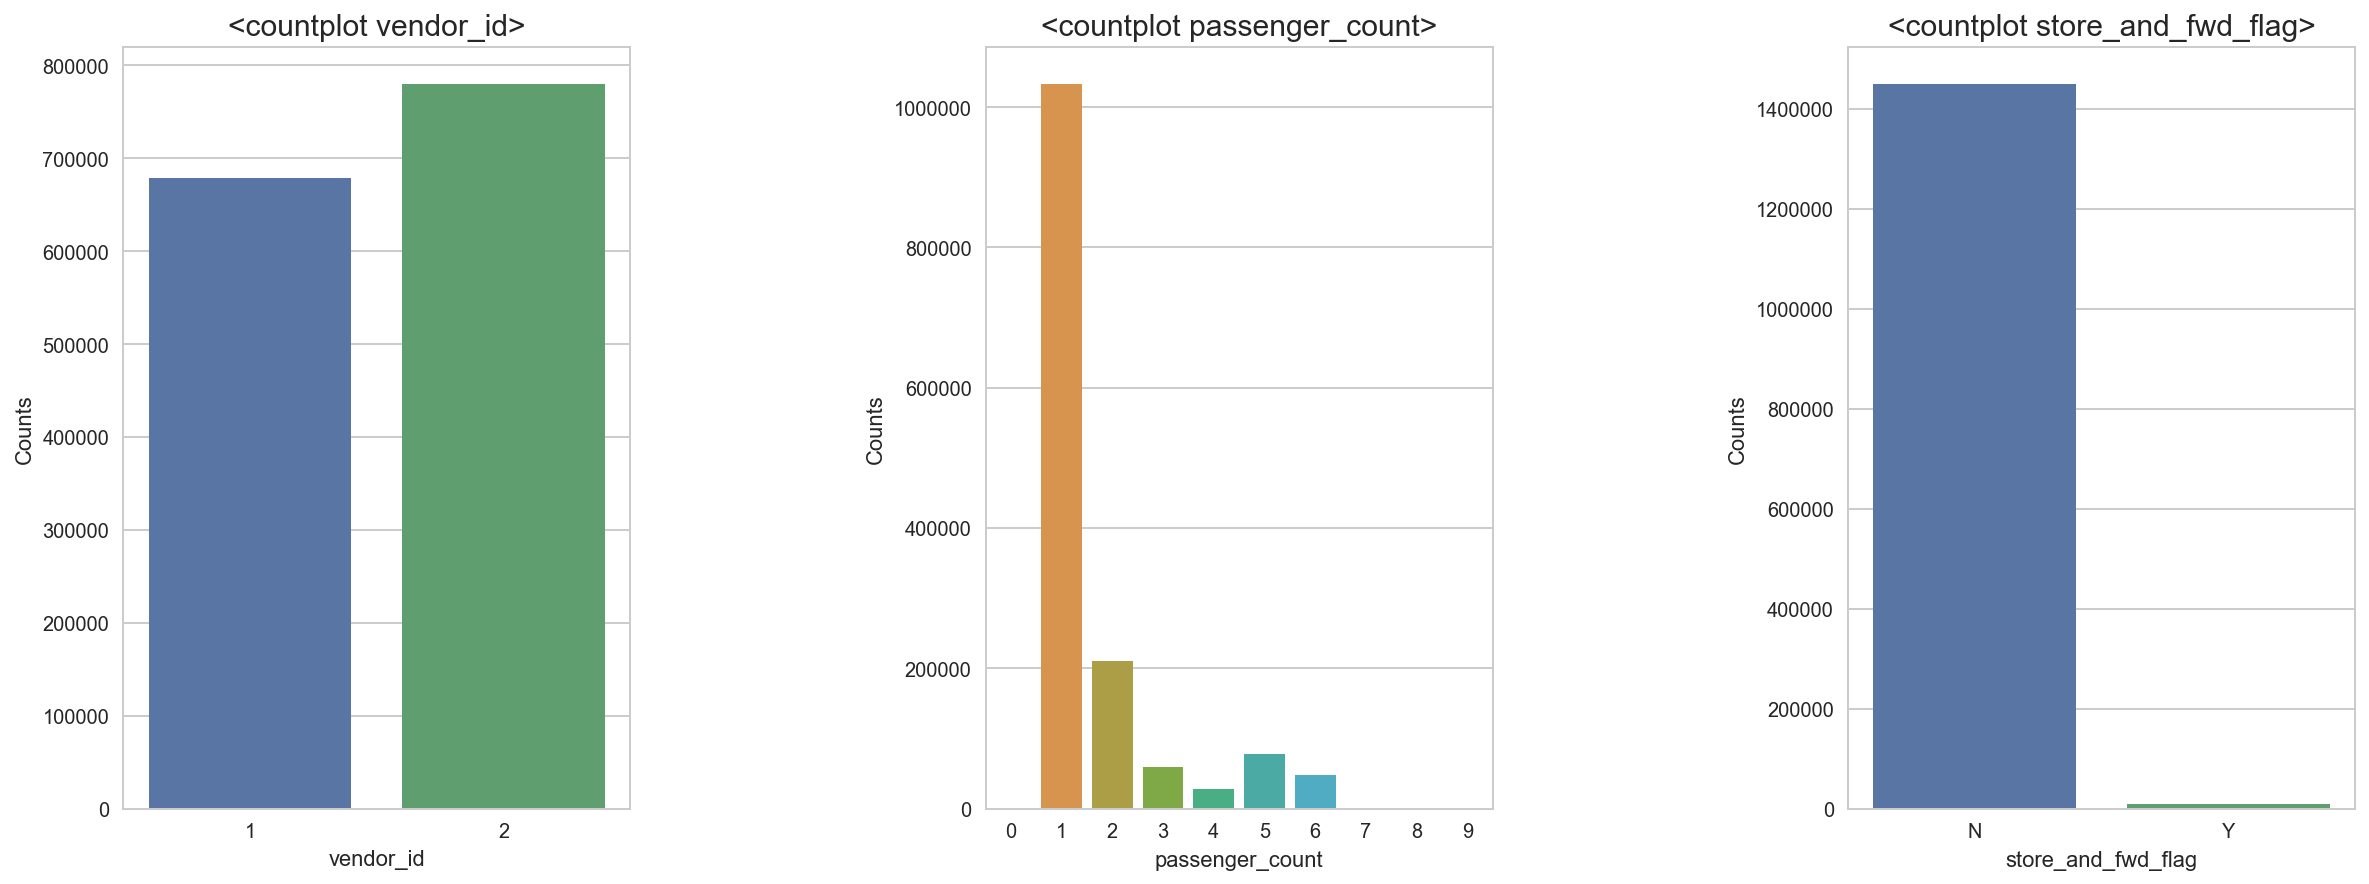

In [6]:
# countplot
plt.figure(figsize=(20, 7))
plt.subplots_adjust(wspace = 0.7)

# vendor_id
plt.subplot(131)
sns.countplot(x = 'vendor_id', data = taxi)
plt.title('<countplot vendor_id>', fontsize = 15)
plt.xlabel('vendor_id')
plt.ylabel('Counts')

# passenger_count
plt.subplot(132)
sns.countplot(x = 'passenger_count', data = taxi)
plt.title('<countplot passenger_count>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('Counts')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(x = 'store_and_fwd_flag', data = taxi)
plt.title('<countplot store_and_fwd_flag>', fontsize = 15)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Counts')

plt.show()

### - 좌표 변수 
( pickup_longitude / pickup_latitude / dropoff_longitude / dropoff_latitude )

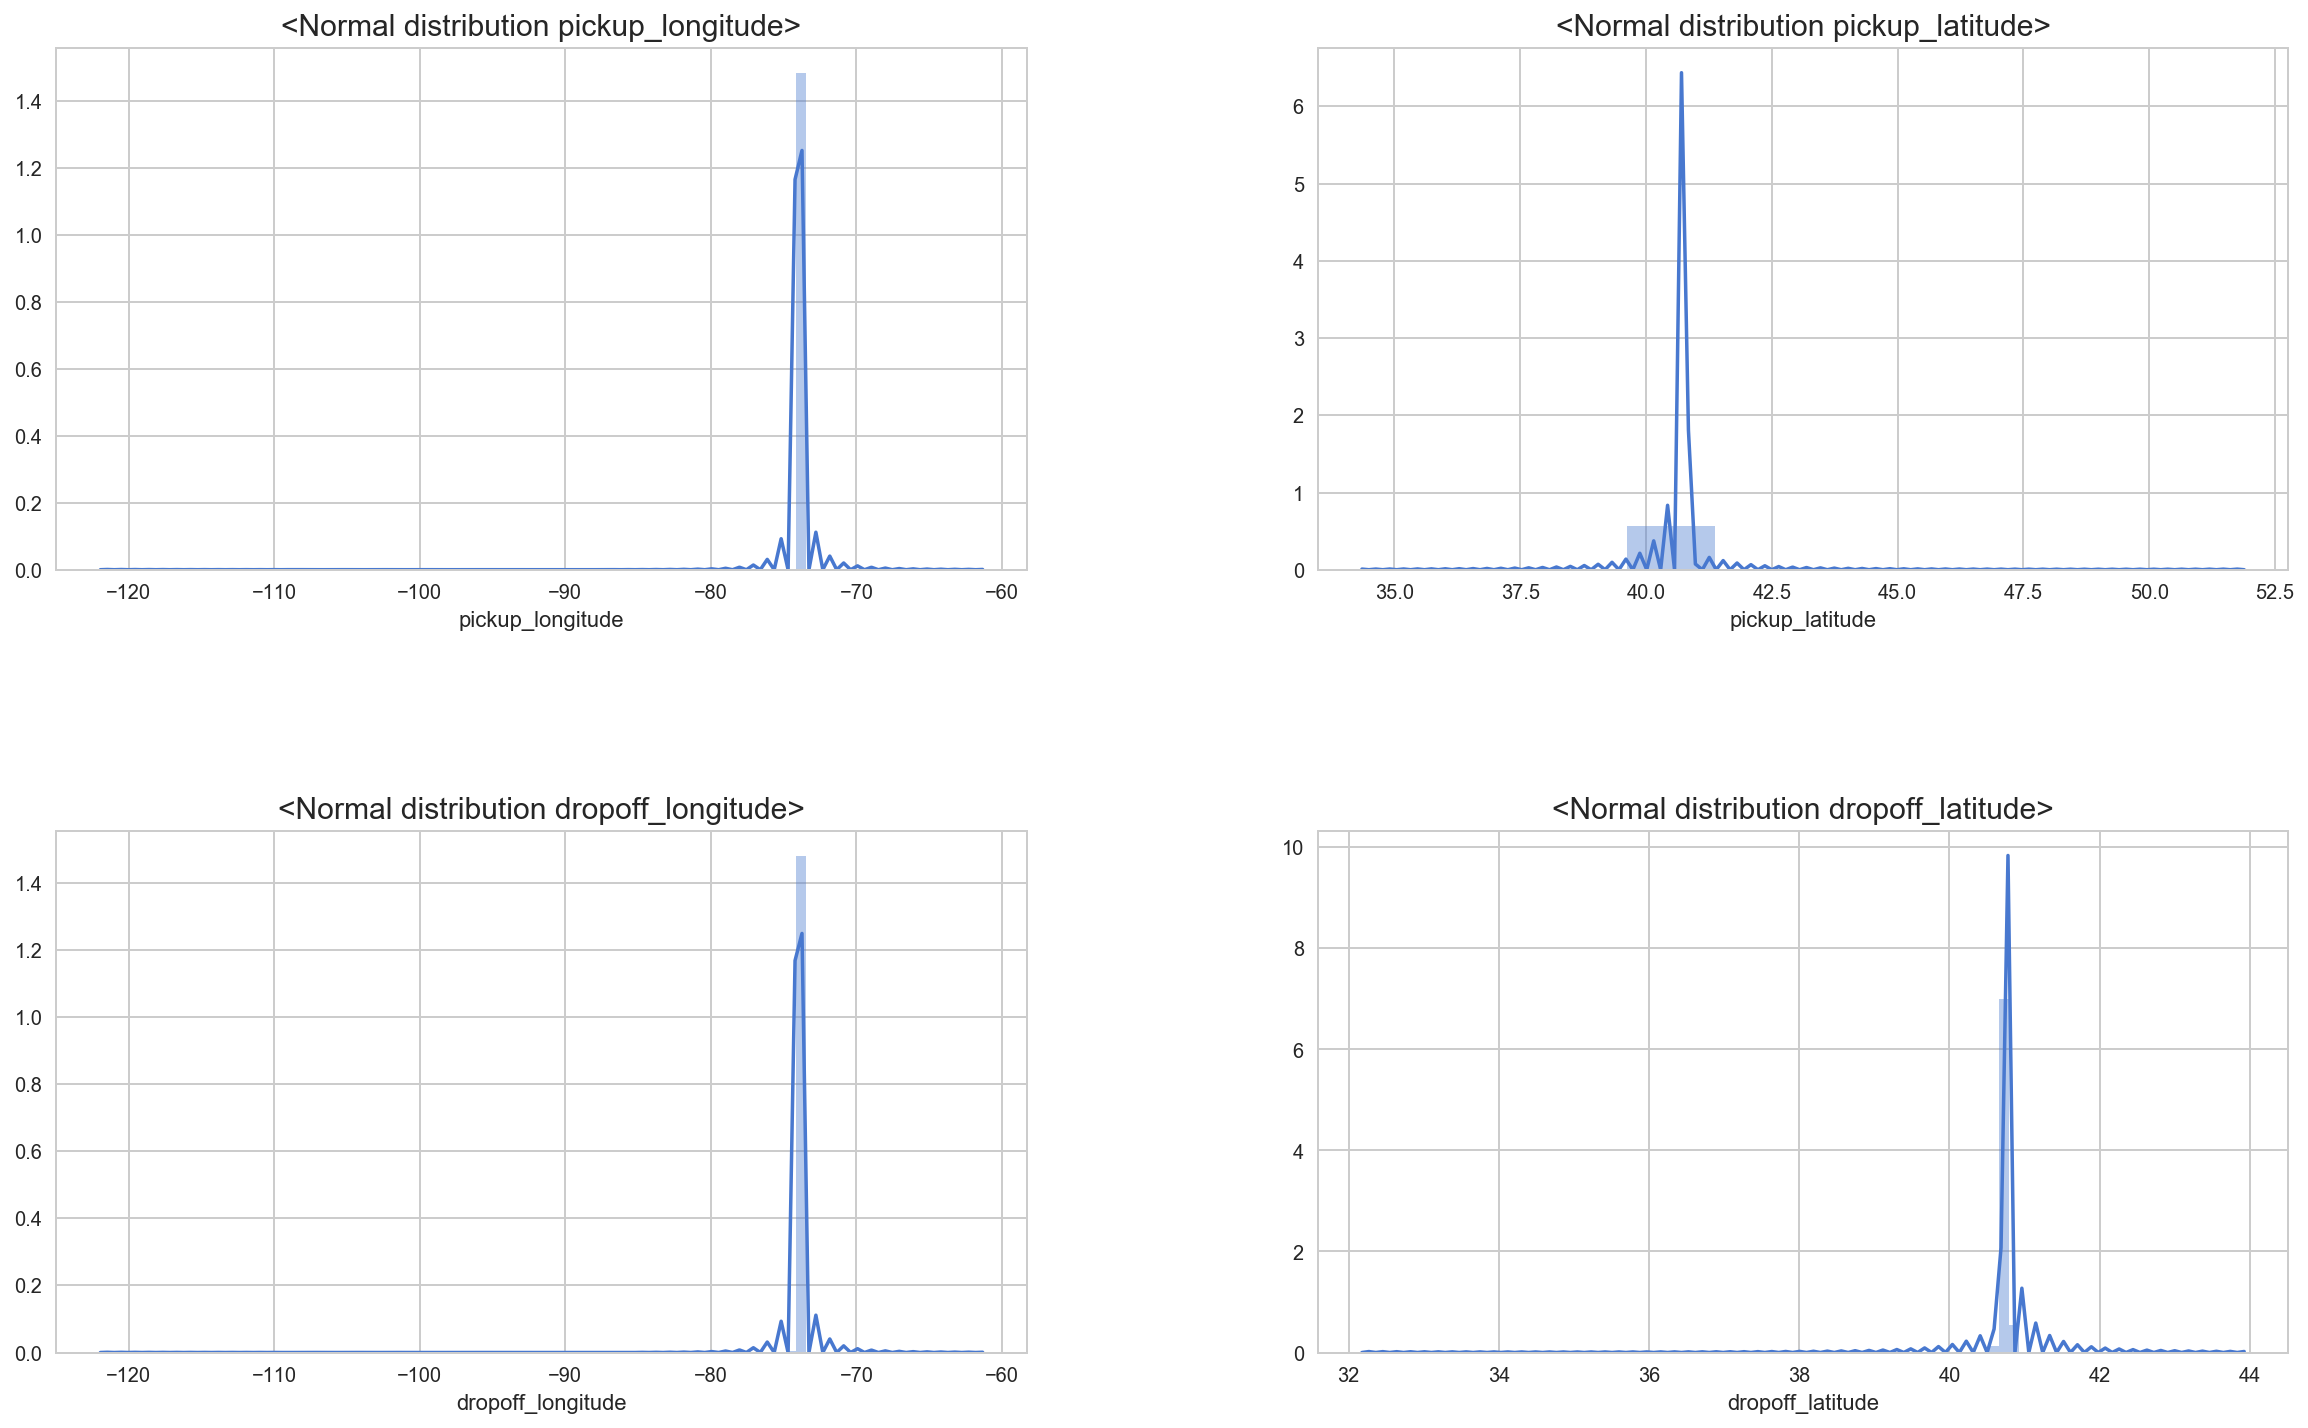

In [7]:
# normal distribution
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pickup_longitude
plt.subplot(221)
plt.title("<Normal distribution pickup_longitude>", fontsize = 15)
sns.distplot(taxi["pickup_longitude"].values, 
             axlabel = "pickup_longitude", bins = 90, color = "b")


# pickup_latitude
plt.subplot(222)
plt.title("<Normal distribution pickup_latitude>", fontsize = 15)
sns.distplot(taxi["pickup_latitude"].values, 
             axlabel = "pickup_latitude", bins = 10, color = "b")

# dropoff_longitude
plt.subplot(223)
plt.title("<Normal distribution dropoff_longitude>", fontsize = 15)
sns.distplot(taxi["dropoff_longitude"].values, 
             axlabel = "dropoff_longitude", bins = 90, color = "b")

# dropoff_latitude
plt.subplot(224)
plt.title("<Normal distribution dropoff_latitude>", fontsize = 15)
sns.distplot(taxi["dropoff_latitude"].values, 
             axlabel = "dropoff_latitude", bins = 90, color = "b")

plt.show()

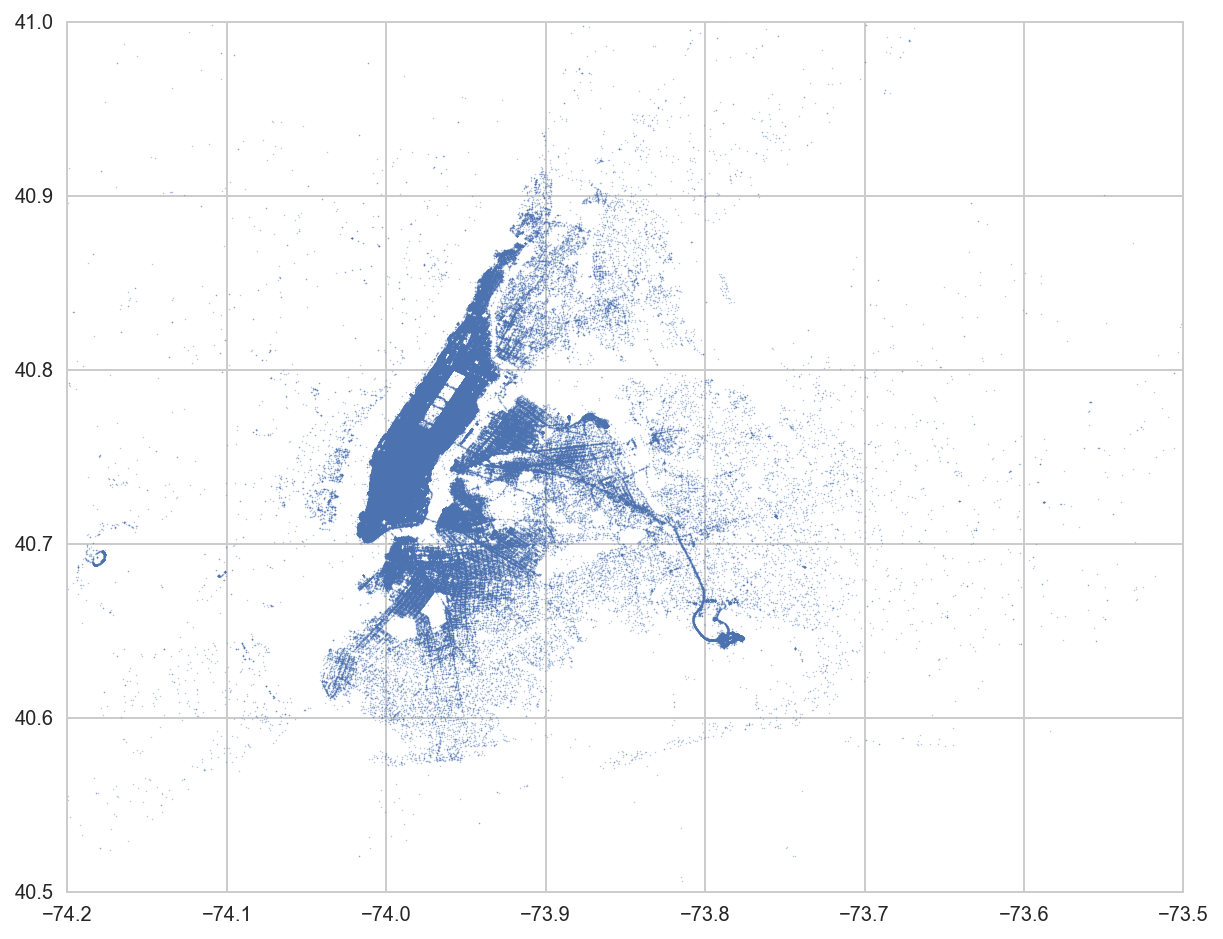

In [8]:
# 좌표 표시
longitude = list(taxi['pickup_longitude']) + list(taxi['dropoff_longitude'])
latitude = list(taxi['pickup_latitude']) + list(taxi['dropoff_latitude'])
plt.figure(figsize = (10, 8))
plt.xlim(-74.2, -73.5)
plt.ylim(40.5, 41)
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 1.5)
plt.show()

### c. 종속 변수

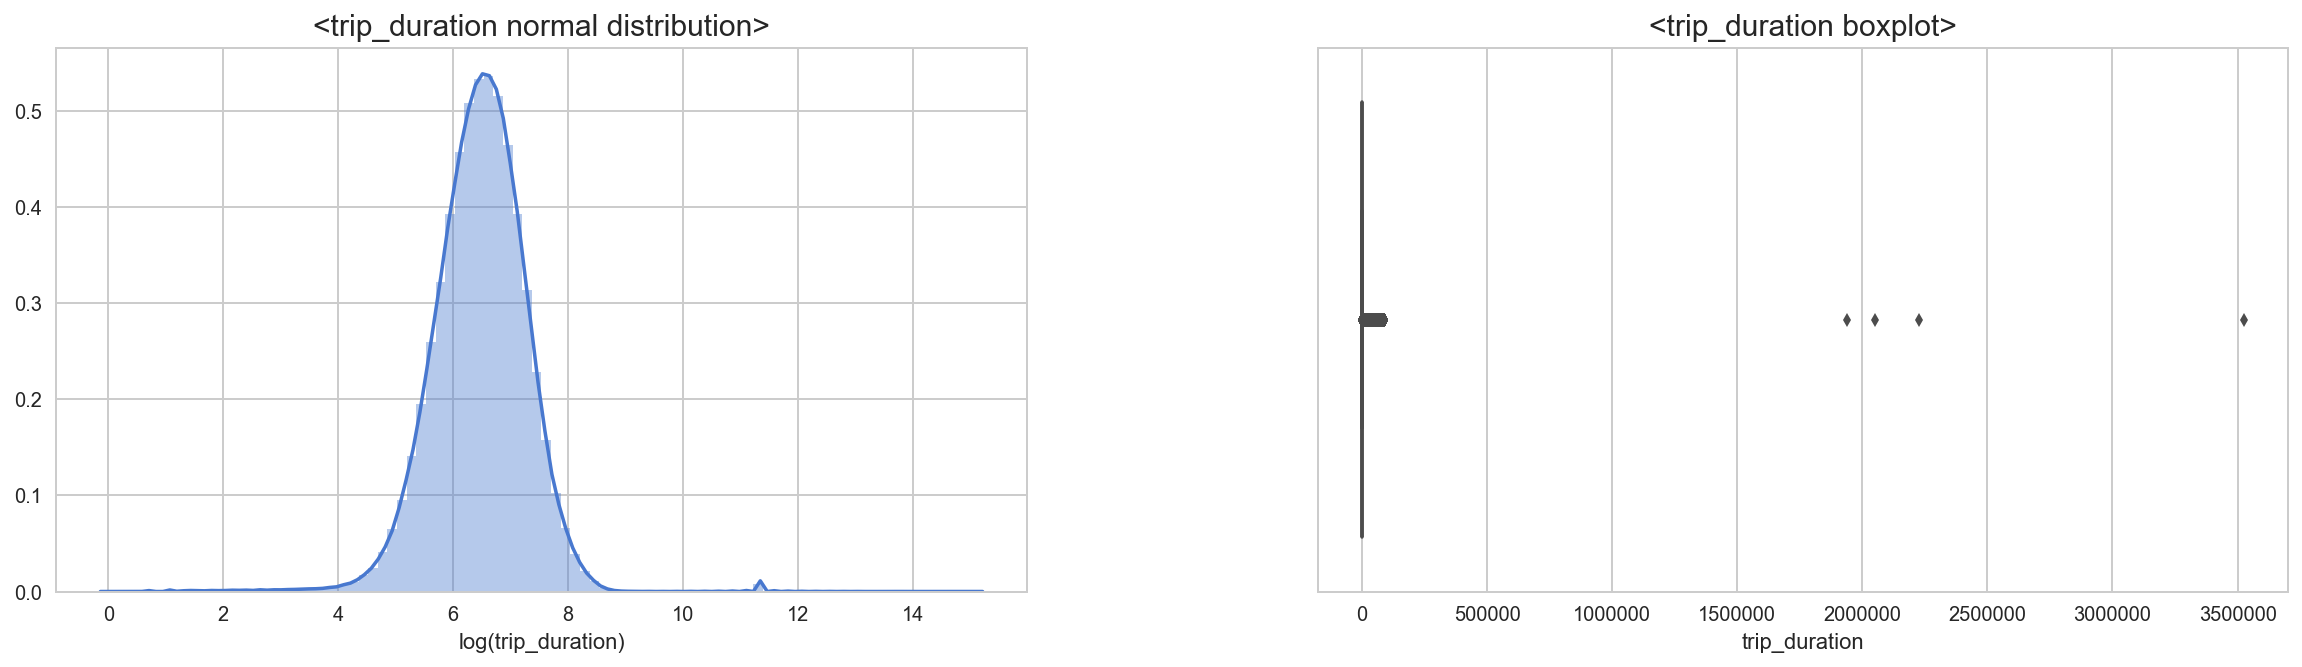

In [9]:
# trip_duration
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.3)

plt.subplot(121)
plt.title("<trip_duration normal distribution>", fontsize = 15)
sns.distplot(np.log(taxi["trip_duration"]).values, 
             axlabel = "log(trip_duration)", label = "trip_duration", bins = 90, color = "b")

plt.subplot(122)
sns.boxplot(x = 'trip_duration', data = taxi)
plt.title('<trip_duration boxplot>', fontsize = 15)
plt.xlabel('trip_duration')

plt.show()

### d. Data edit / add

### Data edit

In [10]:
# store_and_fwd_flag -  N, Y 를 0, 1 숫자로 변경
taxi['store_and_fwd_flag'] = taxi['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# pickup_datetime, dropoff_datetime 형식 바꿈 (2016.01.01 기준)
taxi['pickup_datetime'] = taxi['pickup_datetime'].apply(strptime)
taxi['dropoff_datetime'] = taxi['dropoff_datetime'].apply(strptime)

### Data add

In [11]:
# 좌표를 이용해 거리 생성
taxi['dist'] = haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'], 
                            taxi['dropoff_longitude'], taxi['dropoff_latitude'])

# date 숫자화
taxi['pick_date'] = taxi['pickup_datetime'].apply(date_to_zero)
taxi['pick_time'] = taxi['pickup_datetime'].apply(time_to_zero)

# date 카테고리화
taxi["pickup_datetime"] = pd.to_datetime(taxi["pickup_datetime"]) 
taxi["month"] = taxi["pickup_datetime"].dt.month # 월
taxi["hour"] = taxi["pickup_datetime"].dt.hour # 시간
taxi["weekday"] = taxi["pickup_datetime"].dt.weekday # 요일 (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일)
taxi['holiday'] = taxi['pickup_datetime'].apply(holiday) # 휴일 (휴일 X:1, 휴일 O:2)

#extreme_weather data 추가 입력
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date
weather_event = weather_event.astype('<U32')
weather_event = list(weather_event)

taxi["y-m-d"] = pd.to_datetime(taxi["pickup_datetime"]).apply(lambda x: x.strftime("%Y-%m-%d"))
taxi["extreme_weather"] = taxi["y-m-d"].apply(lambda x: 1 if x in weather_event else 0)
taxi["weather_event"] = taxi["extreme_weather"]

In [12]:
taxi.tail()

id  vendor_id     pickup_datetime    dropoff_datetime  \
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
1458639                4            -73.98            40.75   
1458640                1            -74.00            40.75   
1458641                1            -73.96            40.77   
1458642                1            -73.98            40.75   
1458643                1            -73.98            40.78   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
1458639             -73.99             40.74                   0   
1458640             -73.97             40.80                   0   
1458641             -74.00             40.71                   0   
1458642             -73.97             40.76                   0   
1458643             -73.97             40.79                   0   

             ...        dist  pick_date  pick_time  month  hour  weekday  \
1458639      ...        1.22         98      48663      4    13        4   
1458640      ...        6.05          9      27314      1     7        6   
1458641      ...        7.82        112      25060      4     6        4   
1458642      ...        1.09          4      57385      1    15        1   
1458643      ...        1.13         95      53064      4    14        1   

         holiday       y-m-d extreme_weather  weather_event  
1458639        0  2016-04-08               0              0  
1458640        0  2016-01-10               1              1  
1458641        0  2016-04-22               0              0  
1458642        0  2016-01-05               0              0  
1458643        0  2016-04-05               0              0  

[5 rows x 21 columns]

### e. Data reset

In [13]:
# 최종 데이터
# 차후 분석을 위해 연속형 데이터, 카테고리 데이터, y(trip_duration)순으로 재배치
c_1 = taxi['vendor_id']
c_2 = taxi['passenger_count']
c_3 = taxi['store_and_fwd_flag']
c_4 = taxi['month']
c_5 = taxi['hour']
c_6 = taxi['weekday']
c_7 = taxi['holiday']
c_8 = taxi['weather_event']
y = taxi['trip_duration'] 

taxi = taxi.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count' , 'store_and_fwd_flag',  'trip_duration', 'month', 'hour', 'weekday', 'holiday', 'y-m-d', 'extreme_weather', 'weather_event'], axis = 1)

taxi['vendor_id'] = c_1
taxi['passenger_count'] = c_2
taxi['store_and_fwd_flag'] = c_3 
taxi['month'] = c_4 
taxi['hour'] = c_5 
taxi['weekday'] = c_6 
taxi['holiday'] = c_7 
taxi['weather_event'] = c_8
taxi['trip_duration'] = y
taxi.tail()

pickup_longitude  pickup_latitude  dropoff_longitude  \
1458639            -73.98            40.75             -73.99   
1458640            -74.00            40.75             -73.97   
1458641            -73.96            40.77             -74.00   
1458642            -73.98            40.75             -73.97   
1458643            -73.98            40.78             -73.97   

         dropoff_latitude  dist  pick_date  pick_time  vendor_id  \
1458639             40.74  1.22         98      48663          2   
1458640             40.80  6.05          9      27314          1   
1458641             40.71  7.82        112      25060          2   
1458642             40.76  1.09          4      57385          1   
1458643             40.79  1.13         95      53064          1   

         passenger_count  store_and_fwd_flag  month  hour  weekday  holiday  \
1458639                4                   0      4    13        4        0   
1458640                1                   0      1     7        6        0   
1458641                1                   0      4     6        4        0   
1458642                1                   0      1    15        1        0   
1458643                1                   0      4    14        1        0   

         weather_event  trip_duration  
1458639              0            778  
1458640              1            655  
1458641              0            764  
1458642              0            373  
1458643              0            198

In [14]:
taxi.to_csv('edit_taxi.csv', index = False)

### f. add data EDA

### 카테고리 변수

( month / hour / weekday / holiday / weather_event )

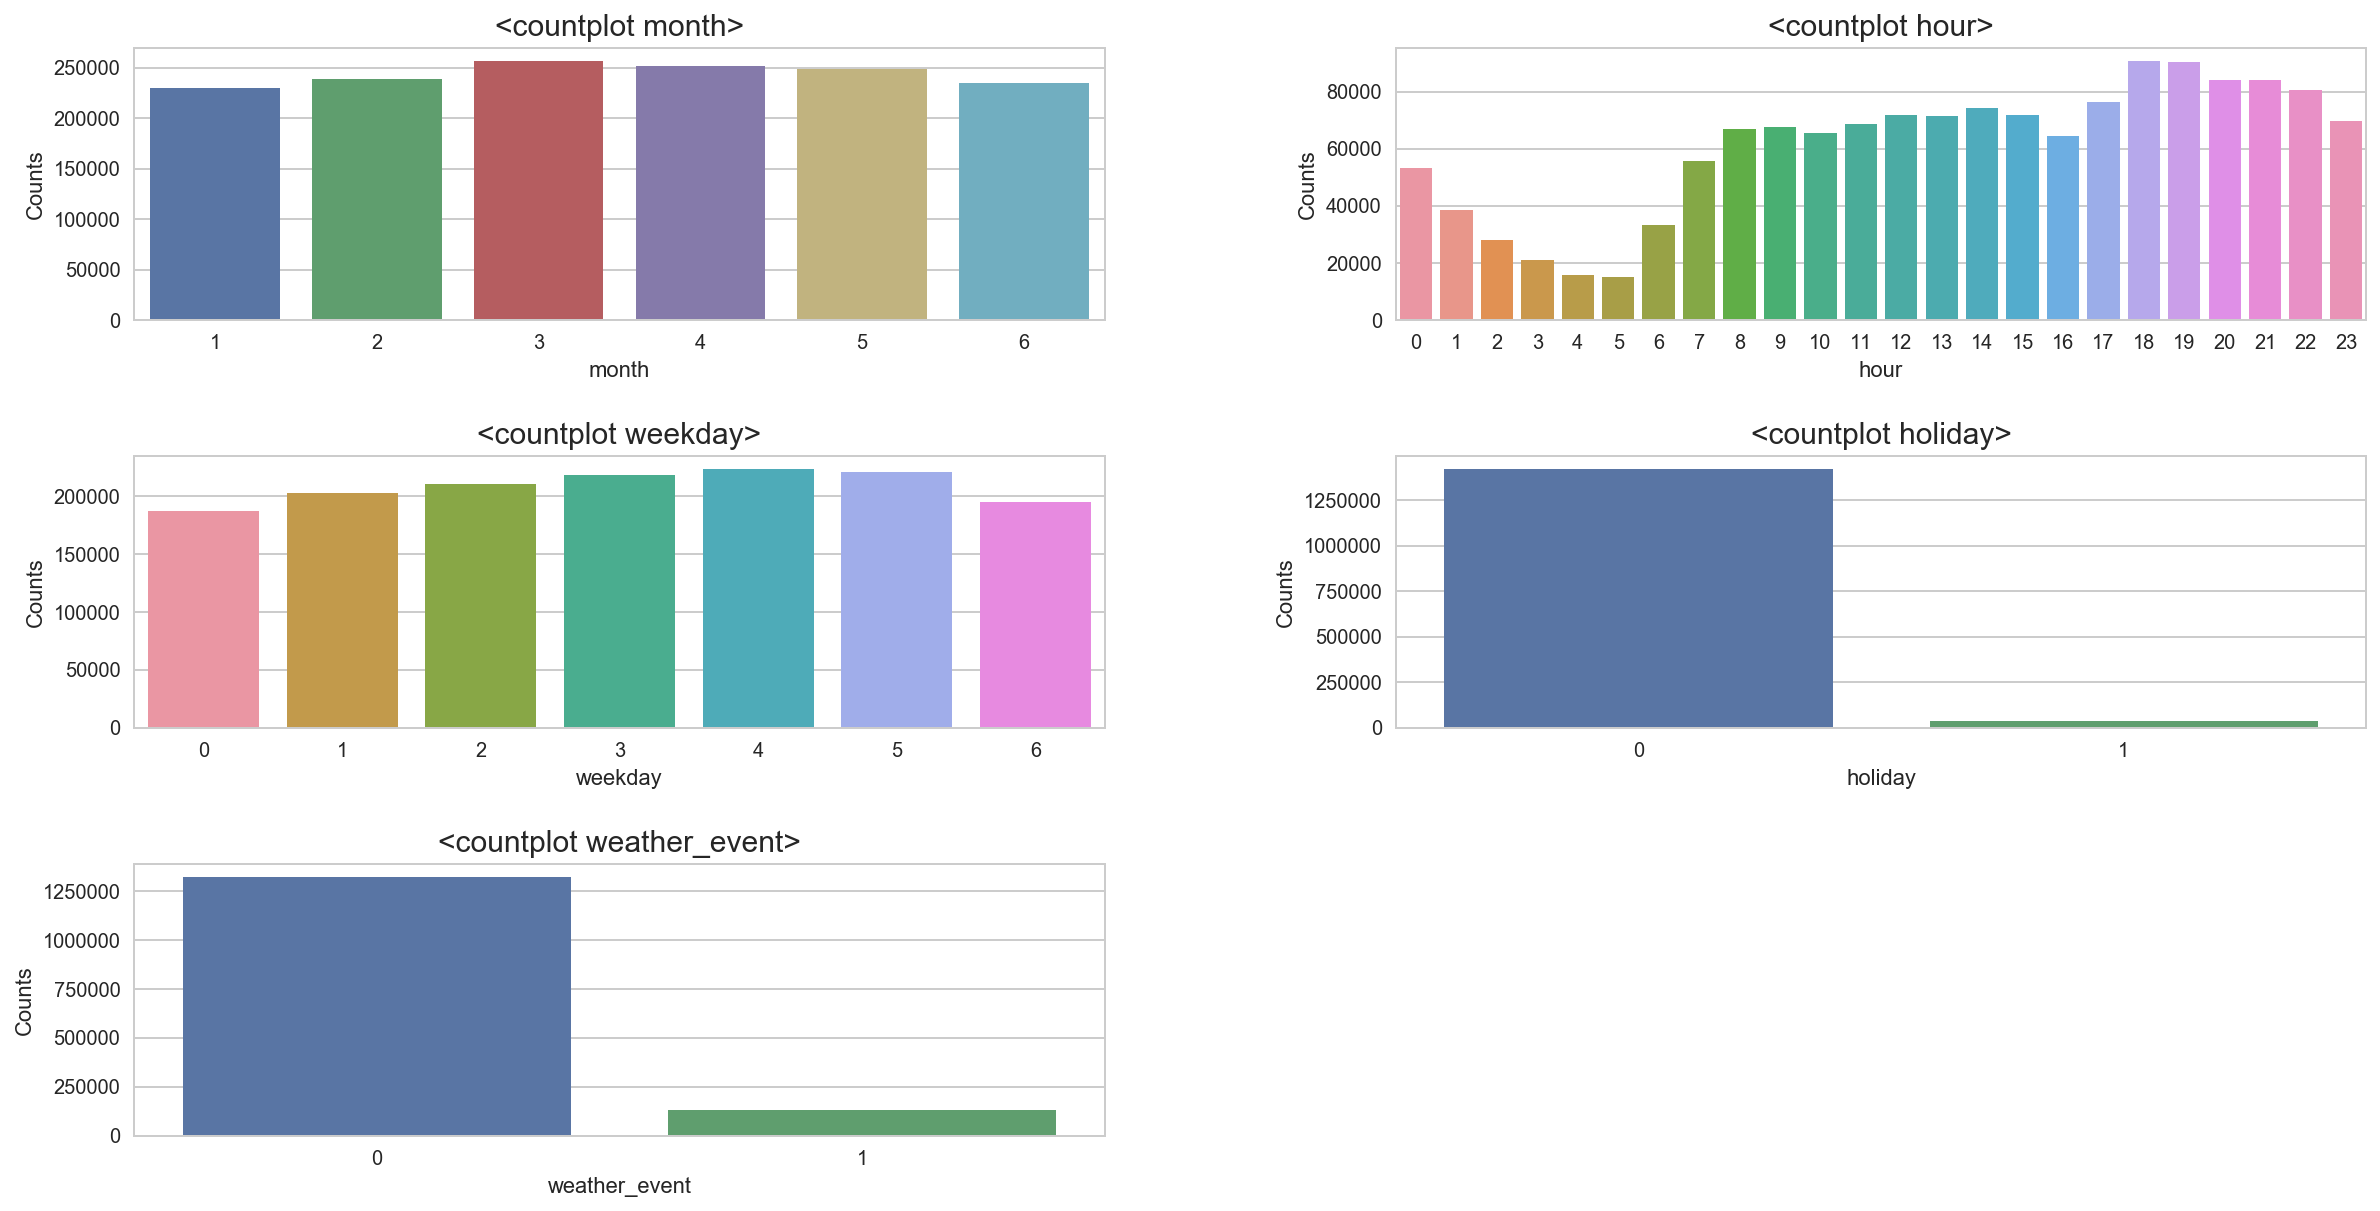

In [15]:
# countplot
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

# vendor_id
plt.subplot(321)
sns.countplot(x = 'month', data = taxi)
plt.title('<countplot month>', fontsize = 15)
plt.xlabel('month')
plt.ylabel('Counts')

# hour
plt.subplot(322)
sns.countplot(x = 'hour', data = taxi)
plt.title('<countplot hour>', fontsize = 15)
plt.xlabel('hour')
plt.ylabel('Counts')

# weekday
plt.subplot(323)
sns.countplot(x = 'weekday', data = taxi)
plt.title('<countplot weekday>', fontsize = 15)
plt.xlabel('weekday')
plt.ylabel('Counts')

# holiday
plt.subplot(324)
sns.countplot(x = 'holiday', data = taxi)
plt.title('<countplot holiday>', fontsize = 15)
plt.xlabel('holiday')
plt.ylabel('Counts')

# store_and_fwd_flag
plt.subplot(325)
sns.countplot(x = 'weather_event', data = taxi)
plt.title('<countplot weather_event>', fontsize = 15)
plt.xlabel('weather_event')
plt.ylabel('Counts')

plt.show()

### 연속형 변수

( dist / pick_time / pick_date )

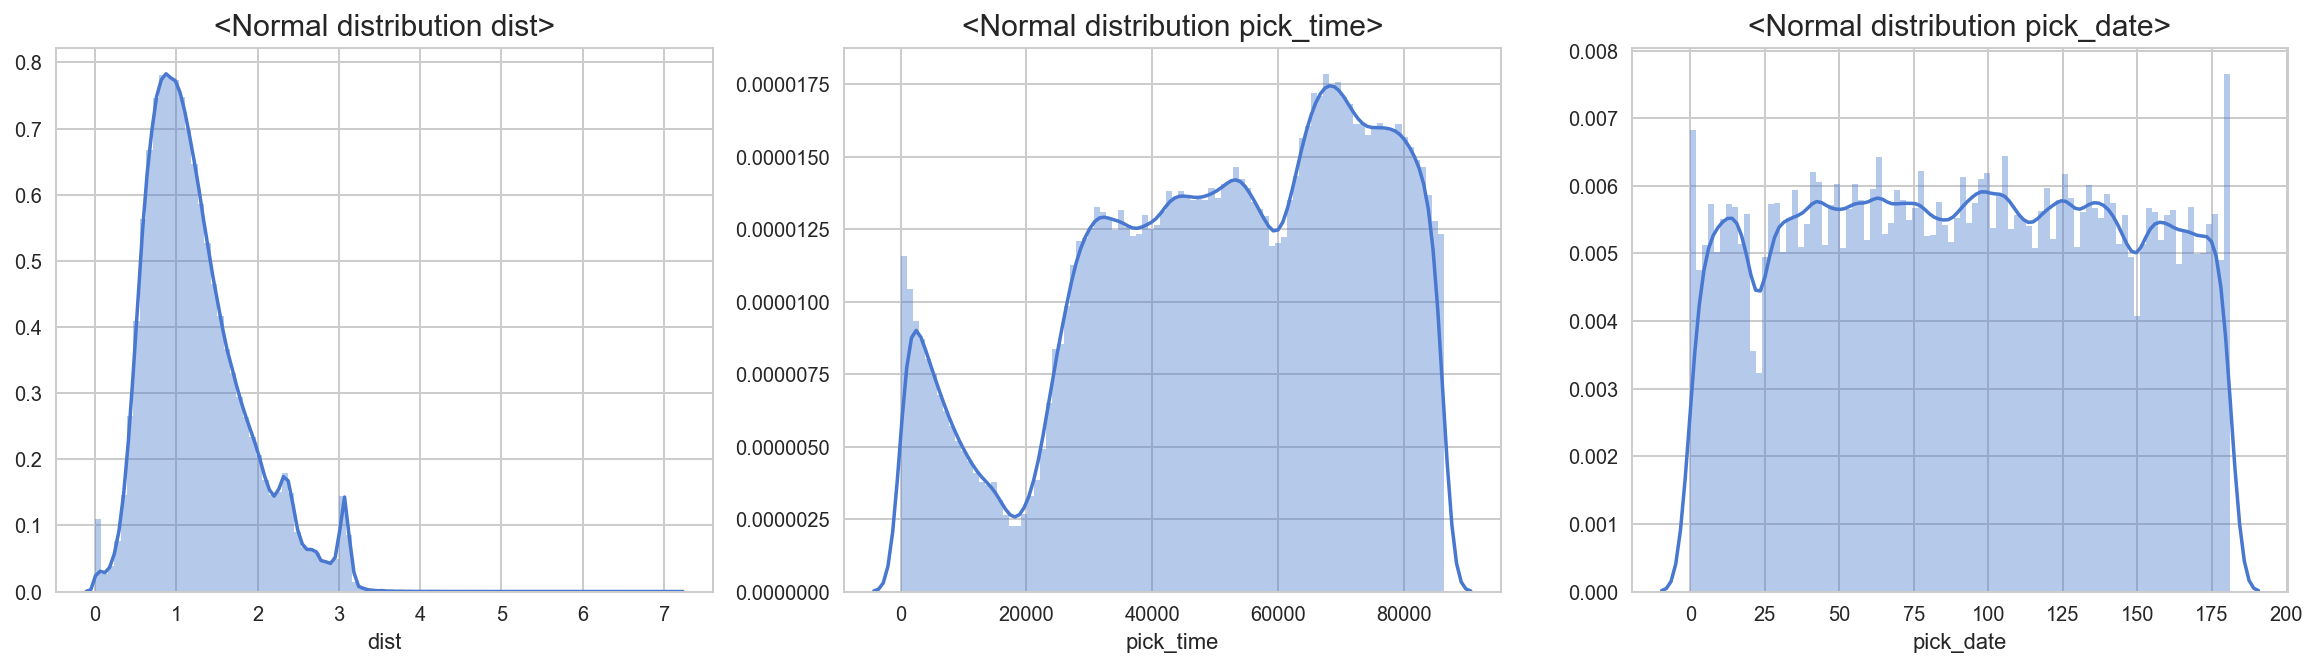

In [16]:
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.2)

# dist
plt.subplot(131)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(np.log1p(taxi["dist"]).values, 
             axlabel = "dist", label = "dist", bins = 90, color = "b")

# pick_time
plt.subplot(132)
plt.title("<Normal distribution pick_time>", fontsize = 15)
sns.distplot(taxi["pick_time"].values, 
             axlabel = "pick_time", label = "pick_time", bins = 90, color = "b")

# pick_date
plt.subplot(133)
plt.title("<Normal distribution pick_date>", fontsize = 15)
sns.distplot(taxi["pick_date"].values, 
             axlabel = "pick_date", label = "pick_date", bins = 90, color = "b")

plt.show()

### g. 이상치 제거 EDA

In [17]:
# 이상치 체크
taxi[taxi['trip_duration'] > 1500000]

pickup_longitude  pickup_latitude  dropoff_longitude  \
355003            -73.79            40.64             -73.96   
680594            -73.92            40.74             -73.98   
924150            -73.98            40.74             -73.99   
978383            -73.78            40.65             -73.98   

        dropoff_latitude  dist  pick_date  pick_time  vendor_id  \
355003             40.77 20.14          4       1181          1   
680594             40.76  5.98         43      81479          1   
924150             40.73  1.63          4      22454          1   
978383             40.75 19.89         43      82011          1   

        passenger_count  store_and_fwd_flag  month  hour  weekday  holiday  \
355003                1                   0      1     0        1        0   
680594                2                   0      2    22        5        0   
924150                1                   0      1     6        1        0   
978383                1                   0      2    22        5        0   

        weather_event  trip_duration  
355003              0        1939736  
680594              0        2049578  
924150              0        2227612  
978383              0        3526282

In [18]:
# Trip_duration에서 나타난 4개의 이상치 제거
taxi = taxi[taxi['trip_duration'] < 1500000].reset_index(drop=True)

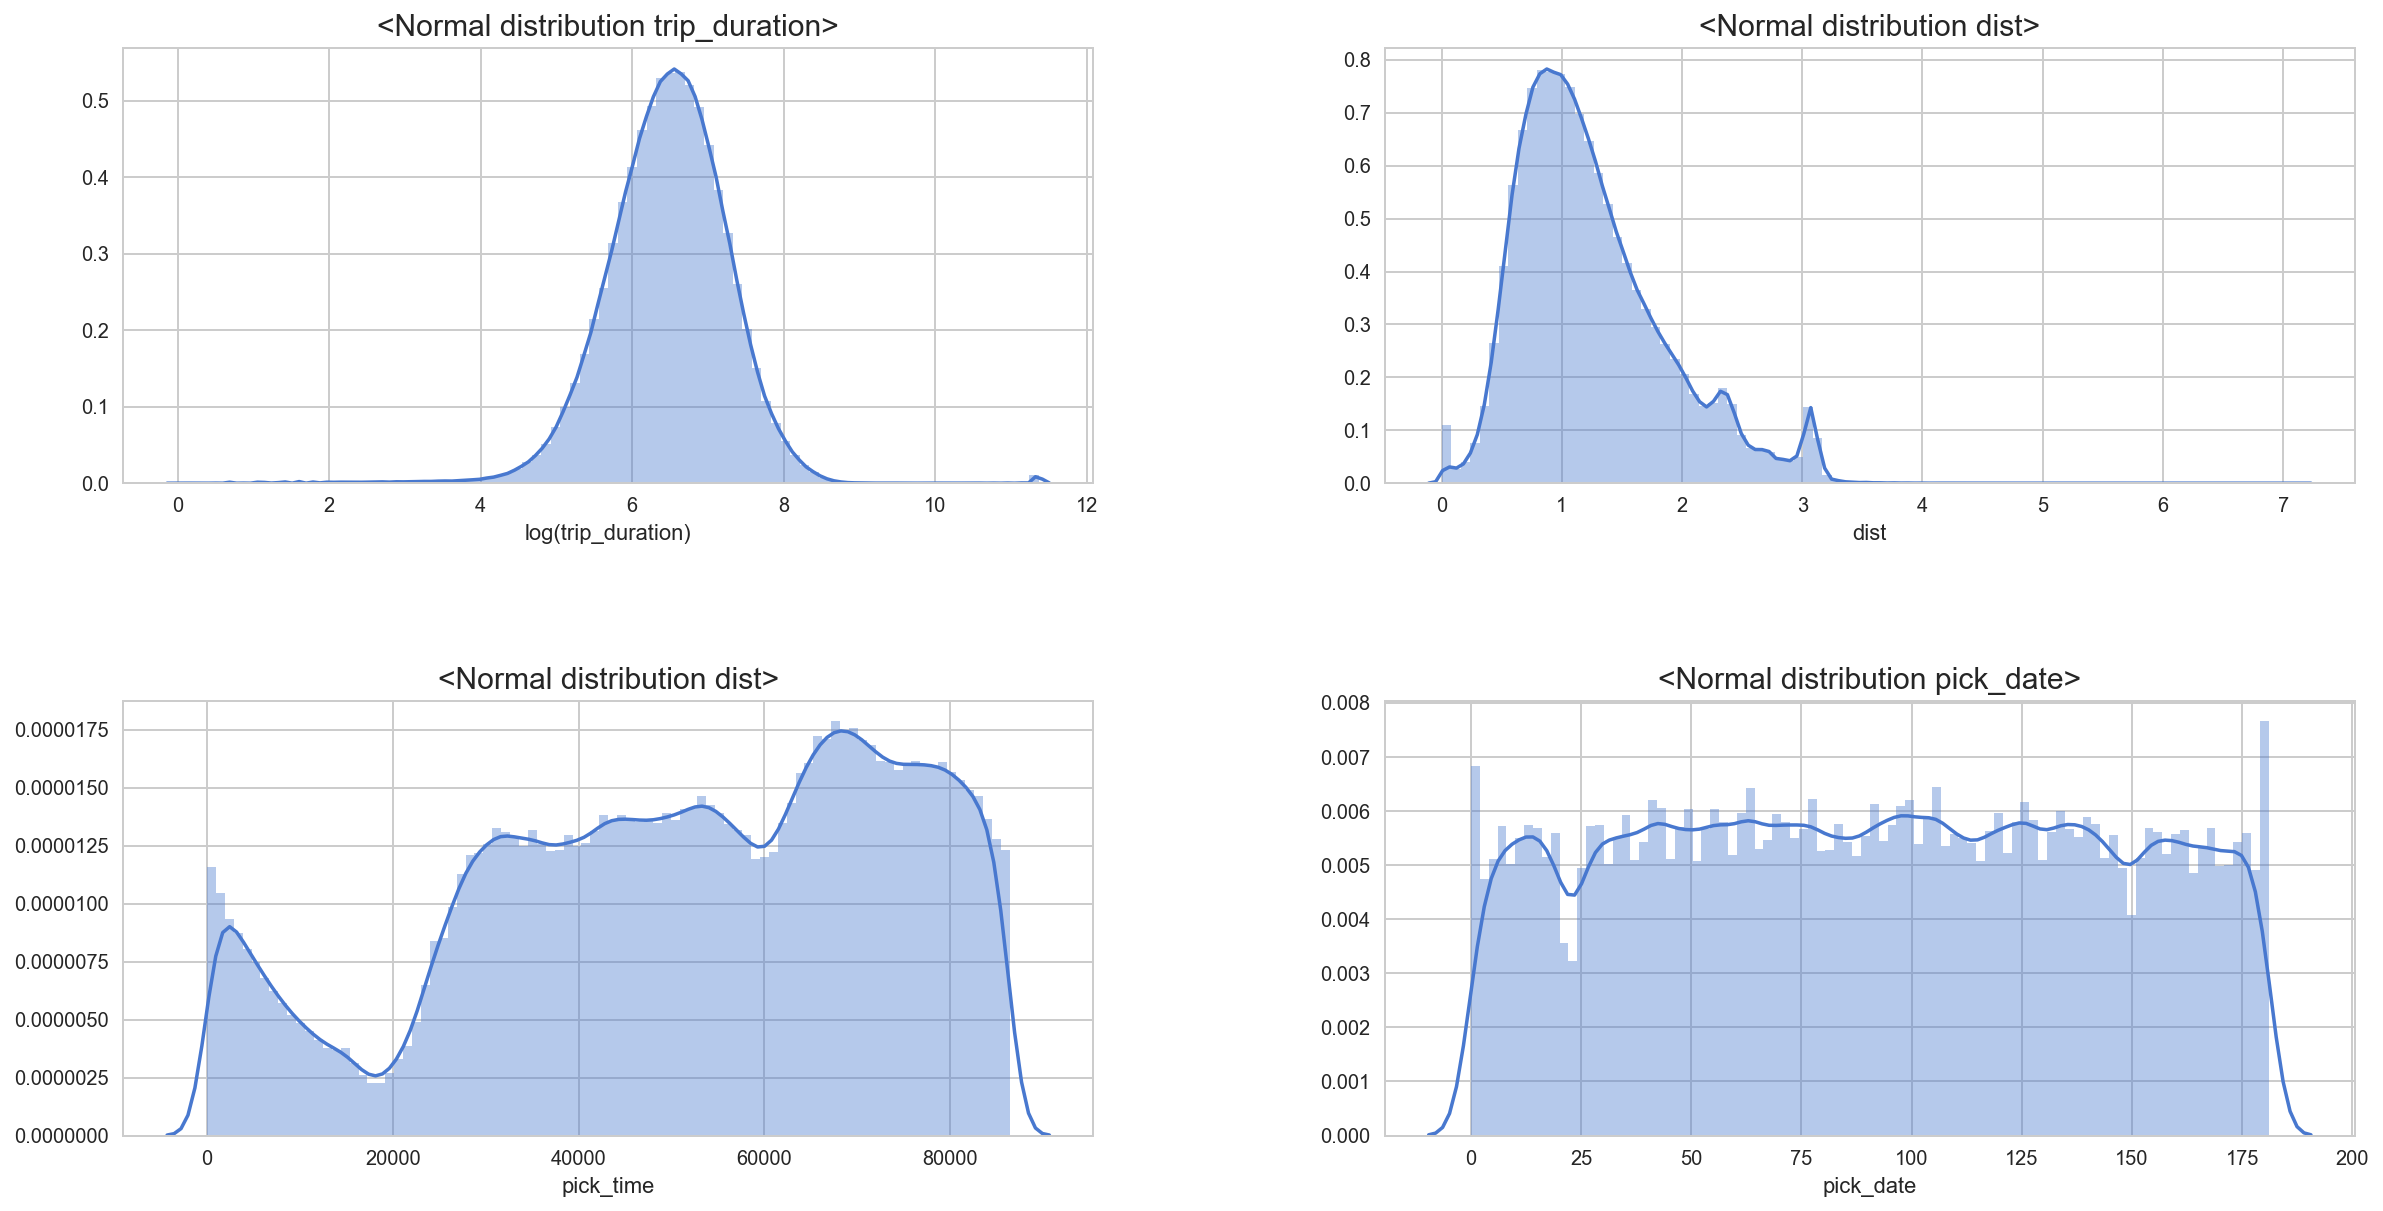

In [19]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.title("<Normal distribution trip_duration>", fontsize = 15)
sns.distplot(np.log(taxi["trip_duration"]).values, 
             axlabel = "log(trip_duration)", label = "trip_duration", bins = 90, color = "b")

plt.subplot(222)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(np.log1p(taxi["dist"]).values, 
             axlabel = "dist", label = "dist", bins = 90, color = "b")

plt.subplot(223)
plt.title("<Normal distribution dist>", fontsize = 15)
sns.distplot(taxi["pick_time"].values, 
             axlabel = "pick_time", label = "pick_time", bins = 90, color = "b")

plt.subplot(224)
plt.title("<Normal distribution pick_date>", fontsize = 15)
sns.distplot(taxi["pick_date"].values, 
             axlabel = "pick_date", label = "pick_date", bins = 90, color = "b")

plt.show()

## B. Correlation

### a. Heatmap

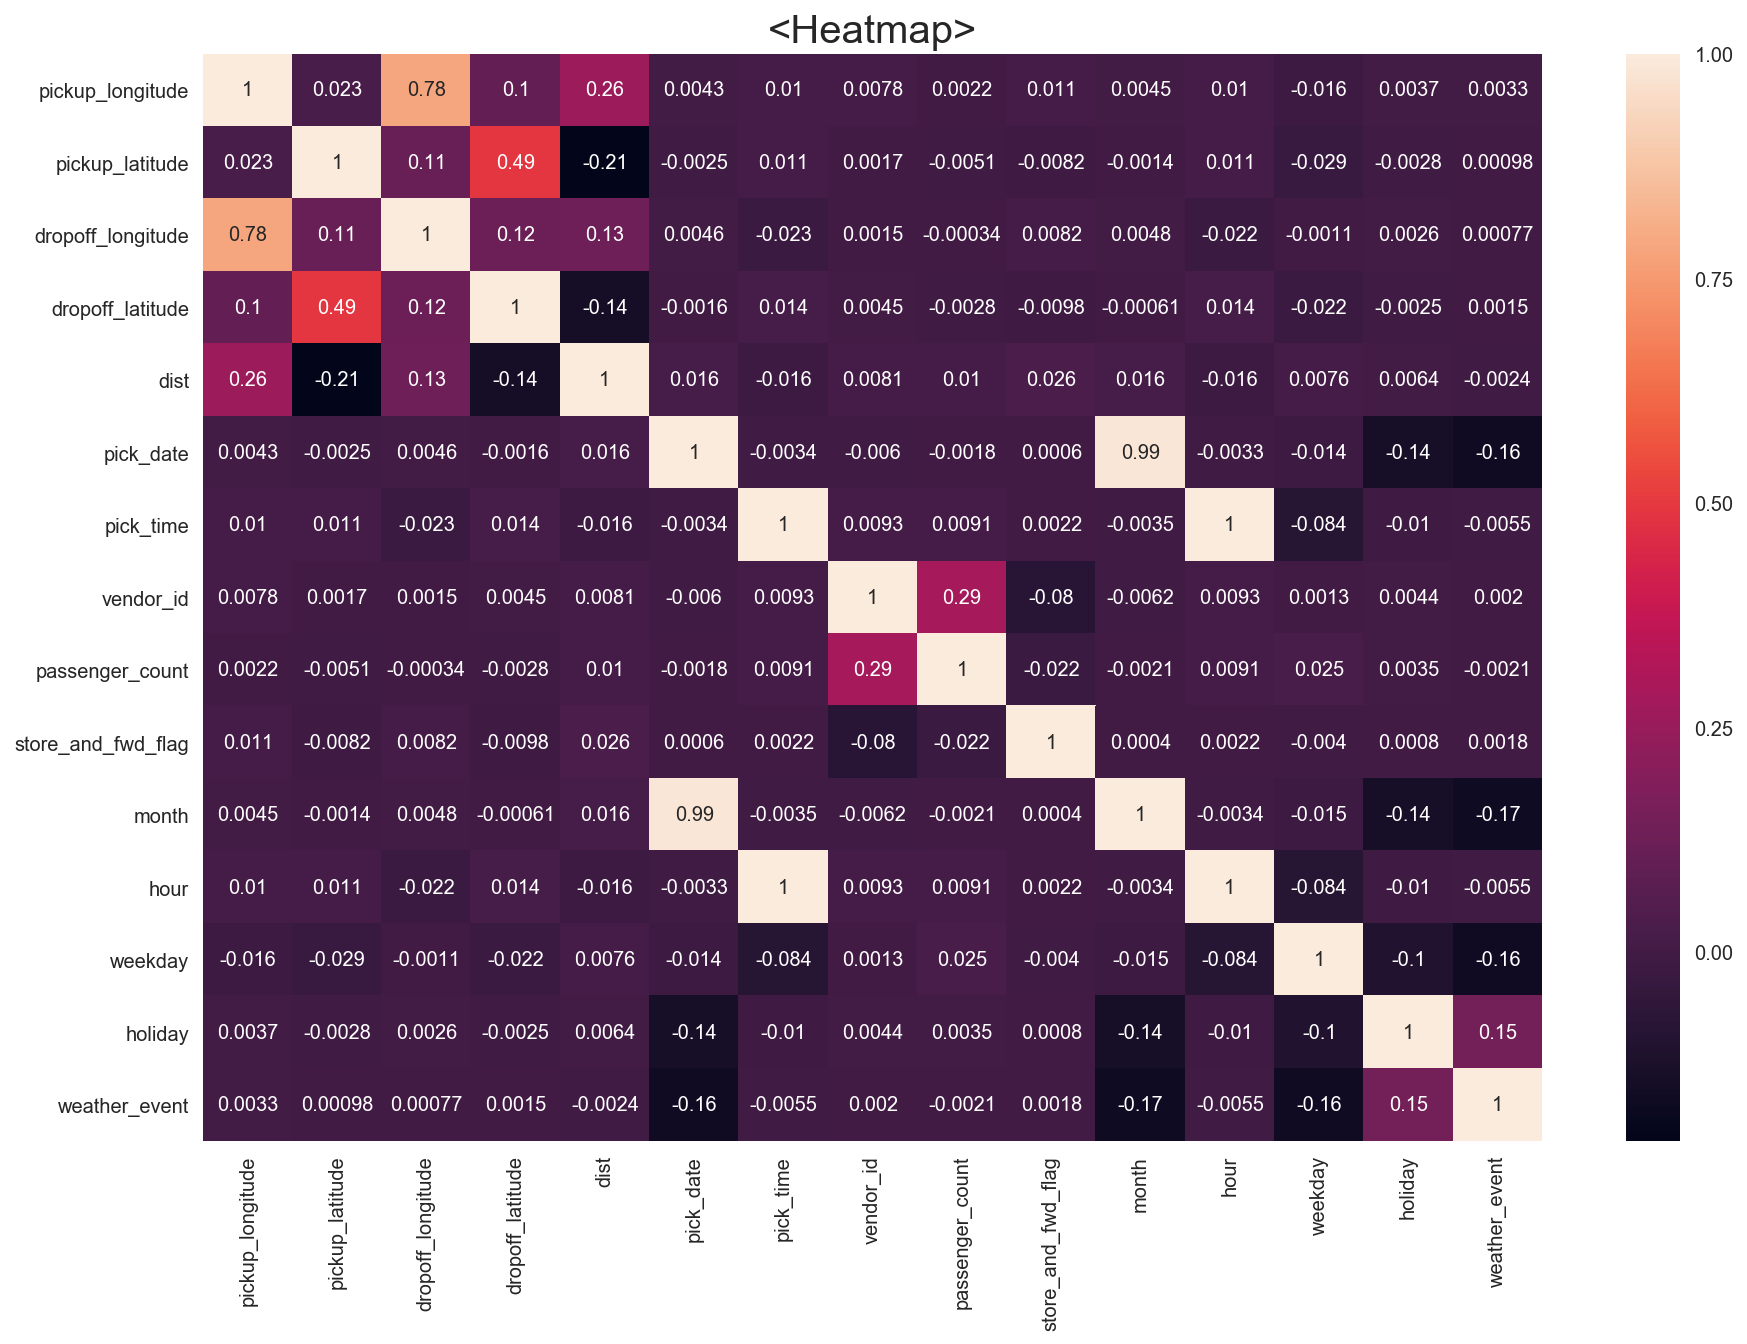

In [20]:
f, ax = plt.subplots(figsize=(15, 10))
taxi_heatmap = taxi.drop(['trip_duration'], axis = 1)
sns.heatmap(taxi_heatmap.corr(), annot=True)
plt.title("<Heatmap>", fontsize = 20)

plt.show()

### b. pairplot

In [21]:
# 오래 걸려서 일단 패스
# taxi_pair = taxi.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pick_time', 'drop_time'], axis = 1)
# sns.pairplot(taxi_pair)

### c. VIF ( Variance Inflation Factor )

In [22]:
taxi_vif = taxi.drop(['trip_duration'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(taxi_vif.values, i) for i in range(taxi_vif.shape[1])]
vif["features"] = taxi_vif.columns
vif

VIF Factor            features
0   2931146.94    pickup_longitude
1   1682155.58     pickup_latitude
2   2735707.59   dropoff_longitude
3   1477372.71    dropoff_latitude
4         1.71                dist
5       144.37           pick_date
6      2661.50           pick_time
7        11.48           vendor_id
8         2.84     passenger_count
9         1.01  store_and_fwd_flag
10      189.68               month
11     2511.00                hour
12        3.60             weekday
13        1.07             holiday
14        1.18       weather_event

---

# 2. Rough modeling

In [23]:
# feature 생성
feature_n, features = get_features(taxi, 0, -1)
feature_n, features

(15,
 'pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + vendor_id + passenger_count + store_and_fwd_flag + month + hour + weekday + holiday + weather_event')

In [24]:
# modeling
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = taxi)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2474.
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:09:54   Log-Likelihood:            -1.3811e+07
No. Observations:             1458640   AIC:                         2.762e+07
Df Residuals:                 1458624   BIC:                         2.762e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9.003e+04   5102.728     17.643      0.000       8e+04       1e+05
pickup_longitude    -316.0879     61.211     -5.164      0.000    -436.060    -196.116
pickup_latitude     -944.1455     92.676    -10.188      0.000   -1125.788    -762.503
dropoff_longitude    555.4969     60.131      9.238      0.000     437.642     673.351
dropoff_latitude    -826.7761     83.789     -9.867      0.000    -991.000    -662.552
dist                 109.5650      0.646    169.521      0.000     108.298     110.832
pick_date              0.5617      0.298      1.883      0.060      -0.023       1.146
pick_time             -0.0057      0.002     -2.391      0.017      -0.010      -0.001
vendor_id            215.0803      5.445     39.502      0.000     204.409     225.752
passenger_count        8.4107      2.061      4.081      0.000       4.371      12.450
store_and_fwd_flag    71.1045     35.139      2.023      0.043       2.232     139.977
month                  1.7609      9.162      0.192      0.848     -16.196      19.718
hour                  24.7195      8.642      2.861      0.004       7.782      41.657
weekday               -5.6786      1.358     -4.182      0.000      -8.340      -3.017
holiday              -85.1786     17.003     -5.010      0.000    -118.503     -51.854
weather_event        -42.9735      9.329     -4.606      0.000     -61.259     -24.688
==============================================================================
Omnibus:                  3542578.659   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      29873663873.675
Skew:                          25.984   Prob(JB):                         0.00
Kurtosis:                     702.165   Cond. No.                     1.10e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## A. 잔차 정규성 검정

### a. 전체 검정

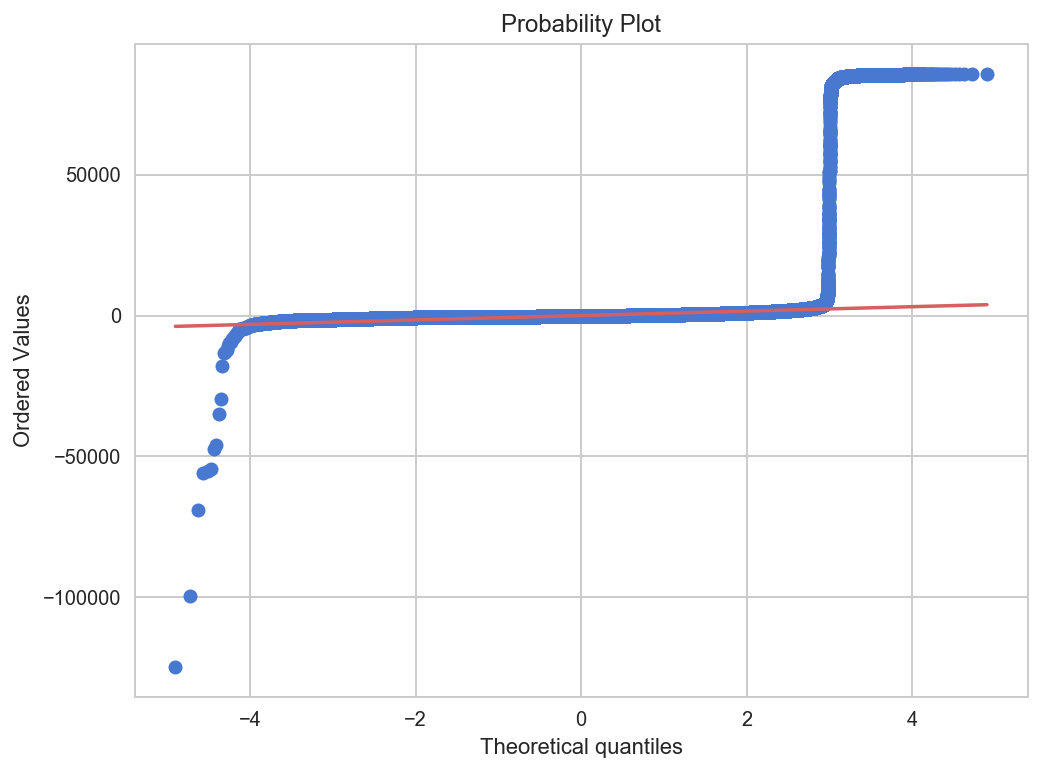

In [25]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [26]:
# Resid test1 
test_resid1 = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test_resid1):
    print("%-12s: %6.3f" % xi)

Chi^2       : 3542578.659
P-value     :  0.000


In [27]:
# Resid test2     
test_resid2 = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test_resid2):
    print("%-12s: %6.3f" % xi)

Jarque-Bera : 29873663873.675
P-value     :  0.000
Skew        : 25.984
Kurtosis    : 702.165


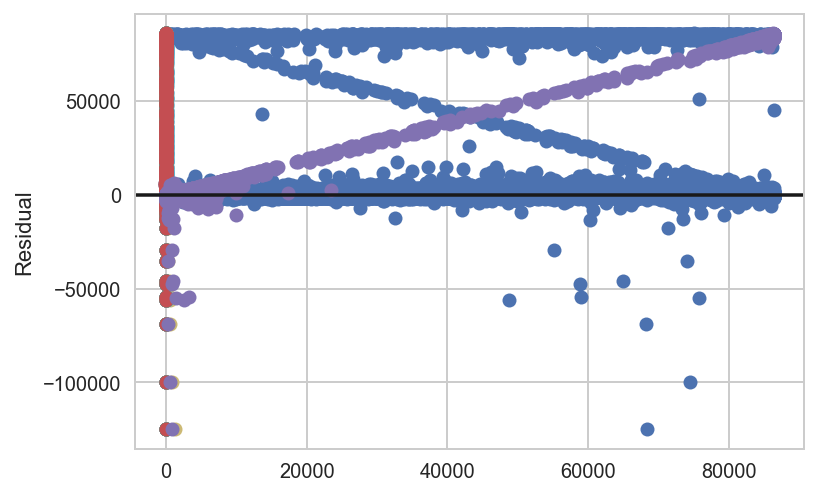

In [28]:
# x값에 따른 잔차의 분포 
plt.plot(taxi, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.ylabel("Residual")
plt.show()

### b. 변수별 잔차 정규성 검정

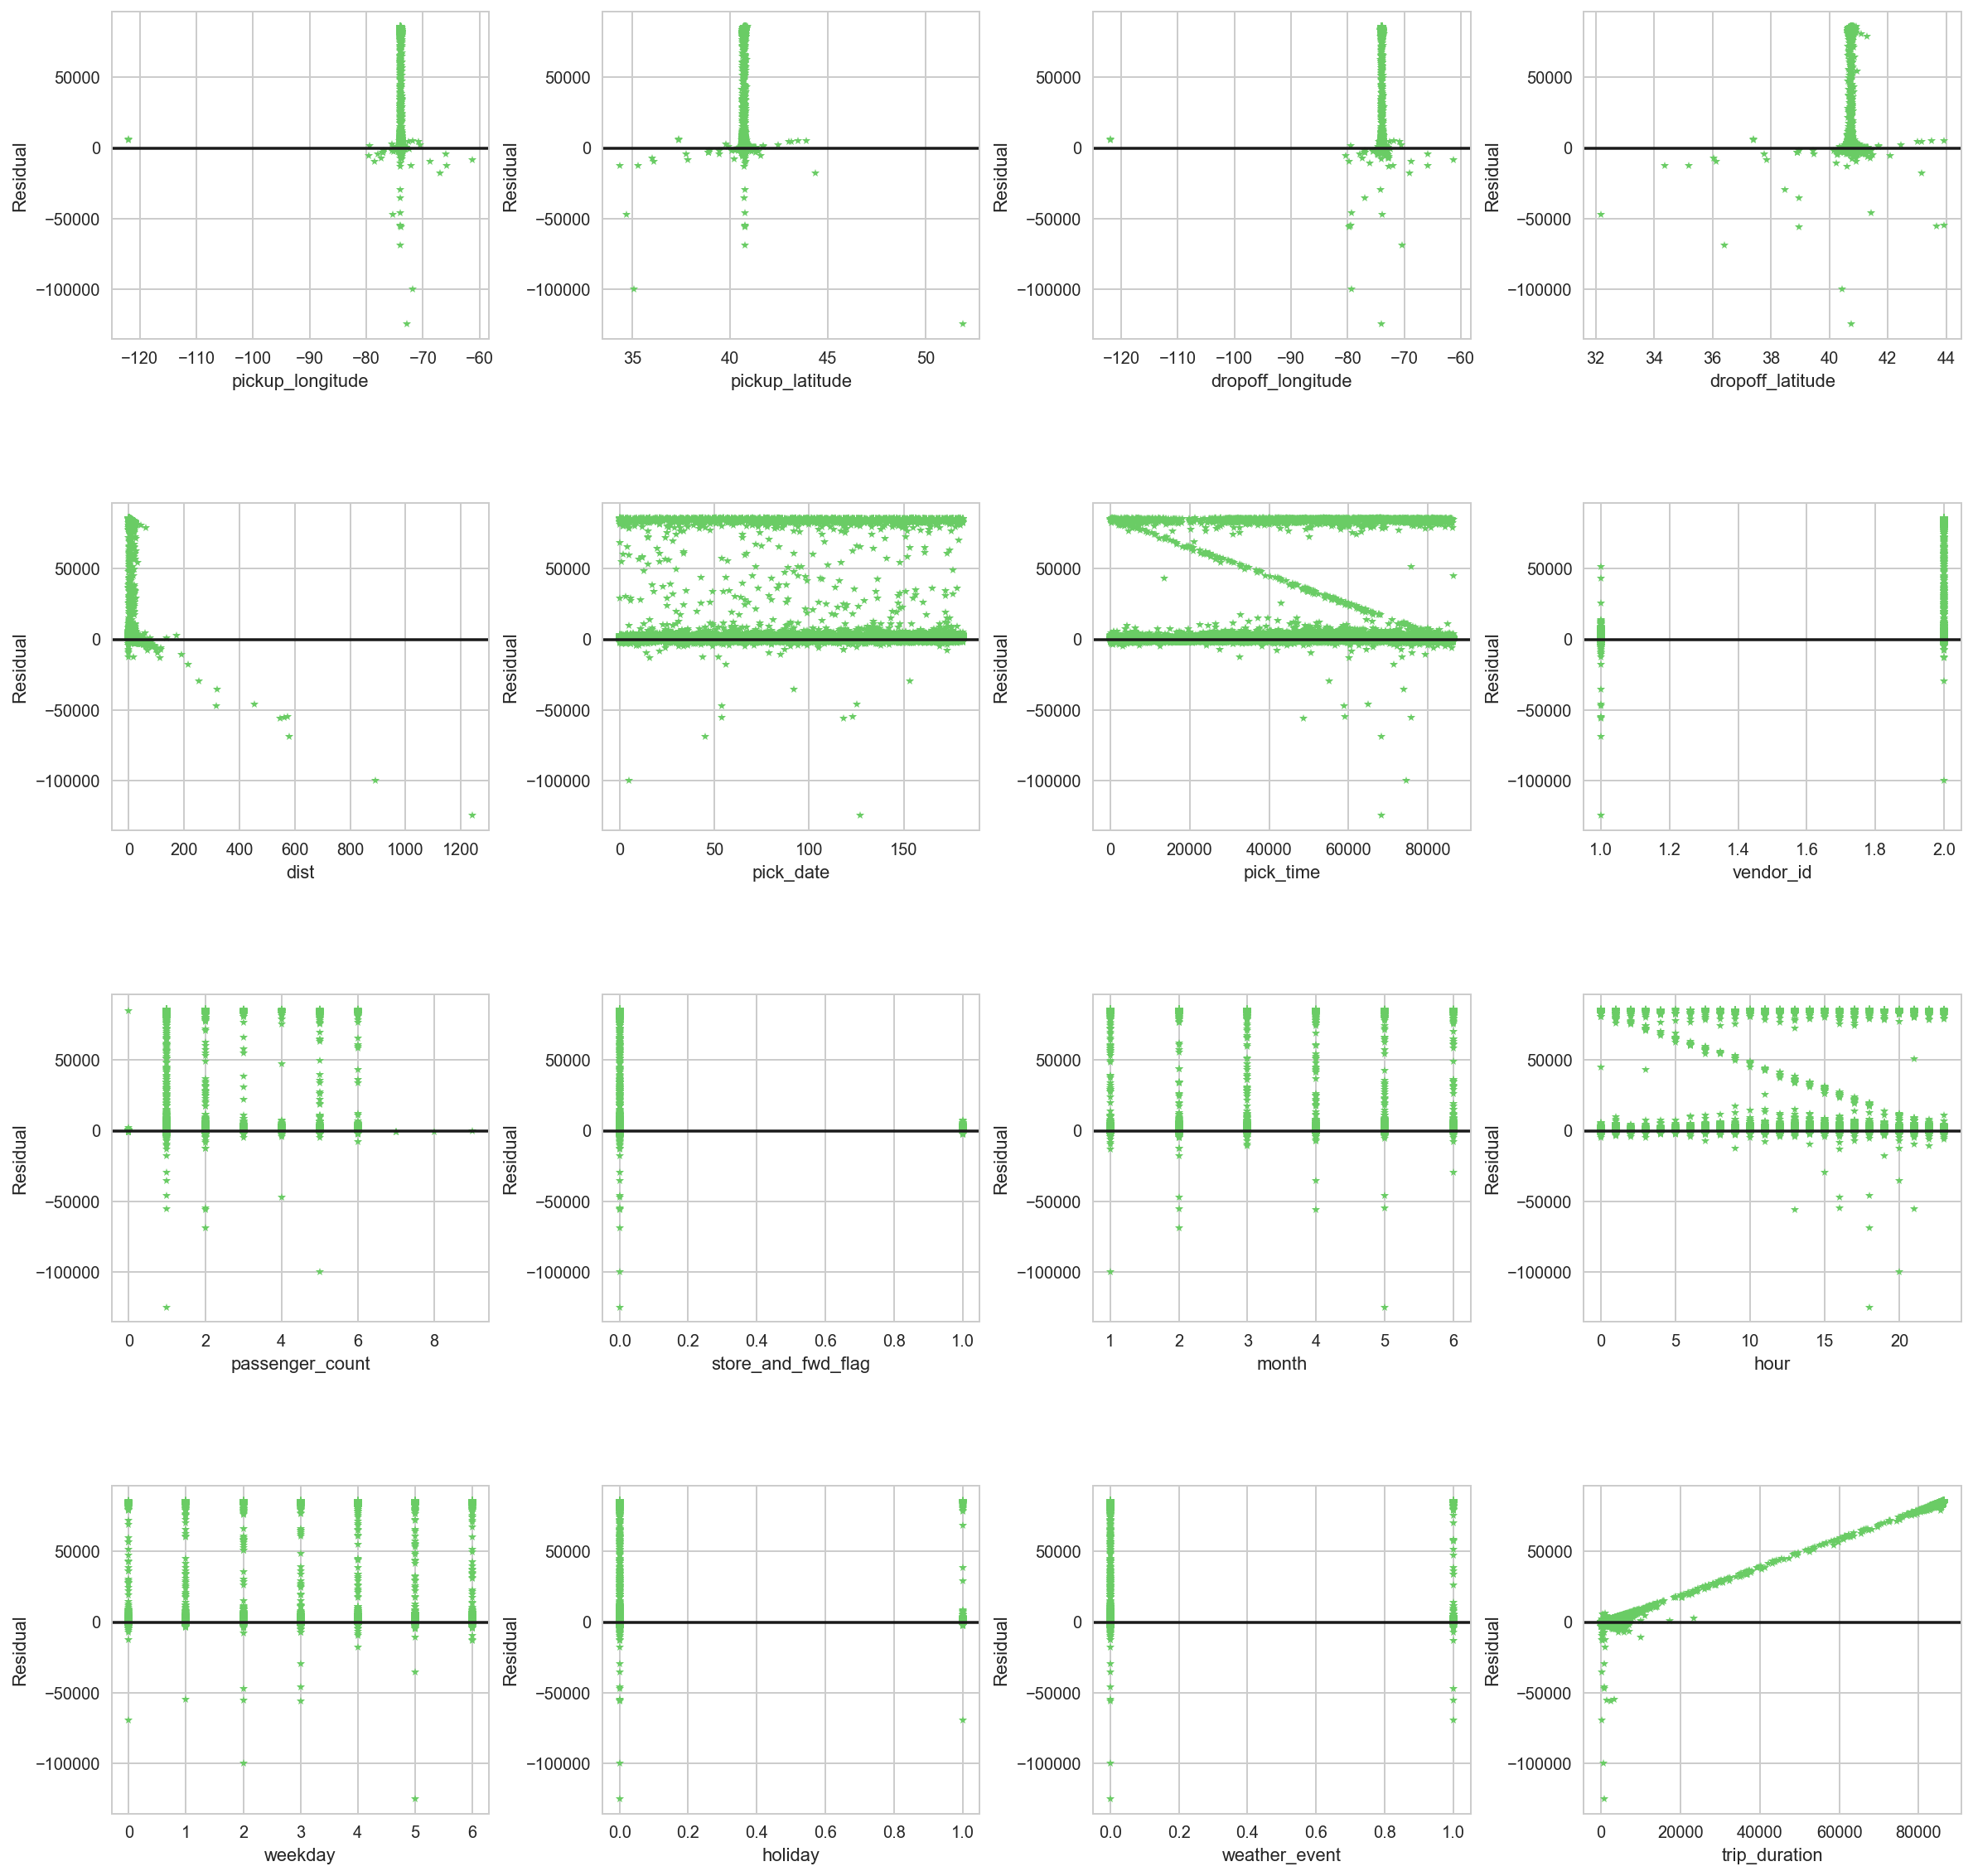

In [39]:
# plot (residual - feature)
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

# pickup_longitude
plt.subplot(4,4,1)
plt.plot(taxi['pickup_longitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pickup_longitude")
plt.ylabel("Residual")

# pickup_latitude
plt.subplot(4,4,2)
plt.plot(taxi['pickup_latitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pickup_latitude")
plt.ylabel("Residual")

# dropoff_longitude
plt.subplot(4,4,3)
plt.plot(taxi['dropoff_longitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dropoff_longitude")
plt.ylabel("Residual")

# dropoff_latitude
plt.subplot(4,4,4)
plt.plot(taxi['dropoff_latitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dropoff_latitude")
plt.ylabel("Residual")

# dist
plt.subplot(4,4,5)
plt.plot(taxi['dist'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dist")
plt.ylabel("Residual")

# pick_date
plt.subplot(4,4,6)
plt.plot(taxi['pick_date'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pick_date")
plt.ylabel("Residual")

# pick_time
plt.subplot(4,4,7)
plt.plot(taxi['pick_time'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pick_time")
plt.ylabel("Residual")

# vendor_id
plt.subplot(4,4,8)
plt.plot(taxi['vendor_id'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("vendor_id")
plt.ylabel("Residual")

# passenger_count 
plt.subplot(4,4,9) 
plt.plot(taxi['passenger_count'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("passenger_count")
plt.ylabel("Residual")

# store_and_fwd_flag
plt.subplot(4,4,10)
plt.plot(taxi['store_and_fwd_flag'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("store_and_fwd_flag")
plt.ylabel("Residual")

# month
plt.subplot(4,4,11)
plt.plot(taxi['month'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("month")
plt.ylabel("Residual")

# hour
plt.subplot(4,4,12)
plt.plot(taxi['hour'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("hour")
plt.ylabel("Residual")

# weekday
plt.subplot(4,4,13)
plt.plot(taxi['weekday'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("weekday")
plt.ylabel("Residual")

# holiday
plt.subplot(4,4,14)
plt.plot(taxi['holiday'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("holiday")
plt.ylabel("Residual")

# weather_event
plt.subplot(4,4,15)
plt.plot(taxi['weather_event'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("weather_event")
plt.ylabel("Residual")

# trip_duration
plt.subplot(4,4,16)
plt.plot(taxi['trip_duration'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("trip_duration")
plt.ylabel("Residual")

plt.show()

## B. 이분산 검정

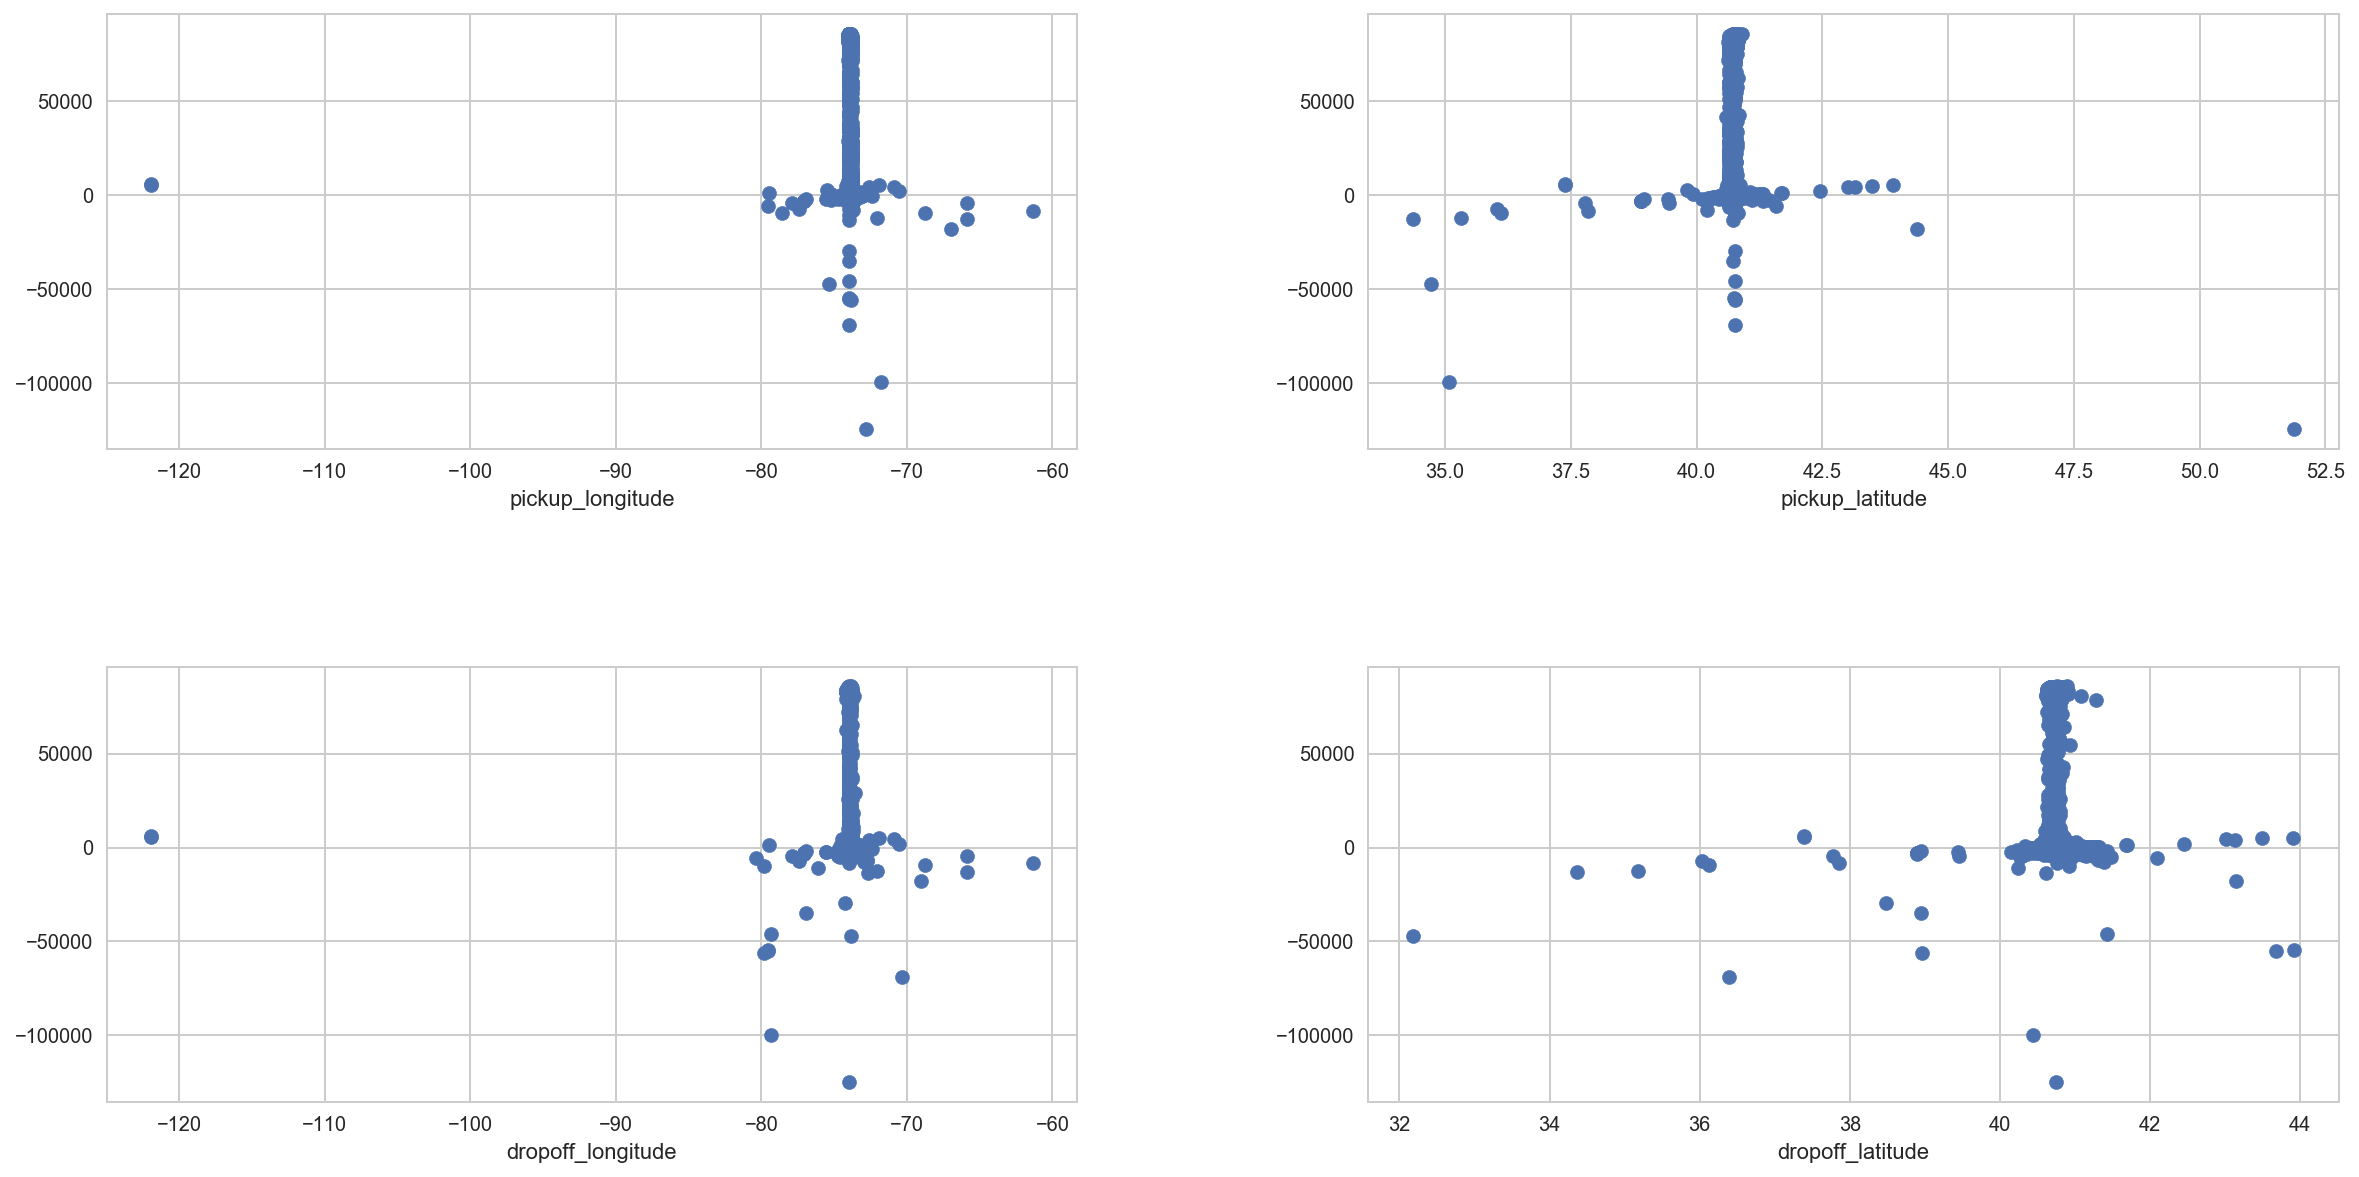

In [61]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.xlabel("pickup_longitude")
plt.scatter(taxi['pickup_longitude'], result.resid)

plt.subplot(222)
plt.xlabel("pickup_latitude")
plt.scatter(taxi['pickup_latitude'], result.resid)

plt.subplot(223)
plt.xlabel("dropoff_longitude")
plt.scatter(taxi['dropoff_longitude'], result.resid)

plt.subplot(224)
plt.xlabel("dropoff_latitude")
plt.scatter(taxi['dropoff_latitude'], result.resid)

plt.show()

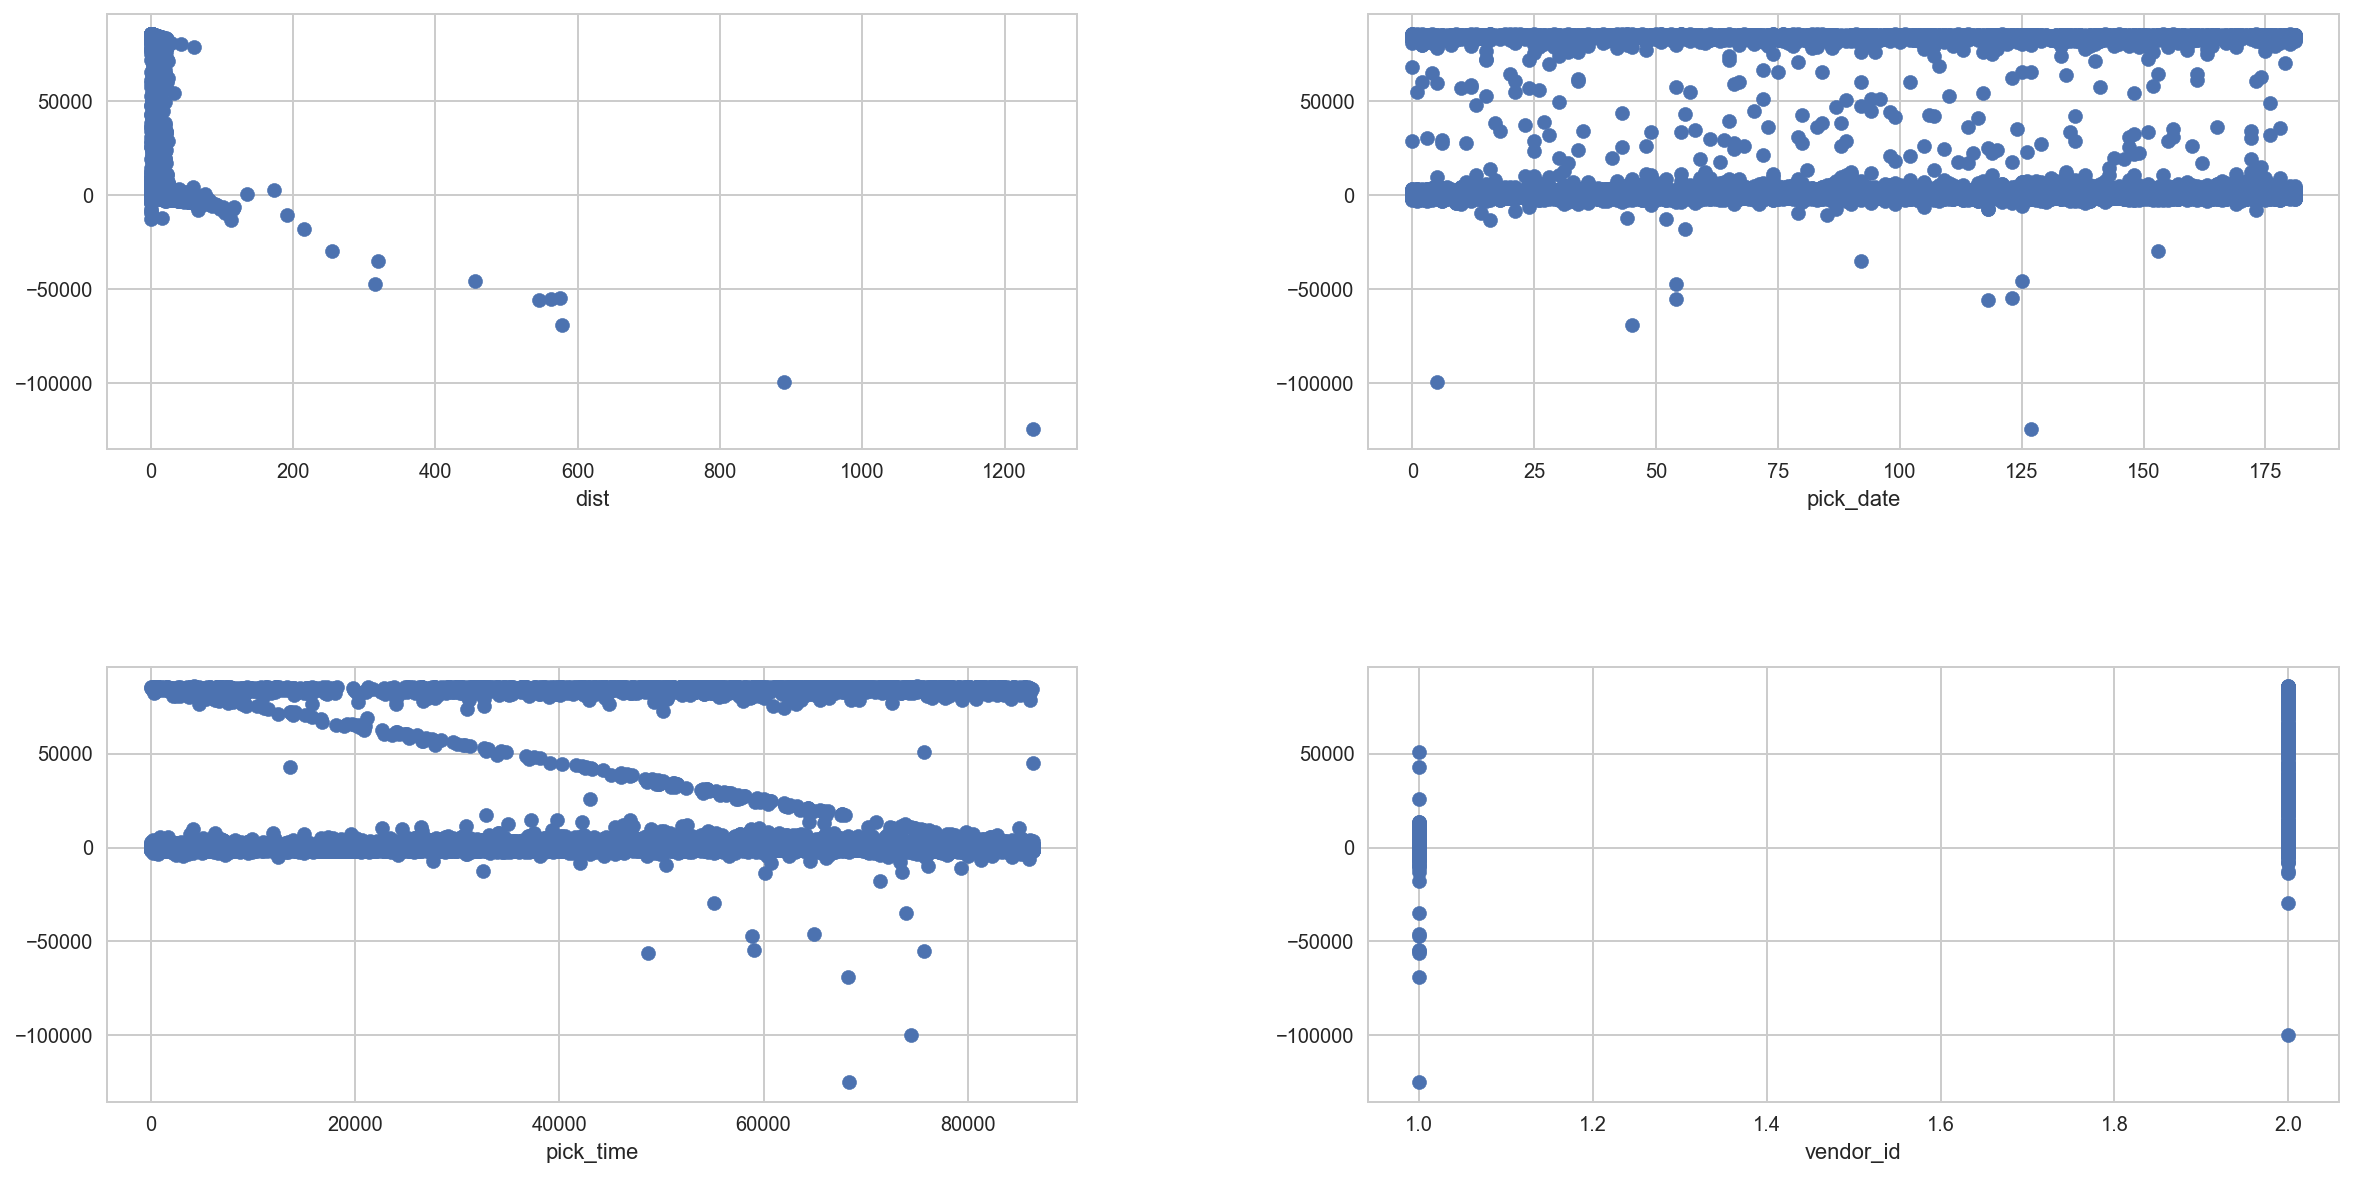

In [60]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
  
plt.subplot(221)
plt.xlabel("dist")
plt.scatter(taxi['dist'], result.resid)

plt.subplot(222)
plt.xlabel("pick_date")
plt.scatter(taxi['pick_date'], result.resid)

plt.subplot(223)
plt.xlabel("pick_time")
plt.scatter(taxi['pick_time'], result.resid)

plt.subplot(224)
plt.xlabel("vendor_id")
plt.scatter(taxi['vendor_id'], result.resid)

plt.show()

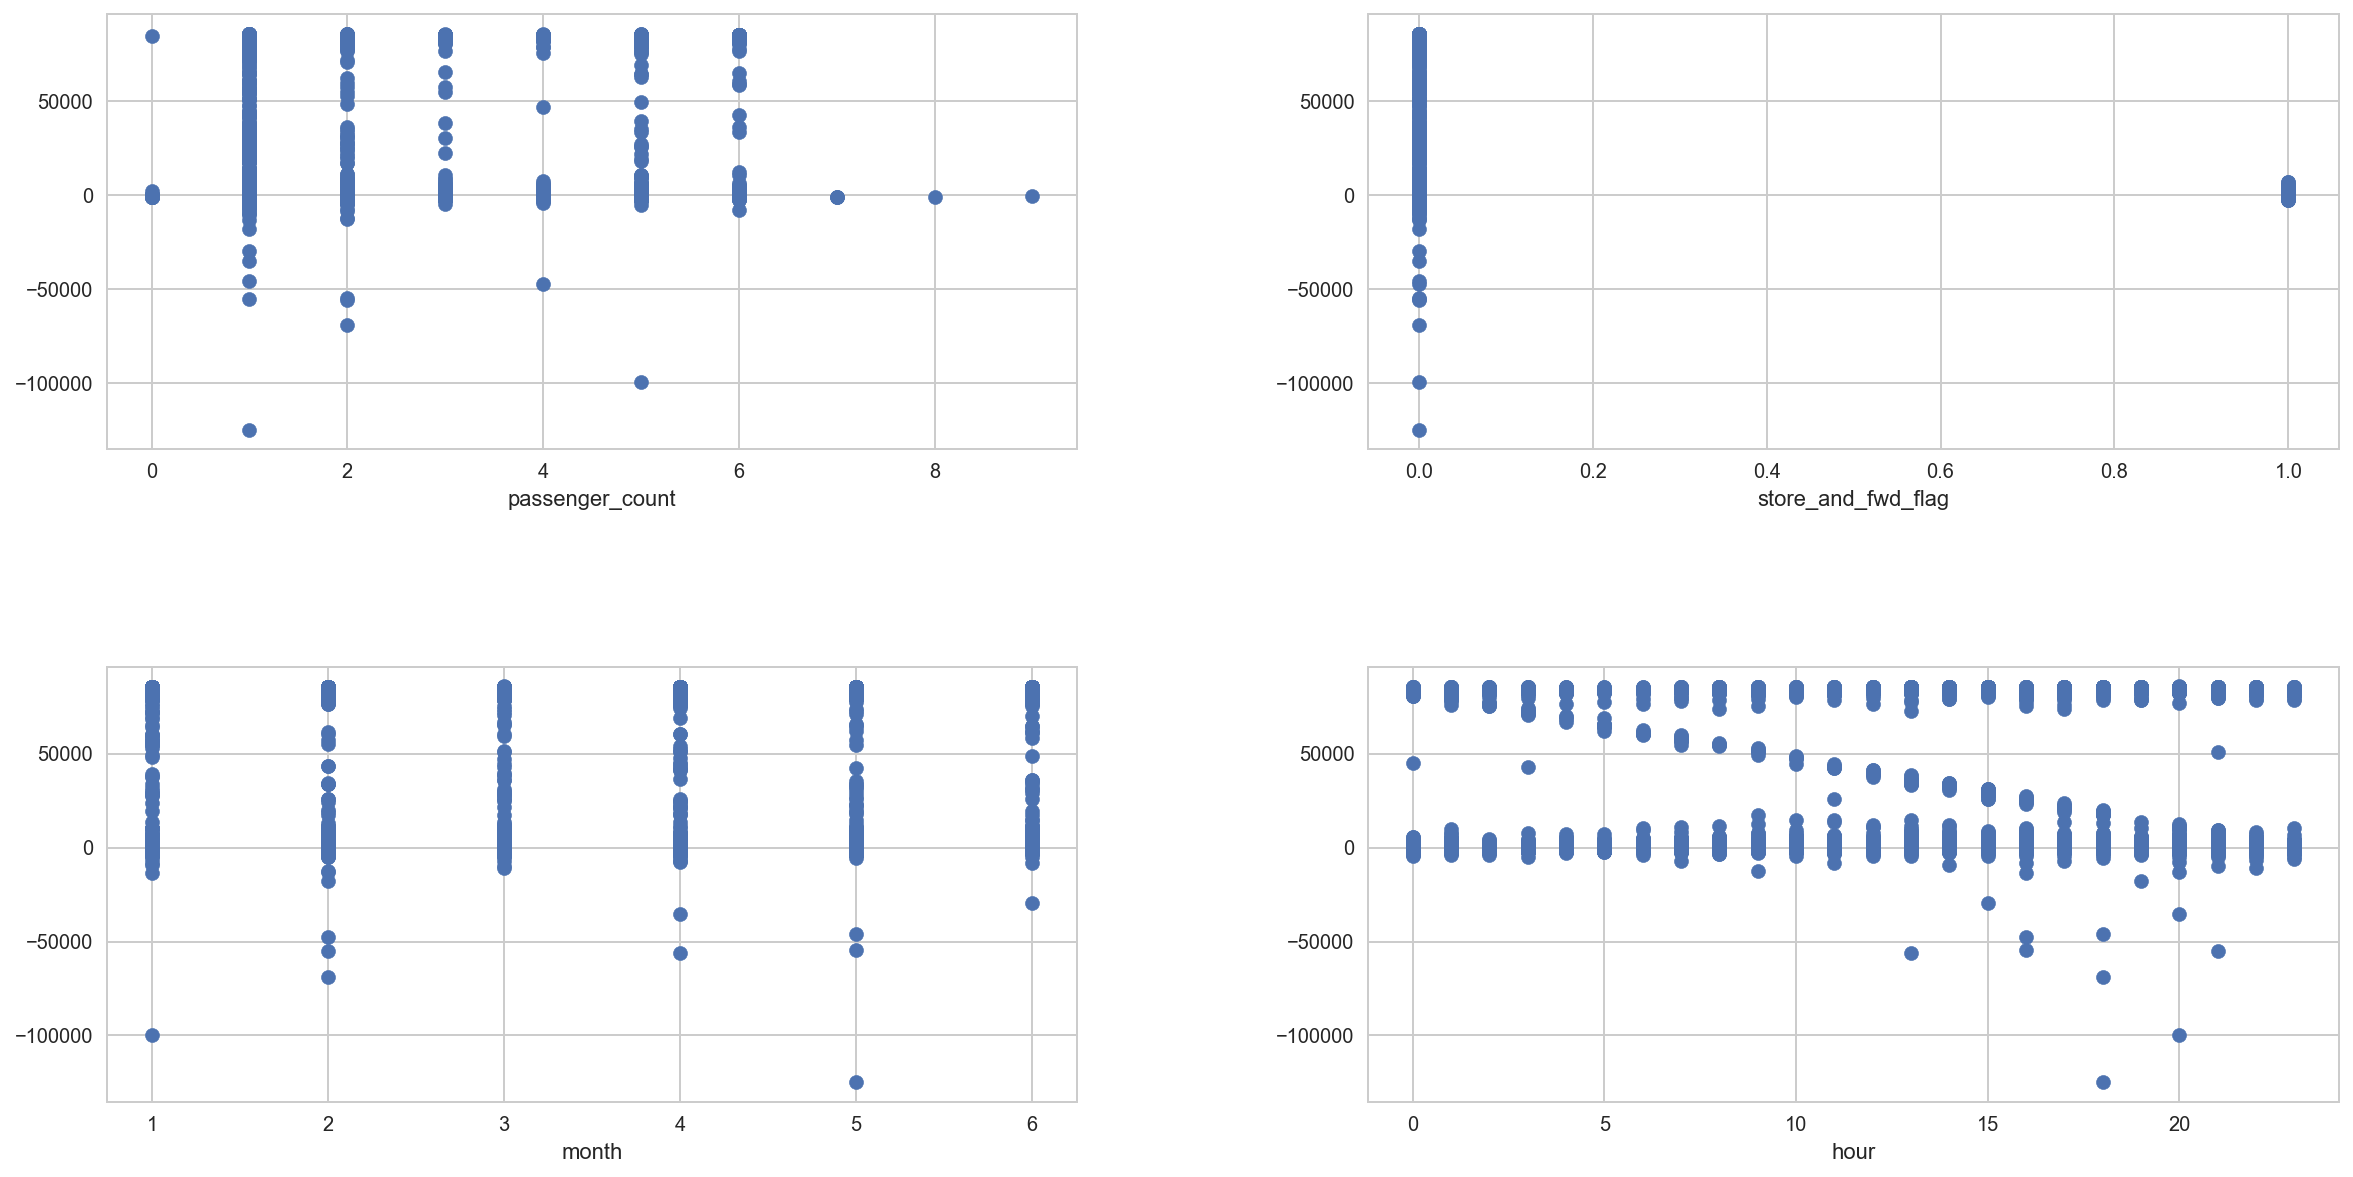

In [62]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
   
plt.subplot(221)
plt.xlabel("passenger_count")
plt.scatter(taxi['passenger_count'], result.resid)

plt.subplot(222)
plt.xlabel("store_and_fwd_flag")
plt.scatter(taxi['store_and_fwd_flag'], result.resid)

plt.subplot(223)
plt.xlabel("month")
plt.scatter(taxi['month'], result.resid)

plt.subplot(224)
plt.xlabel("hour")
plt.scatter(taxi['hour'], result.resid)

plt.show()

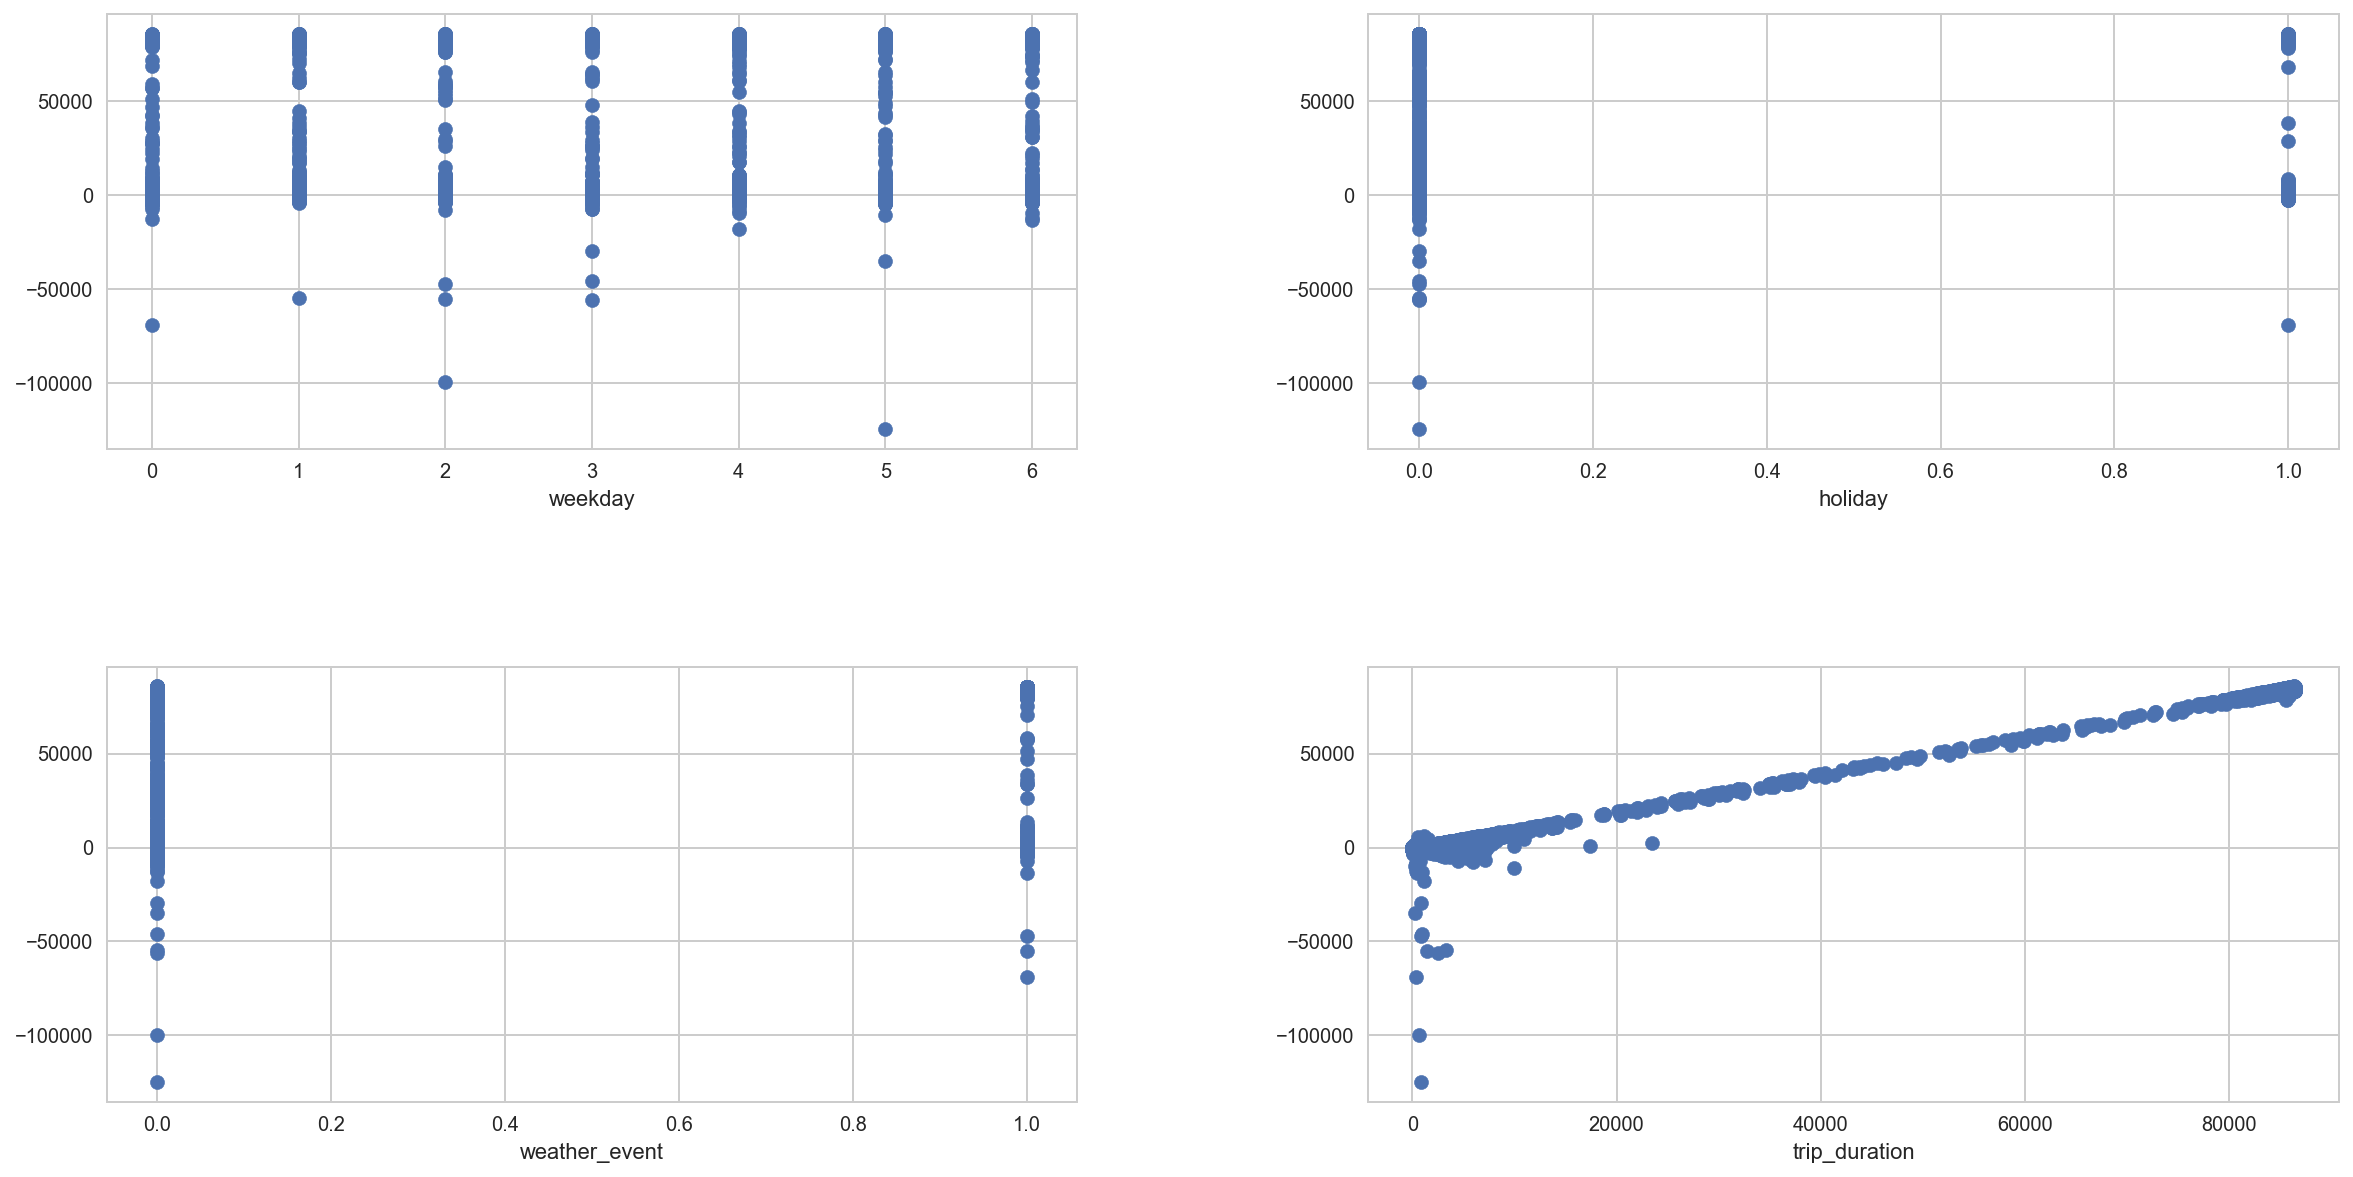

In [63]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.xlabel("weekday")
plt.scatter(taxi['weekday'], result.resid)

plt.subplot(222)
plt.xlabel("holiday")
plt.scatter(taxi['holiday'], result.resid)

plt.subplot(223)
plt.xlabel("weather_event")
plt.scatter(taxi['weather_event'], result.resid)

plt.subplot(224)
plt.xlabel("trip_duration")
plt.scatter(taxi['trip_duration'], result.resid)

plt.show()

## C. 자기상관 검정

####  Durbin-Watson 검정

In [46]:
# 값이 2 -> 무상관
durbin_watson(result.wresid)

2.0001604675420044

## D. Target-feature check

### a. partial regression 

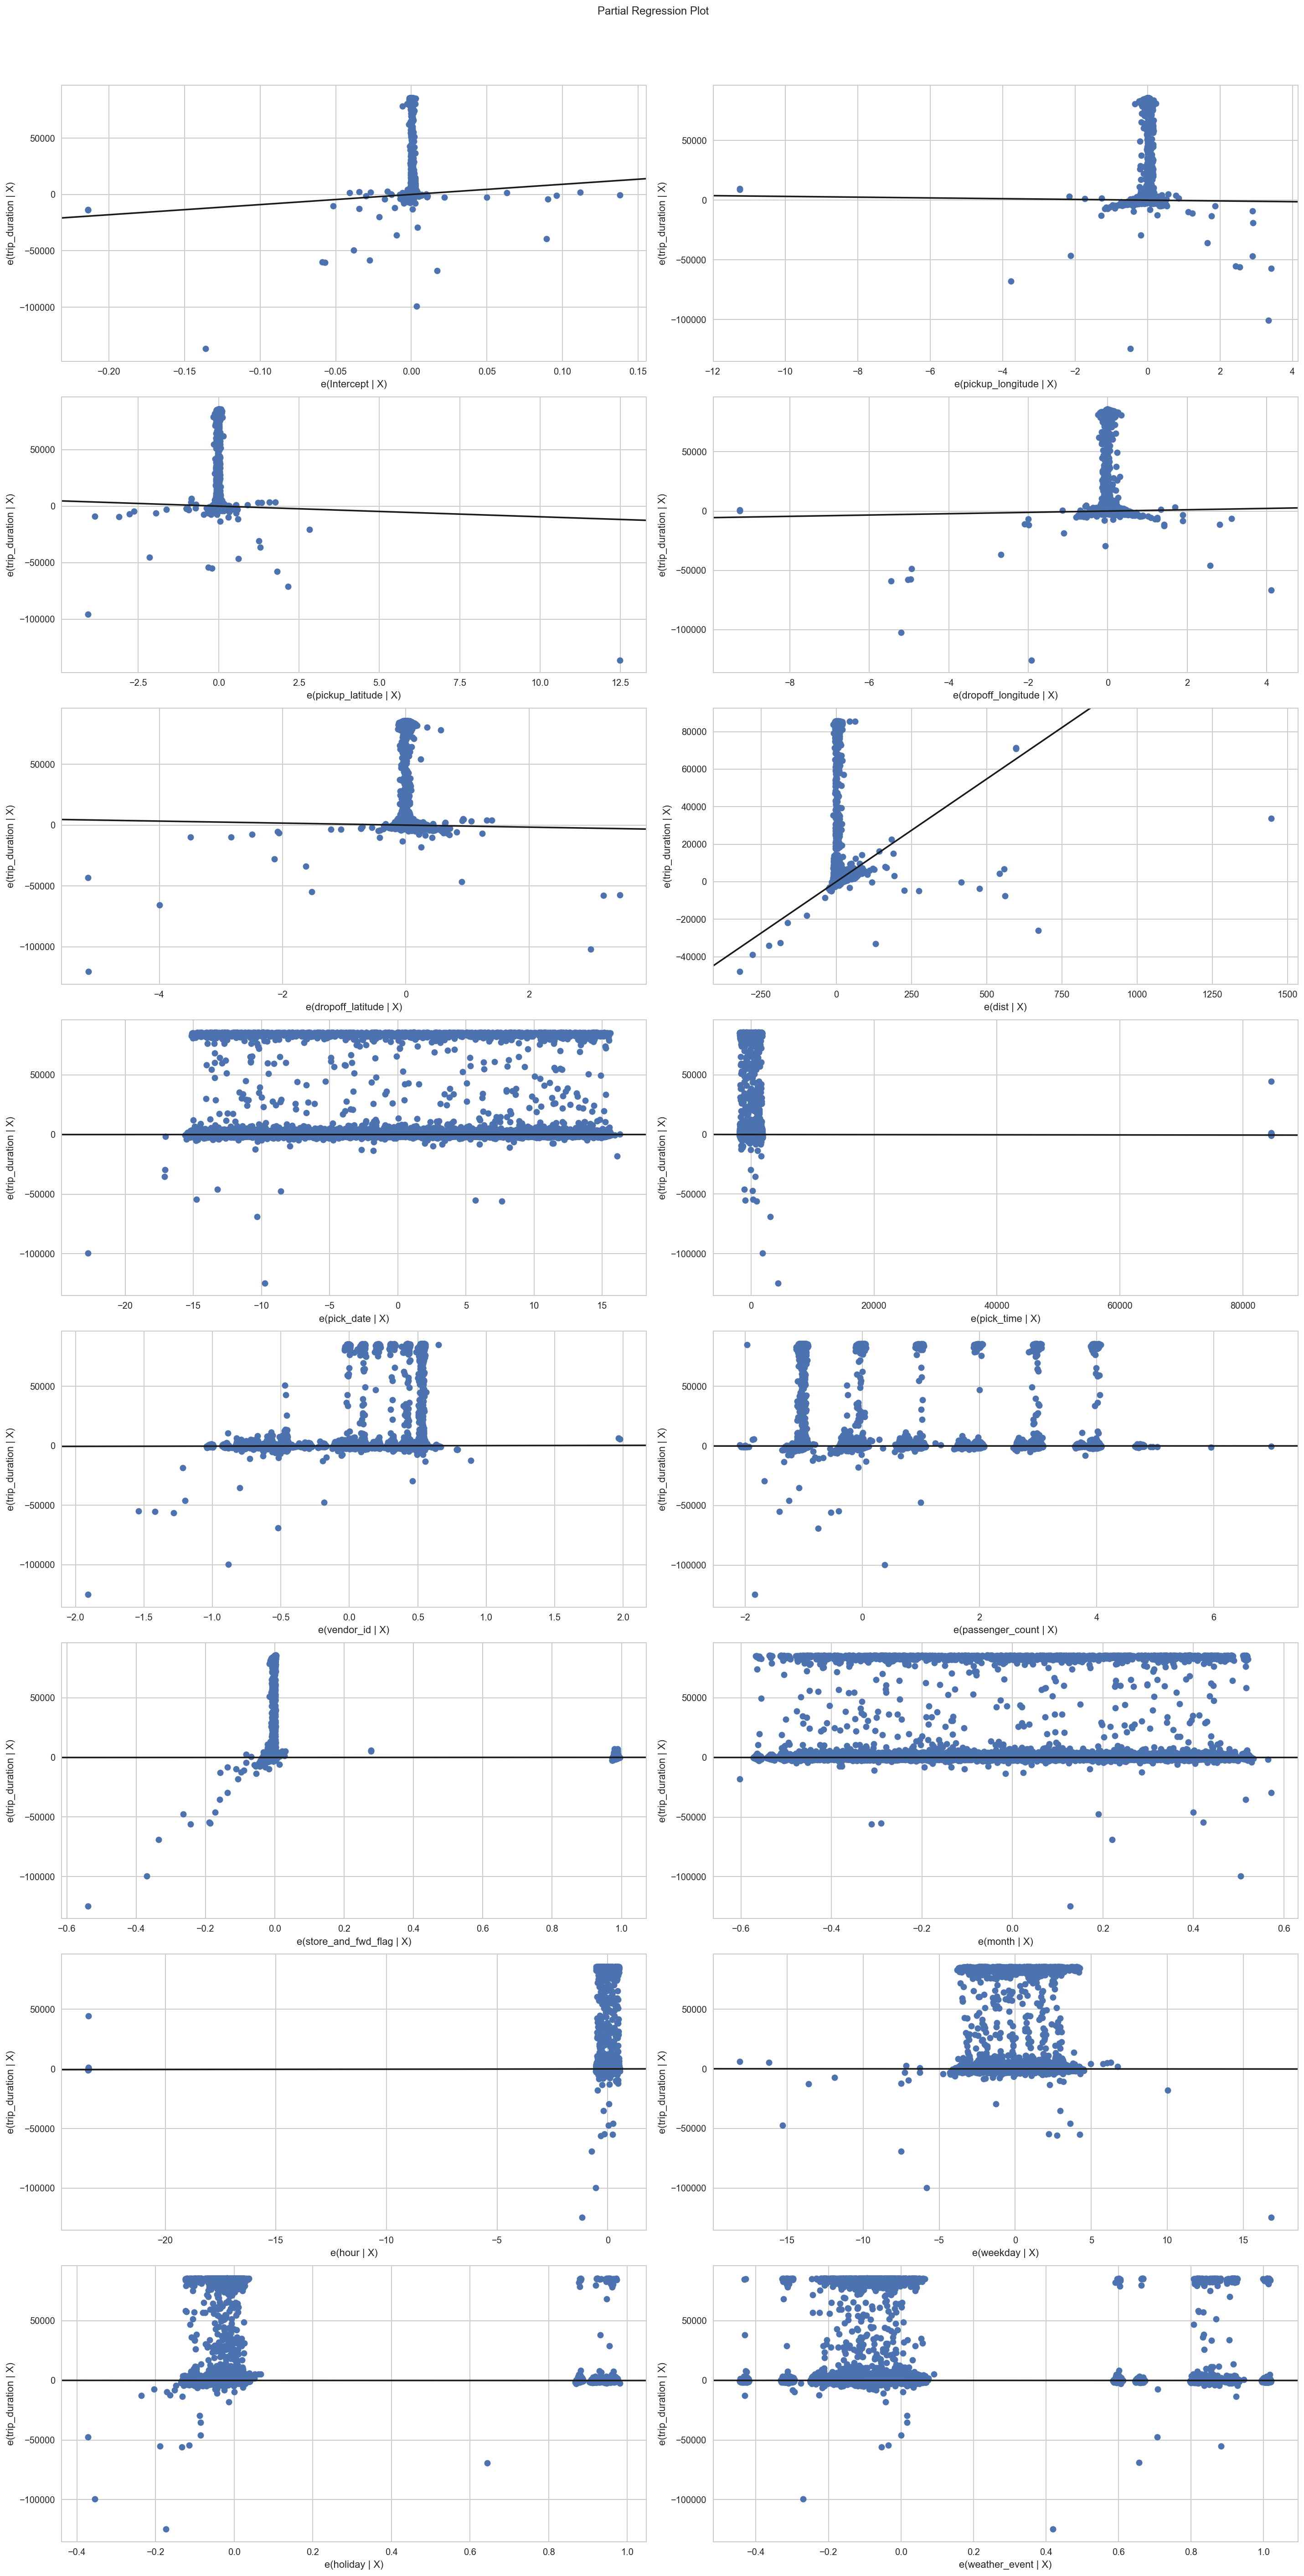

In [47]:
fig = plt.figure(figsize=(20, 40))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

### b. ccpr

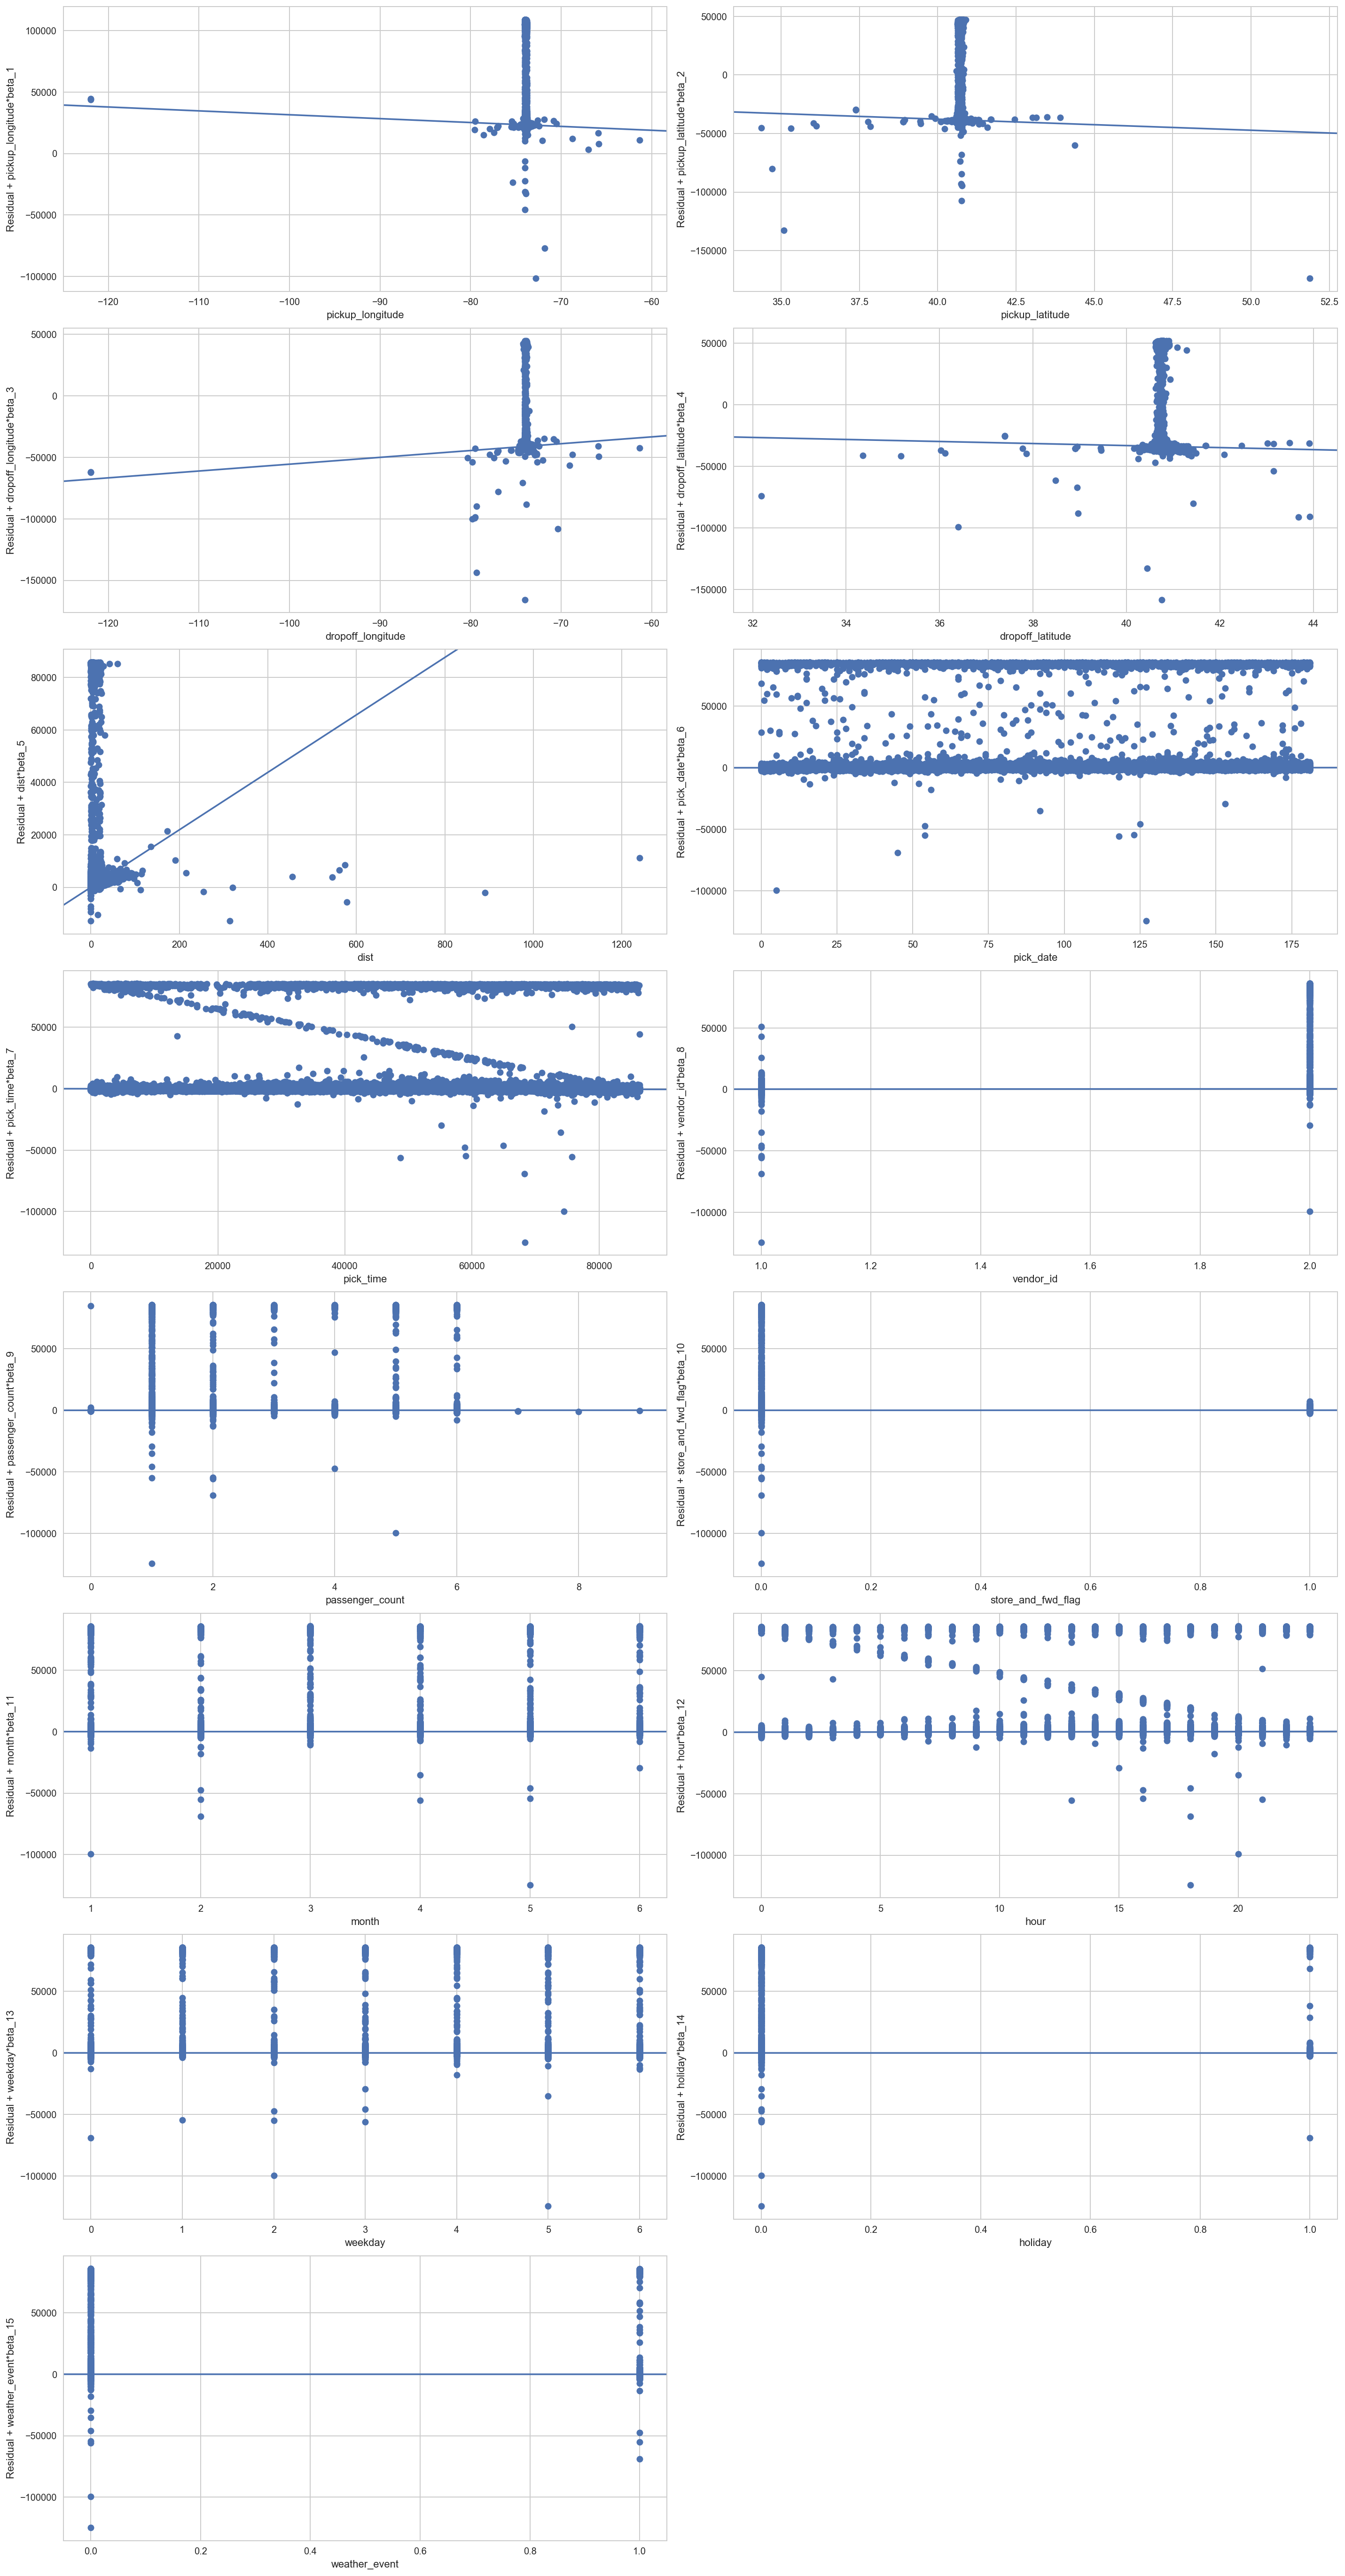

In [64]:
fig = plt.figure(figsize=(20, 40))
sm.graphics.plot_ccpr_grid(result, fig=fig) 
fig.suptitle("")
plt.show()

---

# 3. Optimal regulize

각 컬럼별 최적 정규화
- 의미가 없는 경우 제거

1. id
1. vendor_id
1. passenger_count
1. store_and_fwd_flag
1. locations
1. dist
1. pick_date
1. pick_time
1. weekday
1. holiday


---

## 3.1 Leverage (레버리지)

In [14]:
# (시간이 걸려서 일단 패스)
# influence = result.get_influence()
# hat = influence.hat_matrix_diag

# plt.figure(figsize = (10, 2))
# plt.stem(hat)
# plt.show()

## 3.2 Outlier (아웃라이어)

In [16]:
taxi_2, drop = erase_outlier_np(result_1, taxi_1, feature_n, dropped=True)
len(taxi_1), len(drop)

(1458644, 2318)

In [17]:
feature_n_2, features_2 = get_features(taxi_1, 1, -1)
feature_n_2, features_2

(14,
 'id + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + drop_time + weekday + holiday + vendor_id + passenger_count + store_and_fwd_flag')

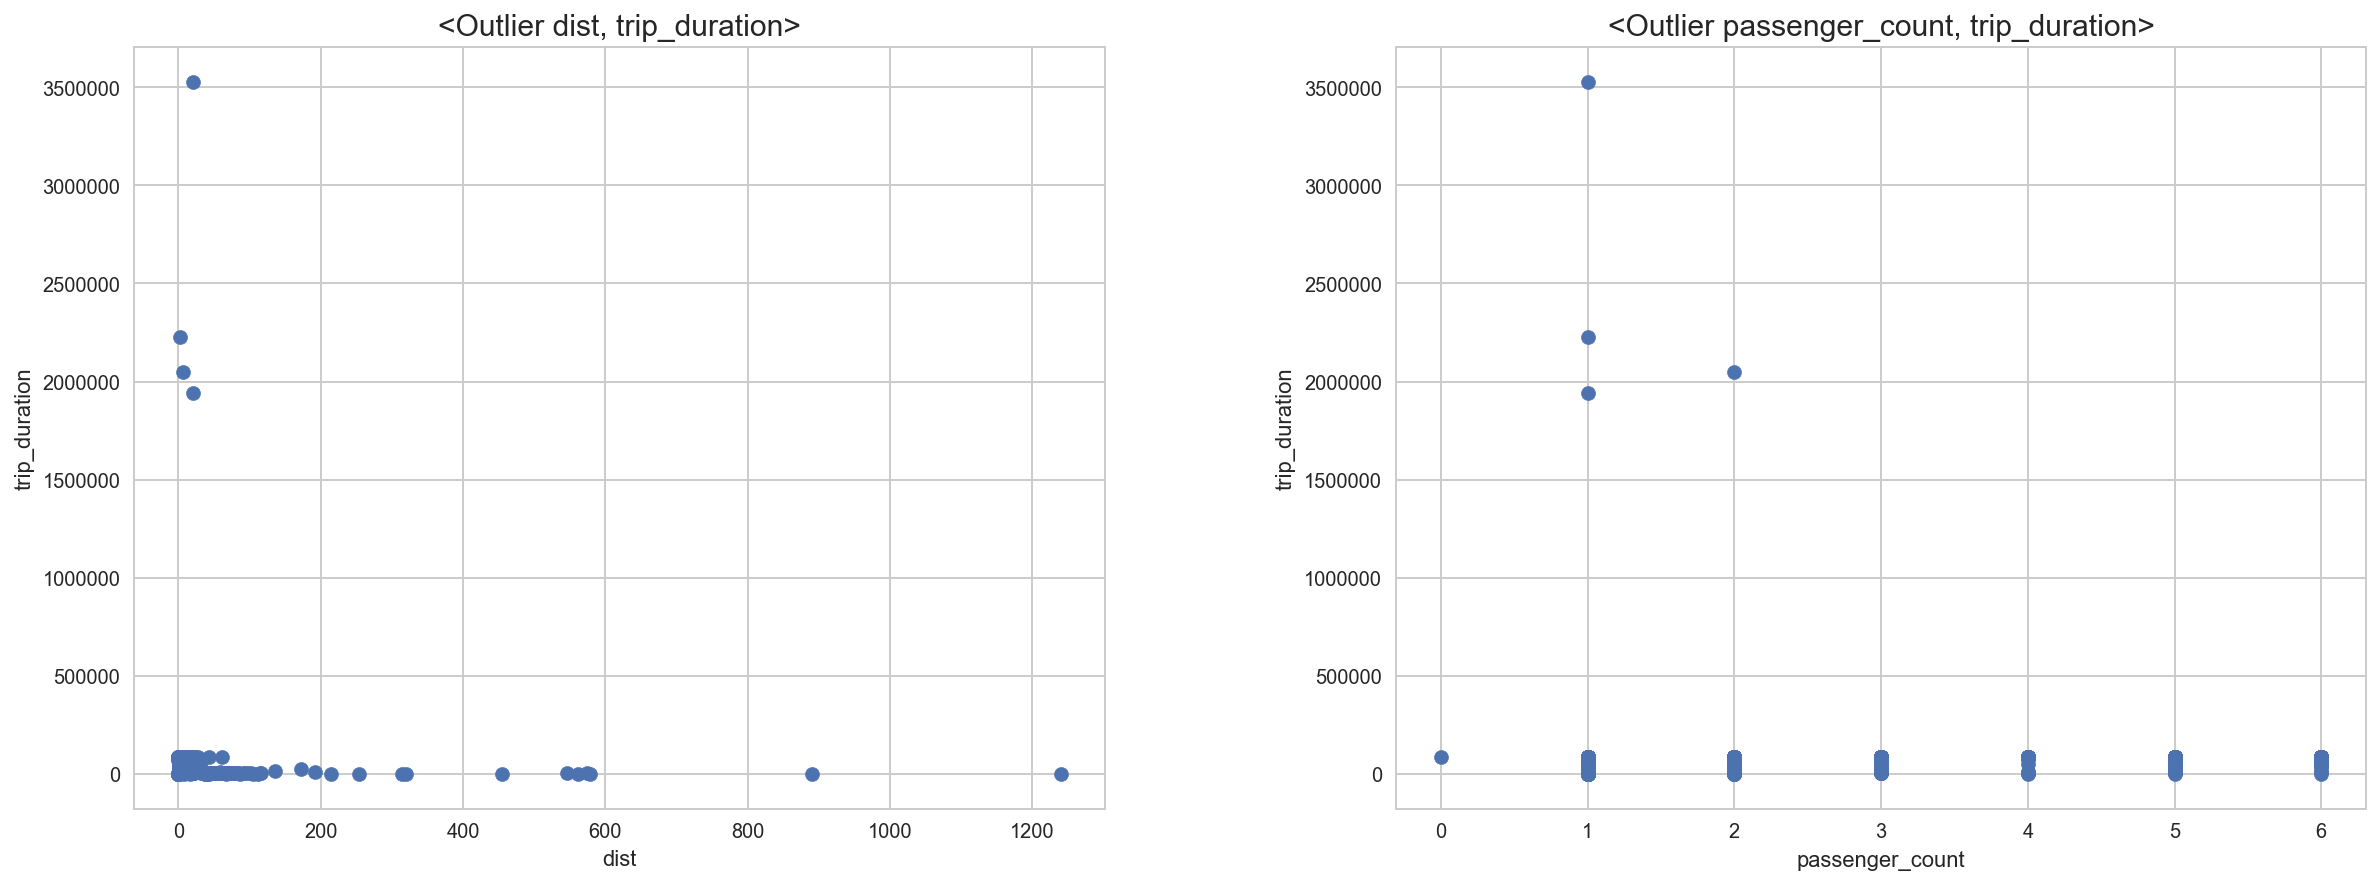

In [18]:
# Outlier
plt.figure(figsize = (20, 7))
plt.subplots_adjust(wspace = 0.3)

# outlier 제거 확인 (dist, trip_duration)
plt.subplot(121)
plt.scatter(drop['dist'], drop['trip_duration'])
plt.title('<Outlier dist, trip_duration>', fontsize = 15)
plt.xlabel('dist')
plt.ylabel('trip_duration')

# outlier 제거 확인 (passenger_count, trip_duration)
plt.subplot(122)
plt.scatter(drop['passenger_count'], drop['trip_duration'])
plt.title('<Outlier passenger_count, trip_duration>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('trip_duration')

plt.show()

In [19]:
# 제거 후 결과
model_2 =  sm.OLS.from_formula("trip_duration ~ {}".format(features_1), data = taxi_2)
result_2 = model_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.610e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:42:46   Log-Likelihood:            -1.0833e+07
No. Observations:             1456326   AIC:                         2.167e+07
Df Residuals:                 1456311   BIC:                         2.167e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -9.844e+04   1292.164    -76.182      0.000   -1.01e+05   -9.59e+04
id                  6.053e-07   2.95e-07      2.050      0.040    2.65e-08    1.18e-06
pickup_longitude    -558.1743     10.494    -53.188      0.000    -578.743    -537.606
pickup_latitude     1017.6884     14.099     72.183      0.000     990.055    1045.322
dropoff_longitude   -934.2945     10.458    -89.337      0.000    -954.792    -913.797
dropoff_latitude   -1301.1687     11.931   -109.059      0.000   -1324.553   -1277.785
dist                 135.7249      0.112   1217.121      0.000     135.506     135.943
pick_date              0.5475      0.007     81.937      0.000       0.534       0.561
pick_time             -0.0016    4.1e-05    -38.693      0.000      -0.002      -0.002
drop_time              0.0029   4.05e-05     70.701      0.000       0.003       0.003
weekday              -13.4496      0.177    -76.195      0.000     -13.796     -13.104
holiday             -105.0081      2.222    -47.260      0.000    -109.363    -100.653
vendor_id              0.8521      0.716      1.190      0.234      -0.551       2.255
passenger_count        3.4683      0.271     12.791      0.000       2.937       4.000
store_and_fwd_flag    34.3560      4.627      7.426      0.000      25.288      43.424
==============================================================================
Omnibus:                   782315.469   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21436280.680
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      21.342   Cond. No.                     8.75e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.3 Scaling (스케일링)

In [20]:
# Scaling을 위한 데이터 setting
taxi_3 = taxi_2
taxi_3.tail()

Intercept         id  pickup_longitude  pickup_latitude  \
1456321       1.00 2376096.00            -73.98            40.75   
1456322       1.00 1049543.00            -74.00            40.75   
1456323       1.00 2304944.00            -73.96            40.77   
1456324       1.00 2714485.00            -73.98            40.75   
1456325       1.00 1209952.00            -73.98            40.78   

         dropoff_longitude  dropoff_latitude  dist  pick_date  pick_time  \
1456321             -73.99             40.74  1.22      98.00   48663.00   
1456322             -73.97             40.80  6.05       9.00   27314.00   
1456323             -74.00             40.71  7.82     112.00   25060.00   
1456324             -73.97             40.76  1.09       4.00   57385.00   
1456325             -73.97             40.79  1.13      95.00   53064.00   

         drop_time  weekday  holiday  vendor_id  passenger_count  \
1456321   49441.00     5.00     1.00       2.00             4.00   
1456322   27969.00     7.00     1.00       1.00             1.00   
1456323   25824.00     5.00     1.00       2.00             1.00   
1456324   57758.00     2.00     1.00       1.00             1.00   
1456325   53262.00     2.00     1.00       1.00             1.00   

         store_and_fwd_flag  trip_duration  
1456321                0.00         778.00  
1456322                0.00         655.00  
1456323                0.00         764.00  
1456324                0.00         373.00  
1456325                0.00         198.00

In [21]:
# Scale 부여
feature_n_3, features_3 = get_features(taxi_3, 1, -1, scale = True)
feature_n_3, features_3

(14,
 'scale(id) + scale(pickup_longitude) + scale(pickup_latitude) + scale(dropoff_longitude) + scale(dropoff_latitude) + scale(dist) + scale(pick_date) + scale(pick_time) + scale(drop_time) + scale(weekday) + scale(holiday) + scale(vendor_id) + scale(passenger_count) + scale(store_and_fwd_flag)')

In [22]:
# Scale data summary
model_3 =  sm.OLS.from_formula("trip_duration ~ {} ".format(features_3), data = taxi_3)
result_3 = model_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.610e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:47:01   Log-Likelihood:            -1.0833e+07
No. Observations:             1456326   AIC:                         2.167e+07
Df Residuals:                 1456311   BIC:                         2.167e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   836.3487      0.341   2452.675      0.000     835.680     837.017
scale(id)                     0.6989      0.341      2.050      0.040       0.031       1.367
scale(pickup_longitude)     -21.4611      0.403    -53.188      0.000     -22.252     -20.670
scale(pickup_latitude)       28.6855      0.397     72.183      0.000      27.907      29.464
scale(dropoff_longitude)    -33.7539      0.378    -89.337      0.000     -34.494     -33.013
scale(dropoff_latitude)     -42.1093      0.386   -109.059      0.000     -42.866     -41.352
scale(dist)                 531.1975      0.436   1217.121      0.000     530.342     532.053
scale(pick_date)             28.2329      0.345     81.937      0.000      27.558      28.908
scale(pick_time)            -36.5392      0.944    -38.693      0.000     -38.390     -34.688
scale(drop_time)             66.8134      0.945     70.701      0.000      64.961      68.666
scale(weekday)              -26.2805      0.345    -76.195      0.000     -26.957     -25.604
scale(holiday)              -16.3706      0.346    -47.260      0.000     -17.050     -15.692
scale(vendor_id)              0.4250      0.357      1.190      0.234      -0.275       1.125
scale(passenger_count)        4.5561      0.356     12.791      0.000       3.858       5.254
scale(store_and_fwd_flag)     2.5416      0.342      7.426      0.000       1.871       3.212
==============================================================================
Omnibus:                   782315.469   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21436280.680
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      21.342   Cond. No.                         5.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.4 변수변환

## 3.5 Multicollinearity (다중공선성)

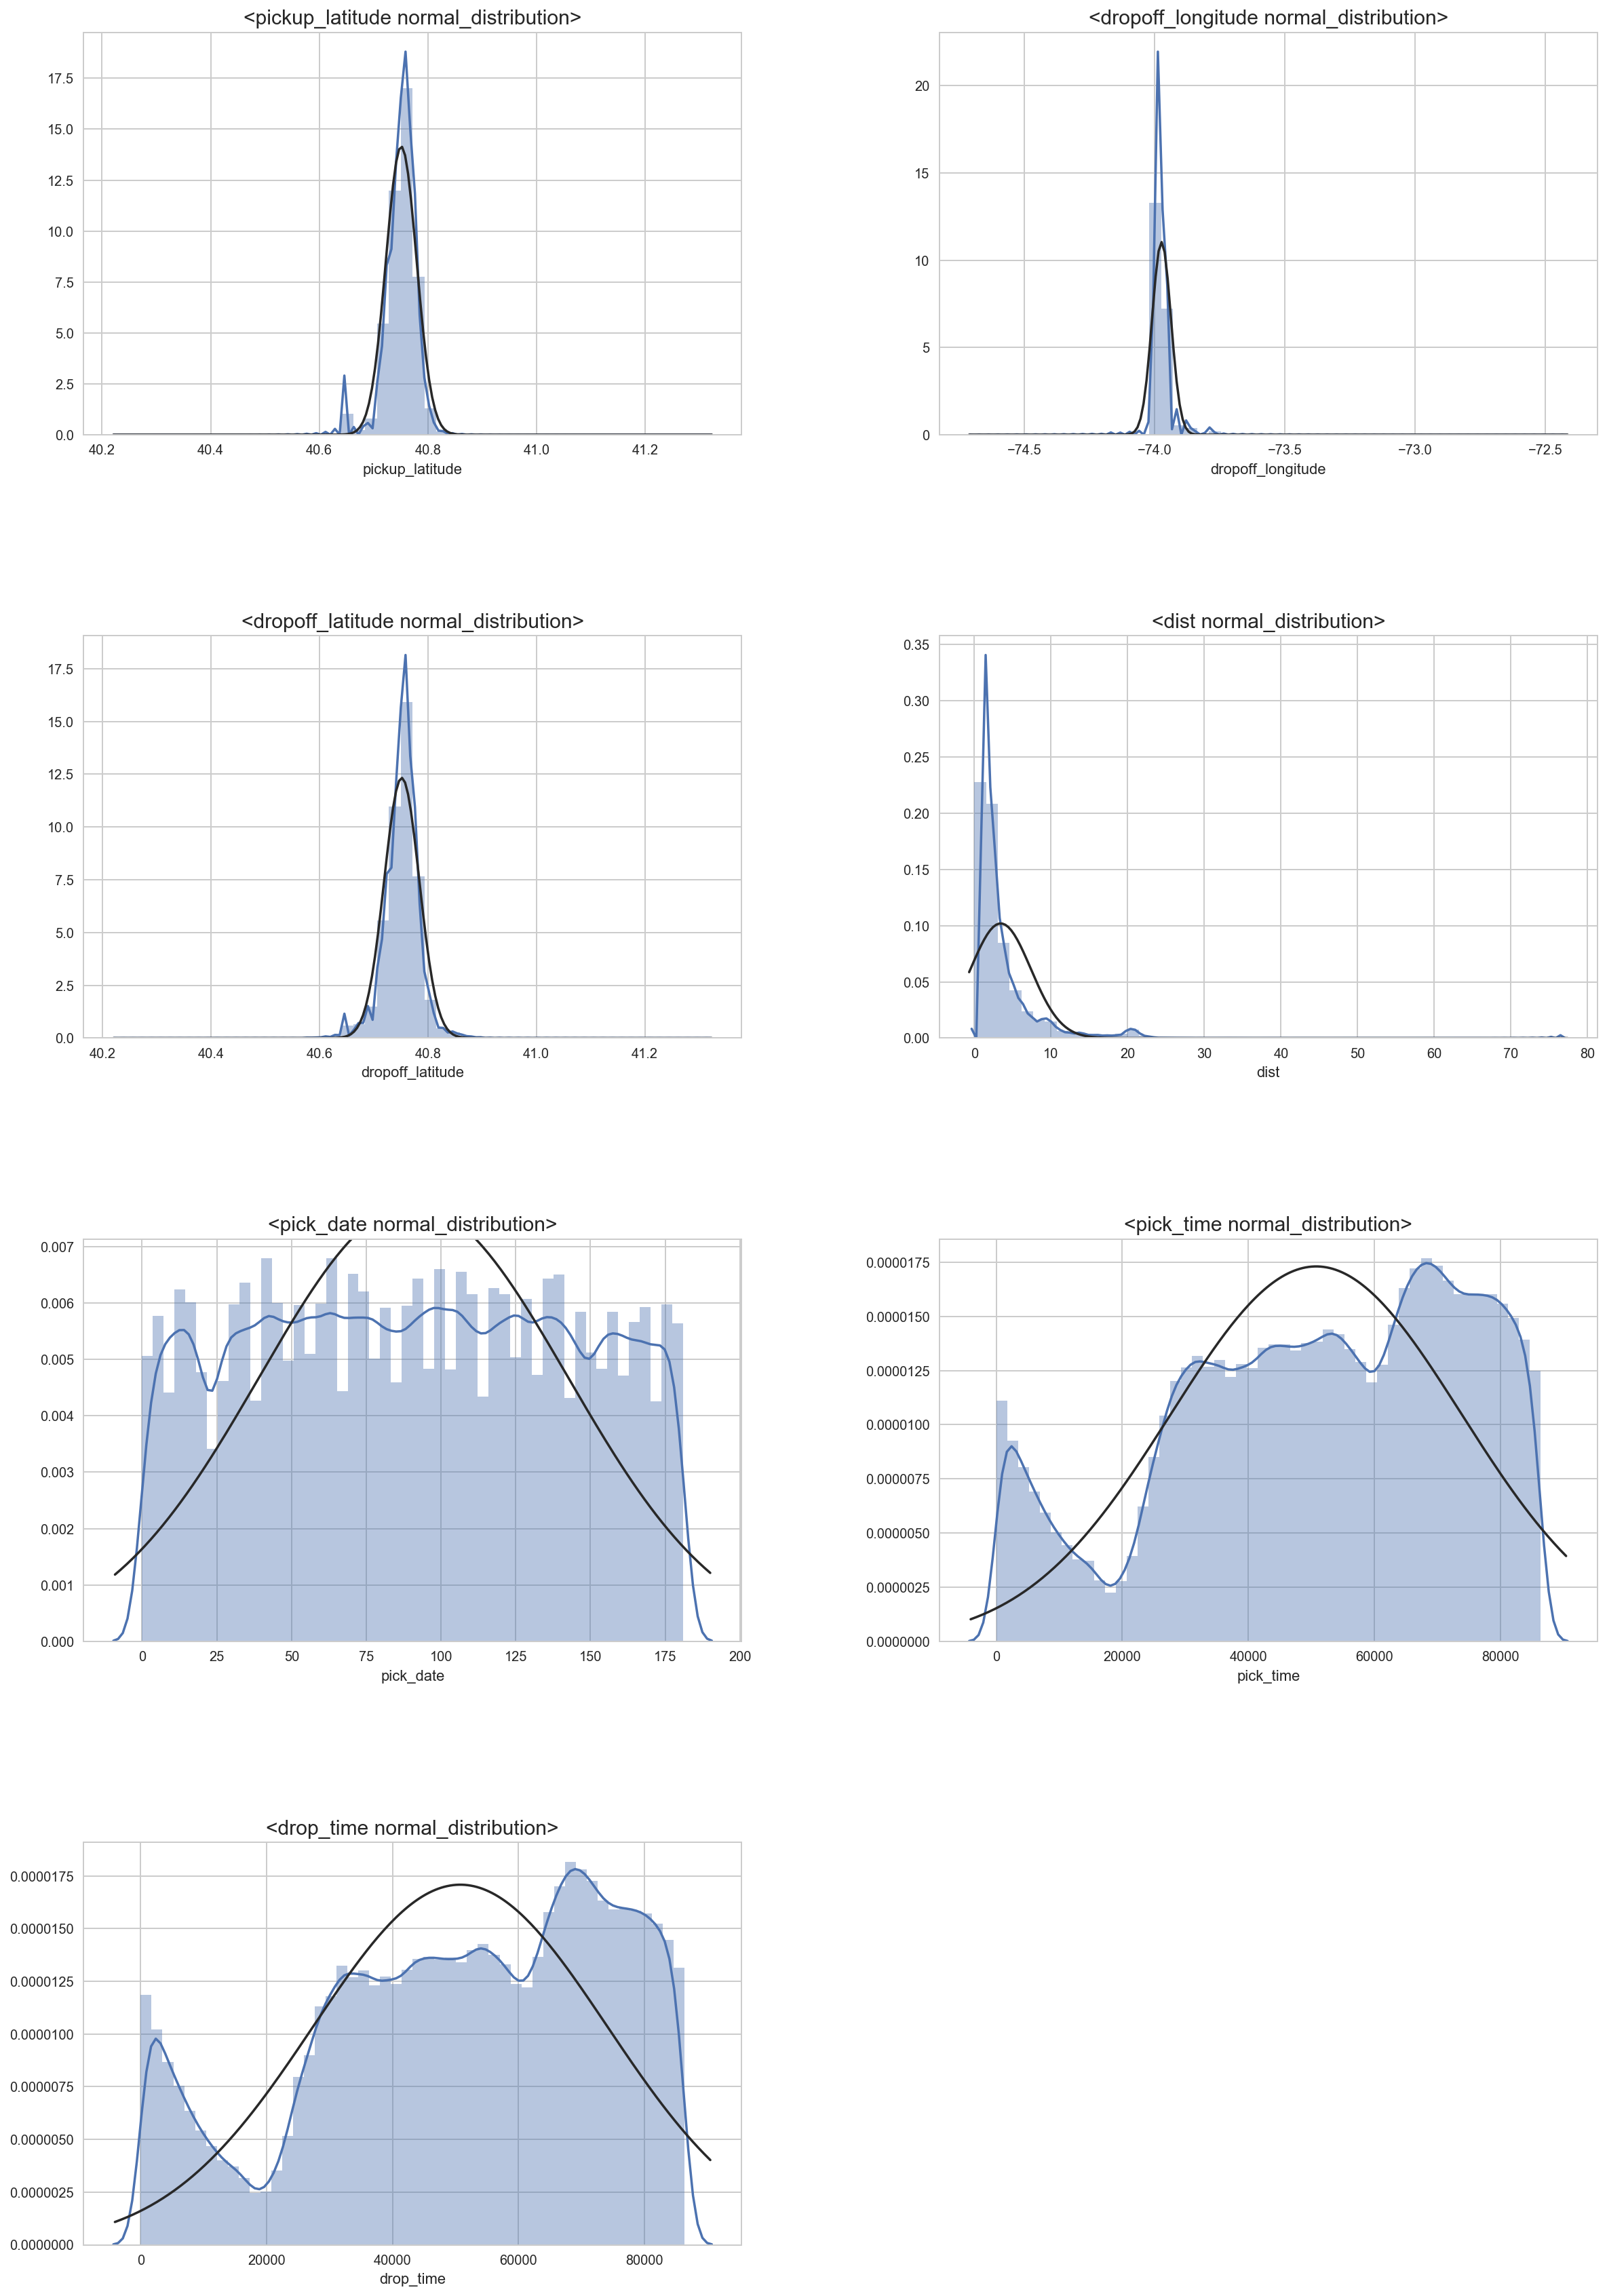

In [23]:
# 정규분포
plt.figure(figsize = (20, 30))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pickup_latitude 정규분포
plt.subplot(421)
sns.distplot(taxi_3['pickup_latitude'], kde = True, fit=sp.stats.norm)
plt.title('<pickup_latitude normal_distribution>', fontsize = 15)

# dropoff_longitude 정규분포
plt.subplot(422)
sns.distplot(taxi_3['dropoff_longitude'], kde = True, fit=sp.stats.norm)
plt.title('<dropoff_longitude normal_distribution>', fontsize = 15)

# dropoff_latitude 정규분포
plt.subplot(423)
sns.distplot(taxi_3['dropoff_latitude'], kde = True, fit=sp.stats.norm)
plt.title('<dropoff_latitude normal_distribution>', fontsize = 15)

# dist 정규분포
plt.subplot(424)
sns.distplot(taxi_3['dist'], kde = True, fit=sp.stats.norm)
plt.title('<dist normal_distribution>', fontsize = 15)

# pick_date 정규분포
plt.subplot(425)
sns.distplot(taxi_3['pick_date'], kde = True, fit = sp.stats.norm)
plt.title('<pick_date normal_distribution>', fontsize = 15)

# pick_time 정규분포
plt.subplot(426)
sns.distplot(taxi_3['pick_time'], kde=True, fit = sp.stats.norm)
plt.title('<pick_time normal_distribution>', fontsize = 15)

# drop_time 정규분포
plt.subplot(427)
sns.distplot(taxi_3['drop_time'], kde = True, fit = sp.stats.norm)
plt.title('<drop_time normal_distribution>', fontsize = 15)

plt.show()

In [24]:
taxi_4 = taxi_3.drop(['Intercept', 'trip_duration'], axis = 1)
taxi_4.corr()

id  pickup_longitude  pickup_latitude  \
id                  1.00              0.00            -0.00   
pickup_longitude    0.00              1.00            -0.14   
pickup_latitude    -0.00             -0.14             1.00   
dropoff_longitude  -0.00              0.29             0.05   
dropoff_latitude   -0.00              0.04             0.43   
dist                0.00              0.51            -0.31   
pick_date           0.00              0.01            -0.00   
pick_time           0.00              0.02             0.01   
drop_time           0.00              0.02             0.02   
weekday            -0.00             -0.03            -0.03   
holiday            -0.00              0.01            -0.00   
vendor_id           0.00              0.02             0.00   
passenger_count     0.00              0.00            -0.01   
store_and_fwd_flag  0.00              0.02            -0.01   

                    dropoff_longitude  dropoff_latitude  dist  pick_date  \
id                              -0.00             -0.00  0.00       0.00   
pickup_longitude                 0.29              0.04  0.51       0.01   
pickup_latitude                  0.05              0.43 -0.31      -0.00   
dropoff_longitude                1.00              0.13  0.36       0.01   
dropoff_latitude                 0.13              1.00 -0.16      -0.00   
dist                             0.36             -0.16  1.00       0.02   
pick_date                        0.01             -0.00  0.02       1.00   
pick_time                       -0.04              0.02 -0.02      -0.00   
drop_time                       -0.04              0.02 -0.02      -0.00   
weekday                         -0.00             -0.02  0.01      -0.01   
holiday                          0.00             -0.00  0.01      -0.14   
vendor_id                        0.00              0.00  0.01      -0.01   
passenger_count                 -0.00             -0.00  0.01      -0.00   
store_and_fwd_flag               0.02             -0.01  0.03       0.00   

                    pick_time  drop_time  weekday  holiday  vendor_id  \
id                       0.00       0.00    -0.00    -0.00       0.00   
pickup_longitude         0.02       0.02    -0.03     0.01       0.02   
pickup_latitude          0.01       0.02    -0.03    -0.00       0.00   
dropoff_longitude       -0.04      -0.04    -0.00     0.00       0.00   
dropoff_latitude         0.02       0.02    -0.02    -0.00       0.00   
dist                    -0.02      -0.02     0.01     0.01       0.01   
pick_date               -0.00      -0.00    -0.01    -0.14      -0.01   
pick_time                1.00       0.93    -0.08    -0.01       0.01   
drop_time                0.93       1.00    -0.09    -0.01       0.01   
weekday                 -0.08      -0.09     1.00    -0.10       0.00   
holiday                 -0.01      -0.01    -0.10     1.00       0.00   
vendor_id                0.01       0.01     0.00     0.00       1.00   
passenger_count          0.01       0.01     0.03     0.00       0.29   
store_and_fwd_flag       0.00       0.00    -0.00     0.00      -0.08   

                    passenger_count  store_and_fwd_flag  
id                             0.00                0.00  
pickup_longitude               0.00                0.02  
pickup_latitude               -0.01               -0.01  
dropoff_longitude             -0.00                0.02  
dropoff_latitude              -0.00               -0.01  
dist                           0.01                0.03  
pick_date                     -0.00                0.00  
pick_time                      0.01                0.00  
drop_time                      0.01                0.00  
weekday                        0.03               -0.00  
holiday                        0.00                0.00  
vendor_id                      0.29               -0.08  
passenger_count                1.00               -0.02  
store_and_fwd_flag         

In [26]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(taxi_4.values, i) for i in range(taxi_4.shape[1])]
vif["features"] = taxi_4.columns
vif

VIF Factor            features
0         4.00                  id
1         0.96    pickup_longitude
2         1.20     pickup_latitude
3         0.74   dropoff_longitude
4         1.12    dropoff_latitude
5         1.04                dist
6         1.02           pick_date
7         7.67           pick_time
8         7.68           drop_time
9         1.02             weekday
10        1.03             holiday
11        1.10           vendor_id
12        1.09     passenger_count
13        1.01  store_and_fwd_flag

---

# Modeling

#### basic model
- with outlier
- without outlier

#### model with extra data ( weather, gasoline )
- with outlier
- without outlier

In [ ]:
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.", "Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])

## basic model

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ ", data = taxi) # data 수정 필요
result1 = model.fit()
storage(result1, result_sets, 'basic')

## basic model w/o outlier

In [ ]:
basic_filtered, dropped = erase_outlier_np(result, taxi, category=True, dropped=True)

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ {}", data = basic_filtered)
result2 = model.fit()
storage(result2, result_sets, 'basic_w/o_outlier')

## model with extra data

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ {}", data = extra) # data 수정 필요
result3 = model.fit()
storage(result3, result_sets, 'extra')

## advanced model w/o outlier

In [ ]:
extra_filtered, dropped = erase_outlier_np(result, extra, category=True, dropped=True)

In [ ]:
model = sm.OLS.from_formula("trip_duration ~ {}", data = extra_filtered) # data 수정 필요
result4 = model.fit()
storage(result4, result_sets, 'extra_w/o_outlier')

# 비교

In [ ]:
result_sets

결과 진단

In [ ]:
result.summary() # 가장 좋은 데이터 1개

잔차 정규성

In [ ]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)
plt.show()

이분산 검정

In [ ]:
plt.scatter(taxi['pick_date'], result.resid)
plt.show()

자기상관

In [ ]:
durbin_watson(result.wresid)

---

# Cross validation
- score: kaggle 기준 (Root Mean Squared Logarithmic Error)

    - 현재 항목은 test용으로 넣어놓음/ 모델링 항목에서 만든 최적 모델 시행


In [7]:
score, result_set = cross_validater("np.log(trip_duration) ~ np.log1p(dist)", taxi, 3, r_seed=3)

In [8]:
result_set

R-square          AIC          BIC  Cond.No.  Pb(Fstatics)  Pb(omnibus)  \
0     0.561  1525722.234  1525745.809     4.509           0.0          0.0   
1     0.561  1524005.249  1524028.824     4.506           0.0          0.0   
2     0.560  1526681.469  1526705.044     4.511           0.0          0.0   

   Pb(jb)  Dub-Wat                                 Remarks  
0     0.0    1.998  np.log(trip_duration) ~ np.log1p(dist)  
1     0.0    1.995  np.log(trip_duration) ~ np.log1p(dist)  
2     0.0    1.998  np.log(trip_duration) ~ np.log1p(dist)

In [9]:
score

[4.5195665055377354, 4.5213004381479589, 4.5210229385907814]

In [21]:
score, result_set = cross_validater("np.log(trip_duration) ~  scale(pick_time) + scale(np.log1p(dist))", taxi, 3, r_seed=3)

In [22]:
result_set

R-square          AIC          BIC  Cond.No.  Pb(Fstatics)  Pb(omnibus)  \
0     0.563  1519794.508  1519829.871     1.017           0.0          0.0   
1     0.563  1517826.471  1517861.834     1.020           0.0          0.0   
2     0.562  1520688.727  1520724.090     1.018           0.0          0.0   

   Pb(jb)  Dub-Wat                                            Remarks  
0     0.0    1.998  np.log(trip_duration) ~  scale(pick_time) + sc...  
1     0.0    1.994  np.log(trip_duration) ~  scale(pick_time) + sc...  
2     0.0    1.998  np.log(trip_duration) ~  scale(pick_time) + sc...

In [23]:
score # kaggle 677등 수준

[4.5195477519732119, 4.5212650356815294, 4.5209783577489917]

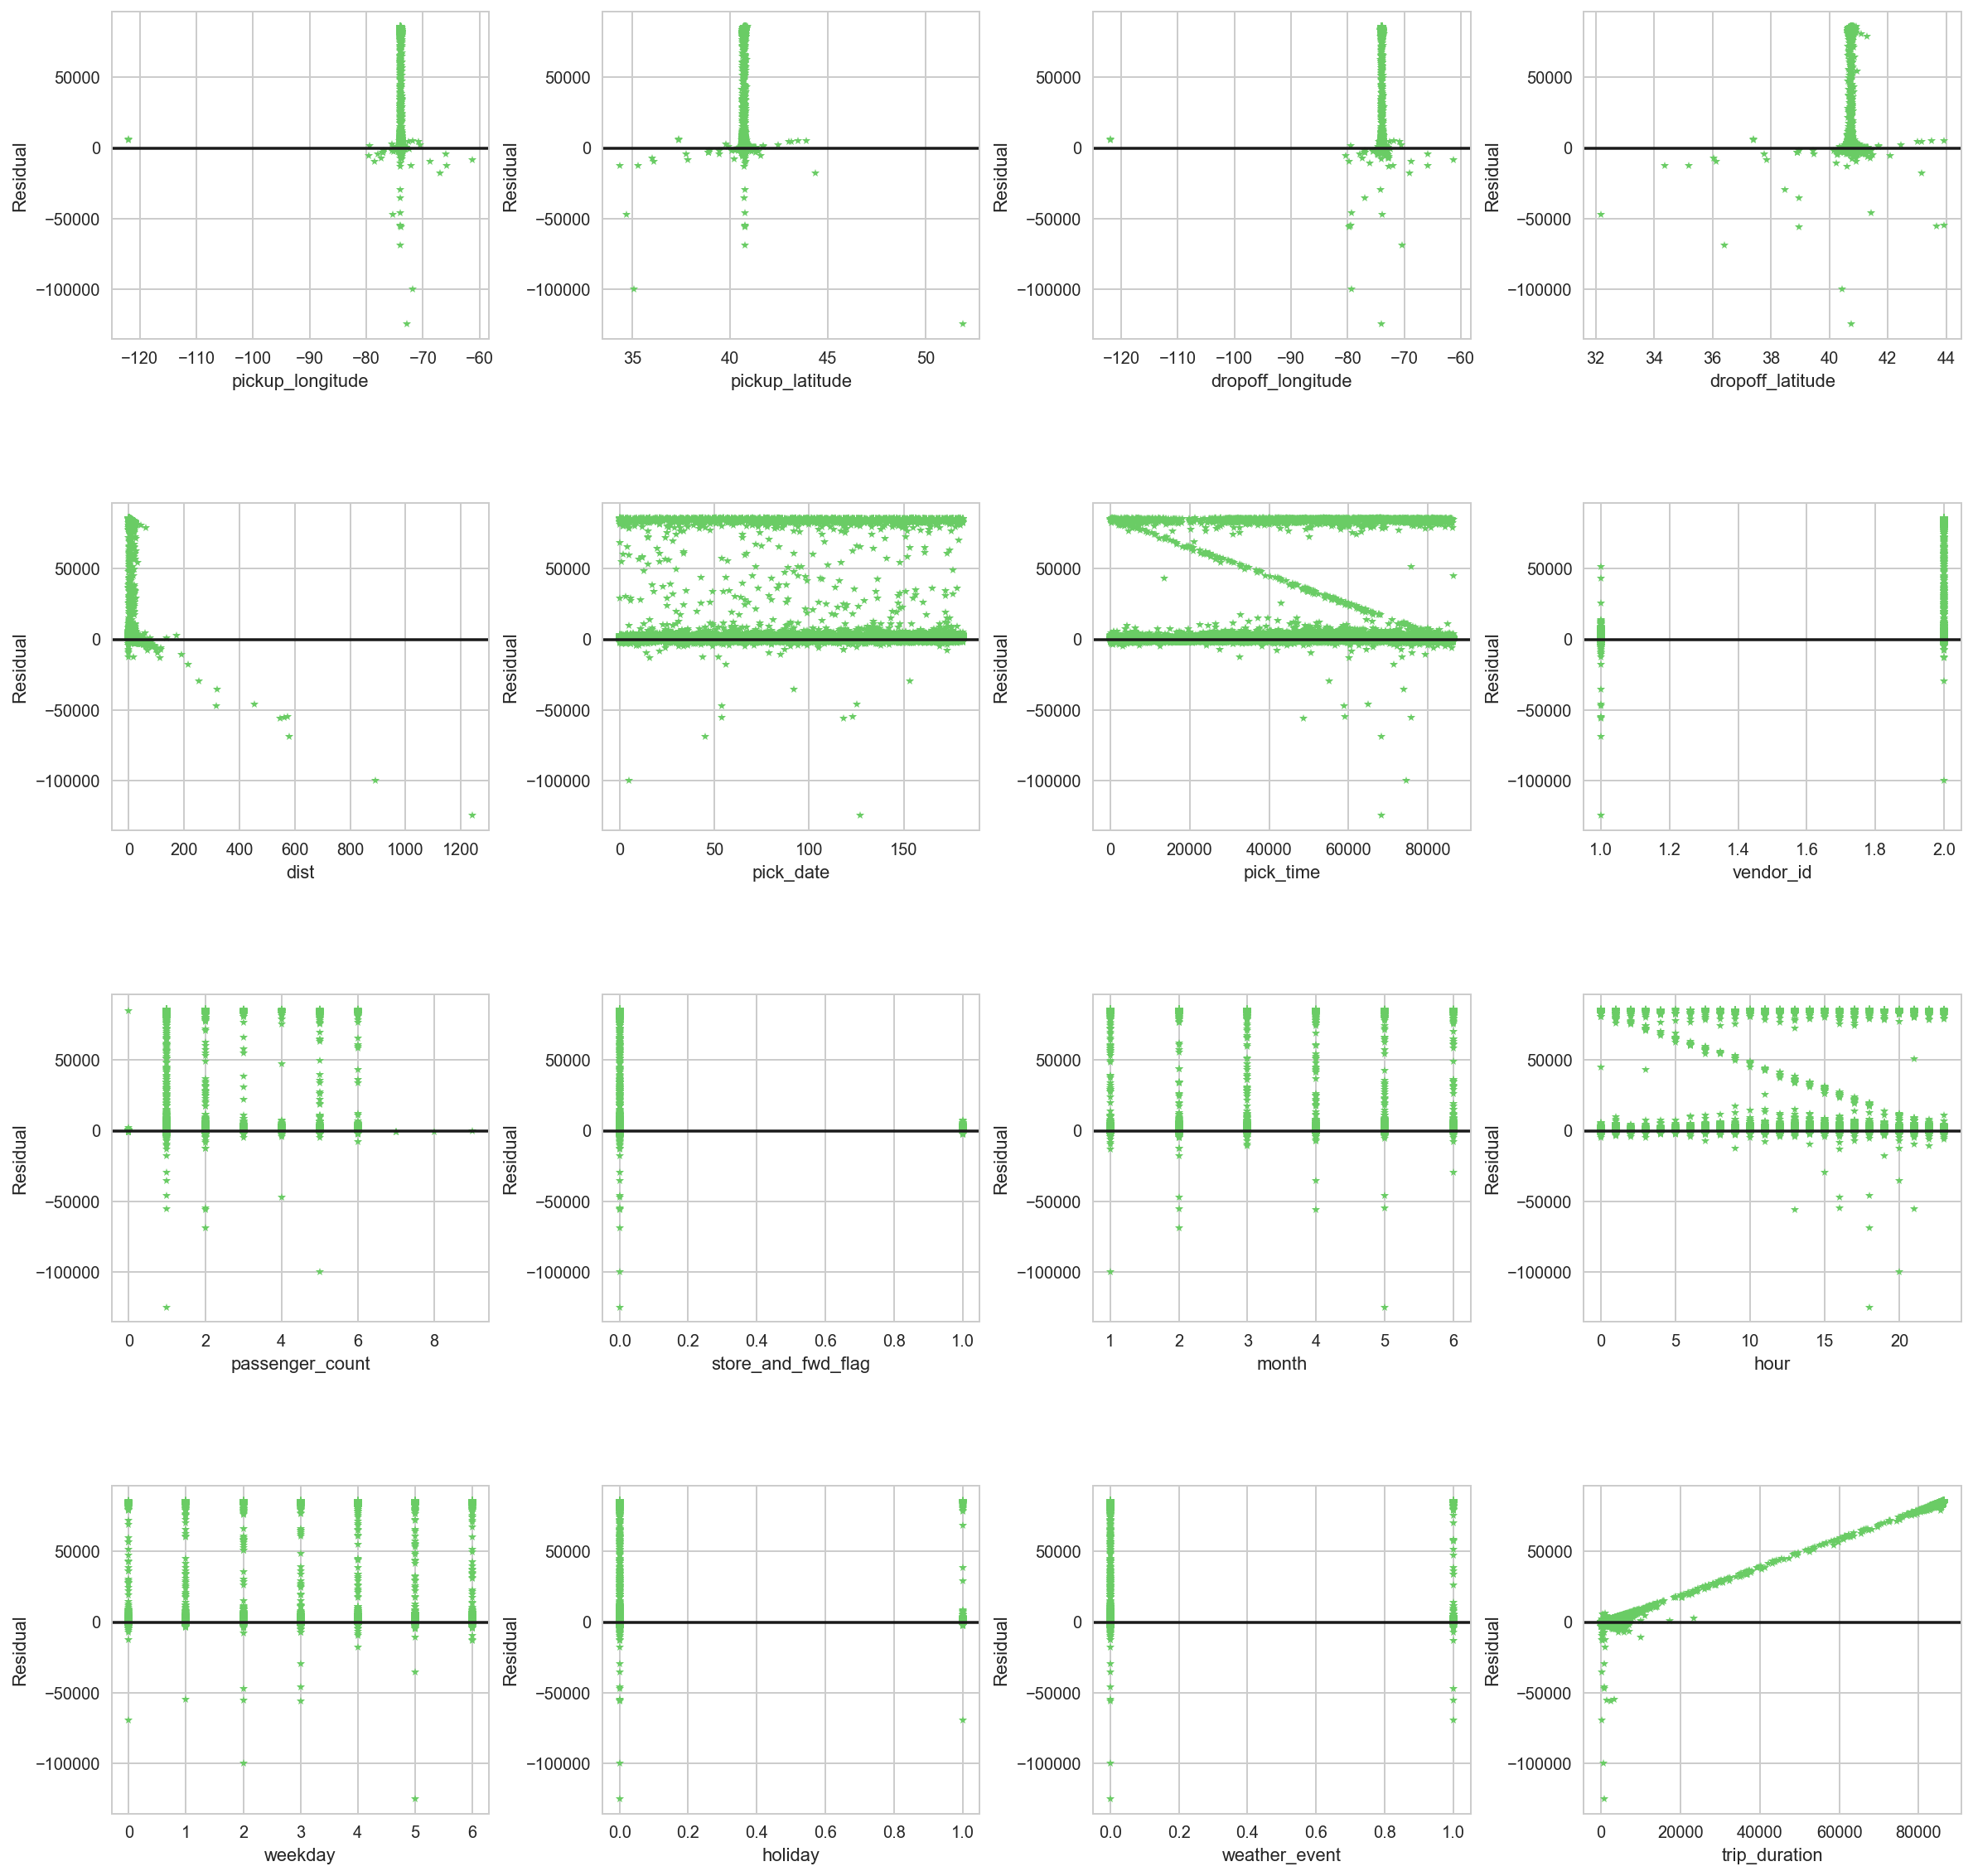

In [39]:
# plot (residual - feature)
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

# pickup_longitude
plt.subplot(4,4,1)
plt.plot(taxi['pickup_longitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pickup_longitude")
plt.ylabel("Residual")

# pickup_latitude
plt.subplot(4,4,2)
plt.plot(taxi['pickup_latitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pickup_latitude")
plt.ylabel("Residual")

# dropoff_longitude
plt.subplot(4,4,3)
plt.plot(taxi['dropoff_longitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dropoff_longitude")
plt.ylabel("Residual")

# dropoff_latitude
plt.subplot(4,4,4)
plt.plot(taxi['dropoff_latitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dropoff_latitude")
plt.ylabel("Residual")

# dist
plt.subplot(4,4,5)
plt.plot(taxi['dist'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("dist")
plt.ylabel("Residual")

# pick_date
plt.subplot(4,4,6)
plt.plot(taxi['pick_date'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pick_date")
plt.ylabel("Residual")

# pick_time
plt.subplot(4,4,7)
plt.plot(taxi['pick_time'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pick_time")
plt.ylabel("Residual")

# vendor_id
plt.subplot(4,4,8)
plt.plot(taxi['vendor_id'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("vendor_id")
plt.ylabel("Residual")

# passenger_count 
plt.subplot(4,4,9) 
plt.plot(taxi['passenger_count'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("passenger_count")
plt.ylabel("Residual")

# store_and_fwd_flag
plt.subplot(4,4,10)
plt.plot(taxi['store_and_fwd_flag'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("store_and_fwd_flag")
plt.ylabel("Residual")

# month
plt.subplot(4,4,11)
plt.plot(taxi['month'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("month")
plt.ylabel("Residual")

# hour
plt.subplot(4,4,12)
plt.plot(taxi['hour'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("hour")
plt.ylabel("Residual")

# weekday
plt.subplot(4,4,13)
plt.plot(taxi['weekday'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("weekday")
plt.ylabel("Residual")

# holiday
plt.subplot(4,4,14)
plt.plot(taxi['holiday'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("holiday")
plt.ylabel("Residual")

# weather_event
plt.subplot(4,4,15)
plt.plot(taxi['weather_event'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("weather_event")
plt.ylabel("Residual")

# trip_duration
plt.subplot(4,4,16)
plt.plot(taxi['trip_duration'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("trip_duration")
plt.ylabel("Residual")

plt.show()

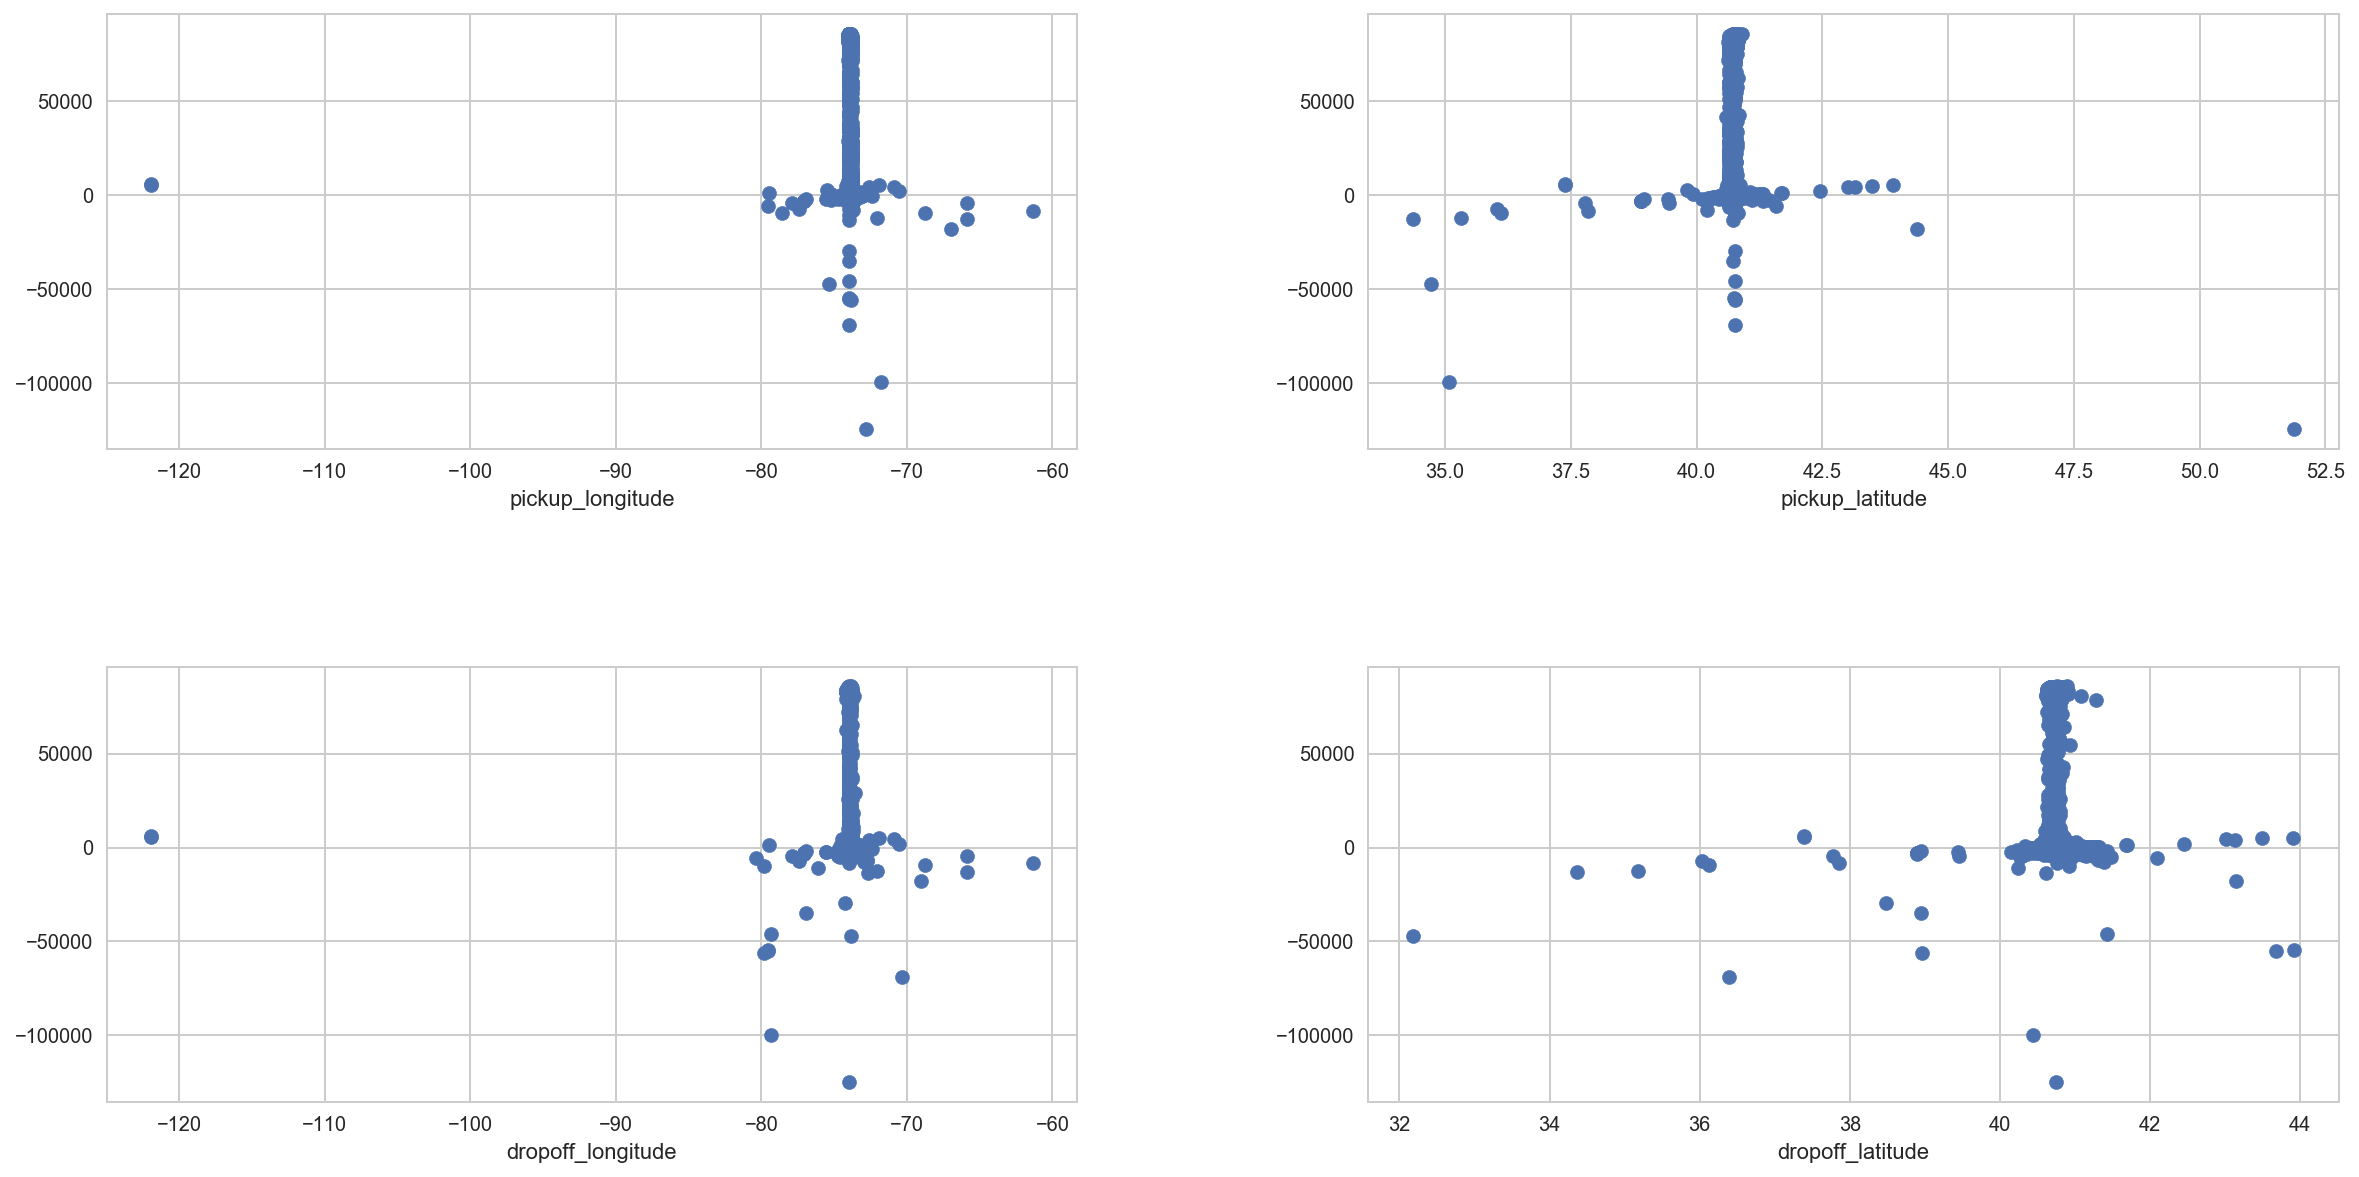

In [61]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.xlabel("pickup_longitude")
plt.scatter(taxi['pickup_longitude'], result.resid)

plt.subplot(222)
plt.xlabel("pickup_latitude")
plt.scatter(taxi['pickup_latitude'], result.resid)

plt.subplot(223)
plt.xlabel("dropoff_longitude")
plt.scatter(taxi['dropoff_longitude'], result.resid)

plt.subplot(224)
plt.xlabel("dropoff_latitude")
plt.scatter(taxi['dropoff_latitude'], result.resid)

plt.show()

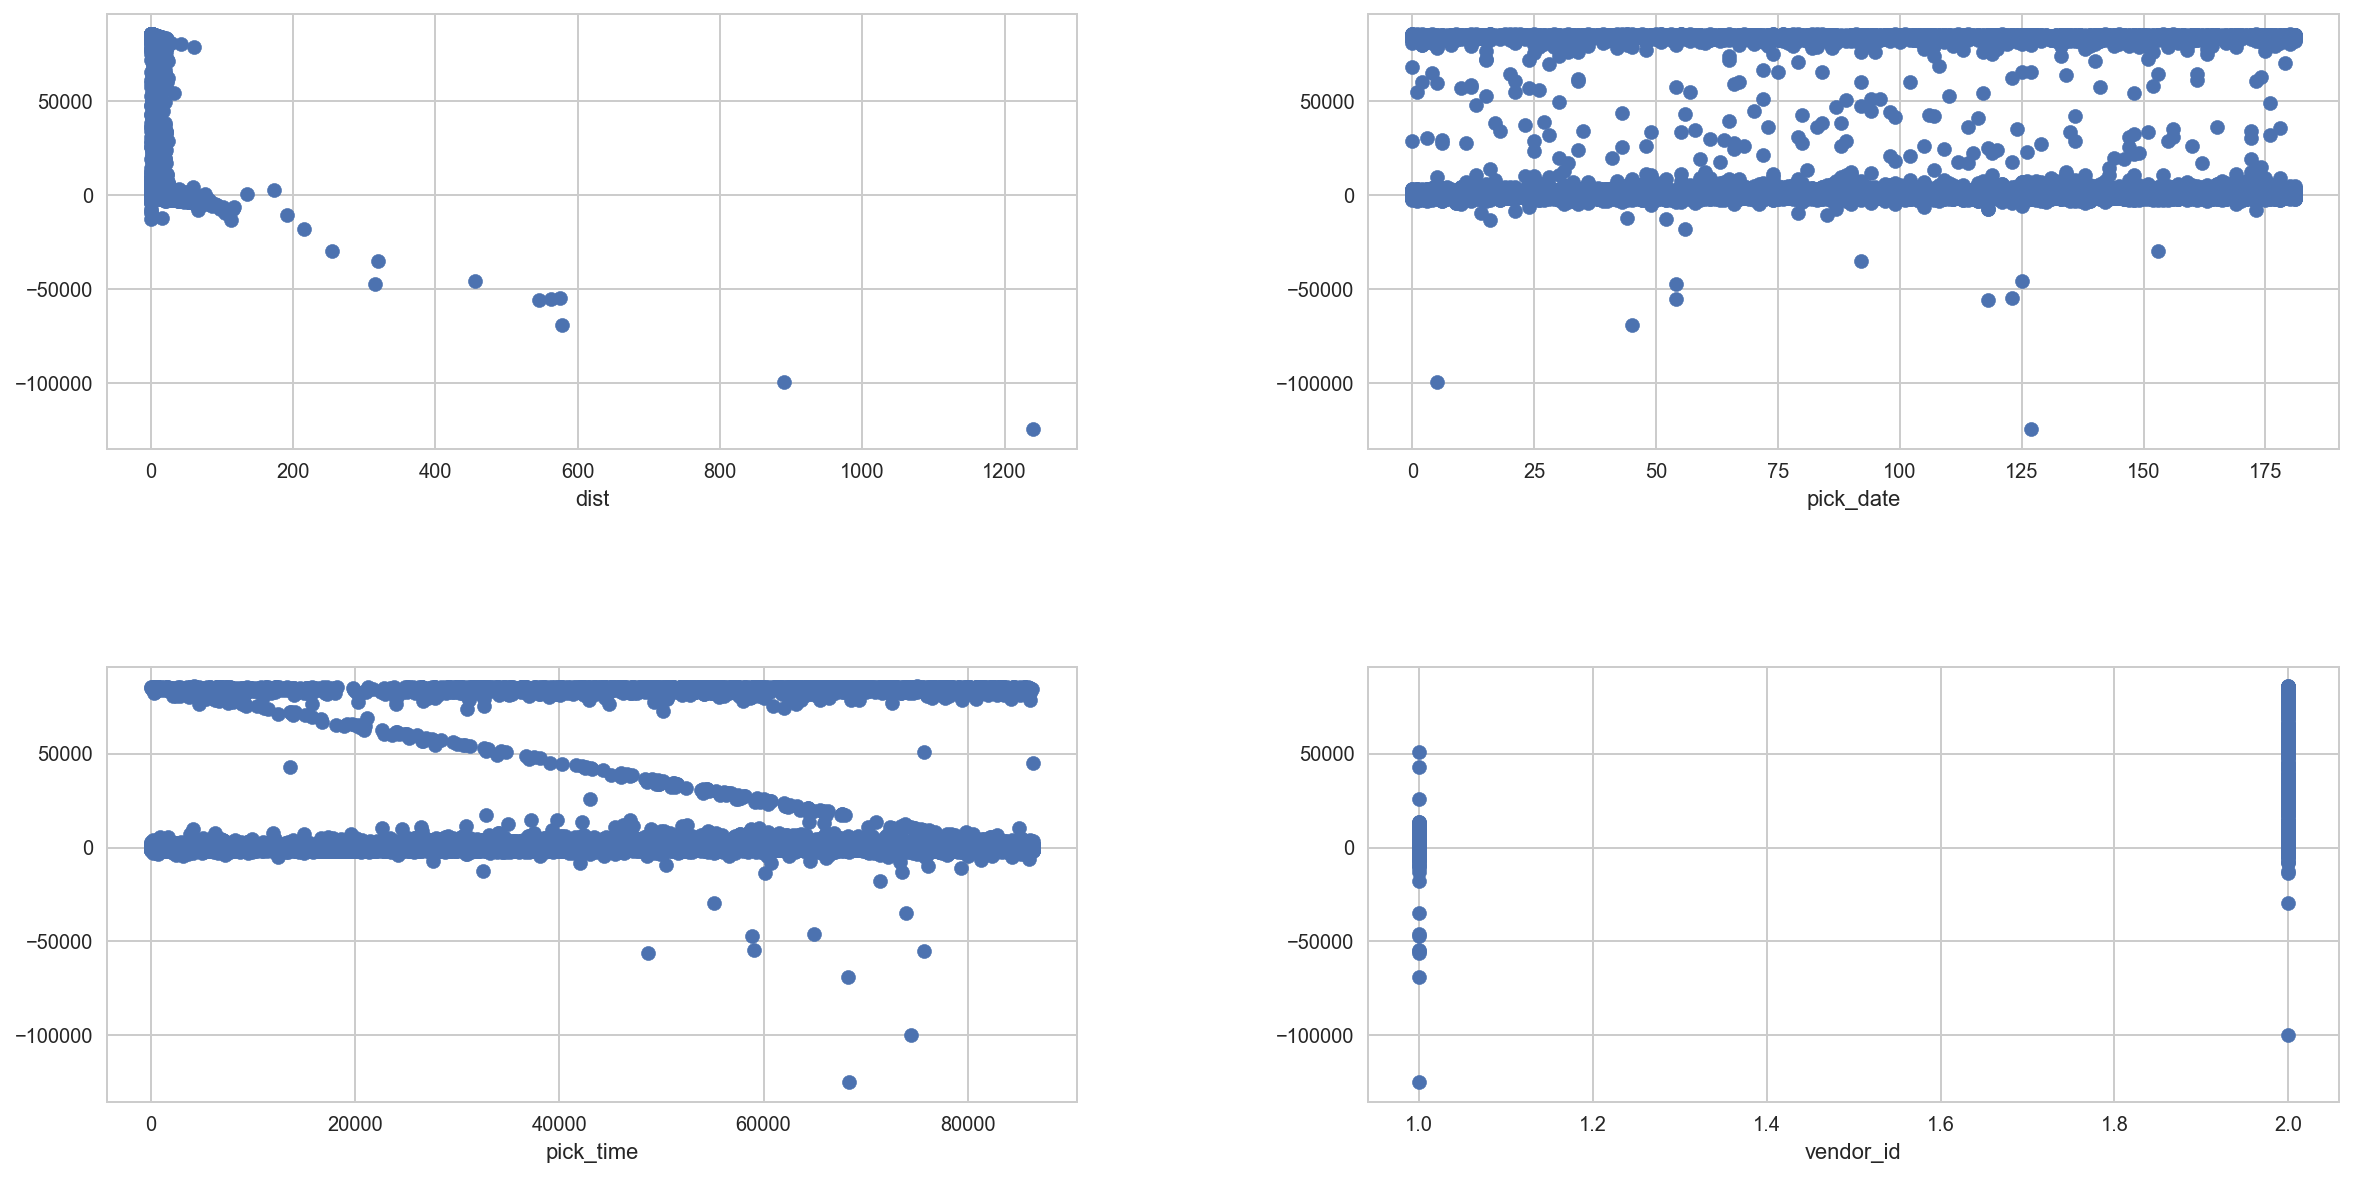

In [60]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
  
plt.subplot(221)
plt.xlabel("dist")
plt.scatter(taxi['dist'], result.resid)

plt.subplot(222)
plt.xlabel("pick_date")
plt.scatter(taxi['pick_date'], result.resid)

plt.subplot(223)
plt.xlabel("pick_time")
plt.scatter(taxi['pick_time'], result.resid)

plt.subplot(224)
plt.xlabel("vendor_id")
plt.scatter(taxi['vendor_id'], result.resid)

plt.show()

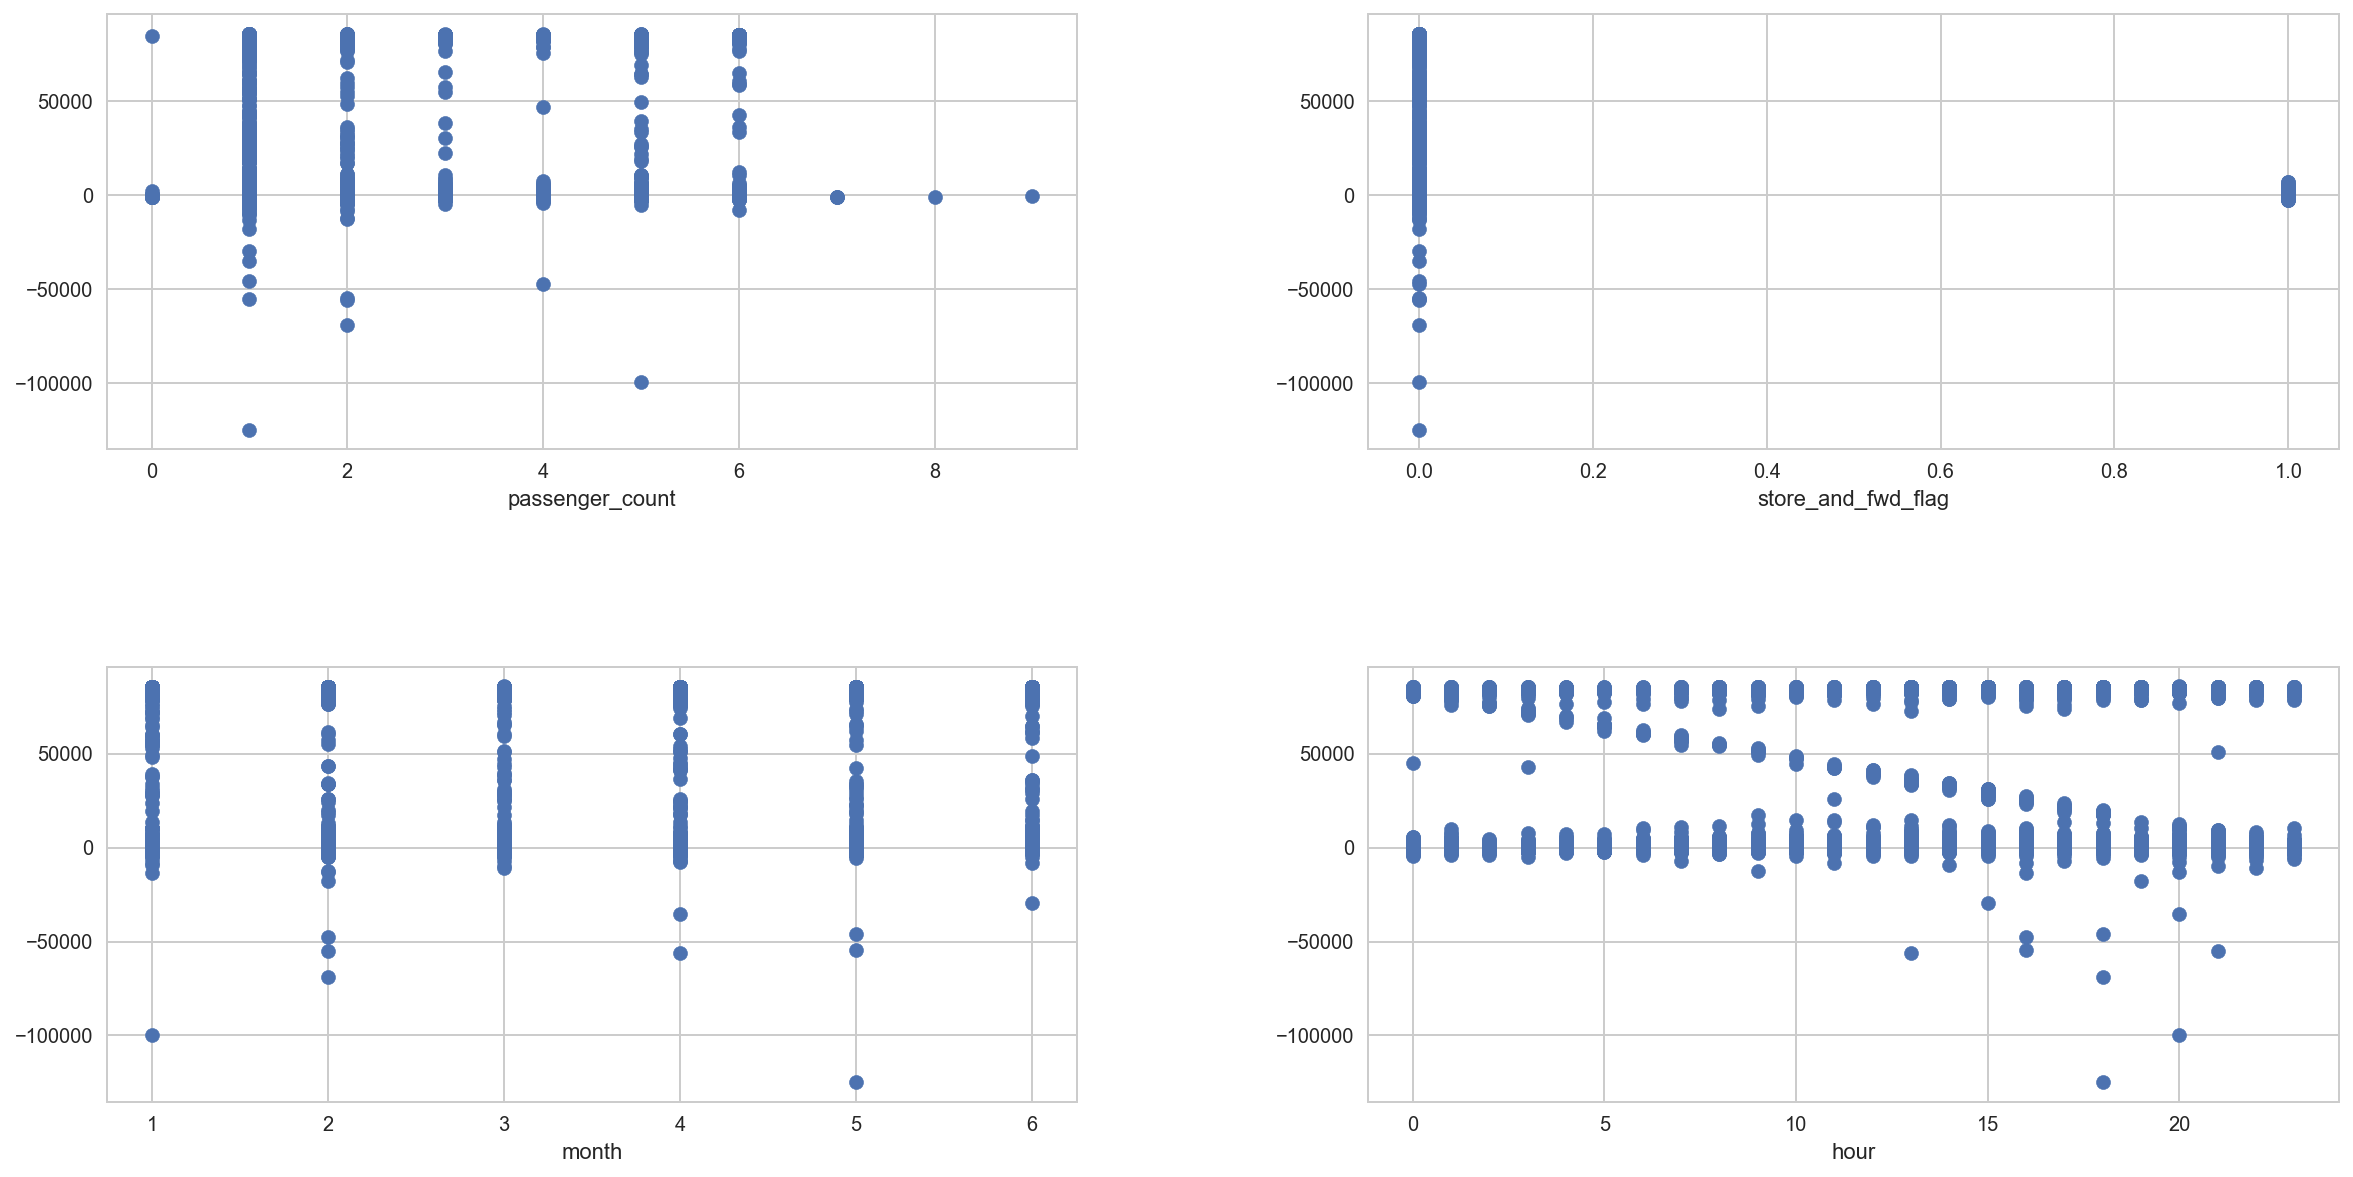

In [62]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
   
plt.subplot(221)
plt.xlabel("passenger_count")
plt.scatter(taxi['passenger_count'], result.resid)

plt.subplot(222)
plt.xlabel("store_and_fwd_flag")
plt.scatter(taxi['store_and_fwd_flag'], result.resid)

plt.subplot(223)
plt.xlabel("month")
plt.scatter(taxi['month'], result.resid)

plt.subplot(224)
plt.xlabel("hour")
plt.scatter(taxi['hour'], result.resid)

plt.show()

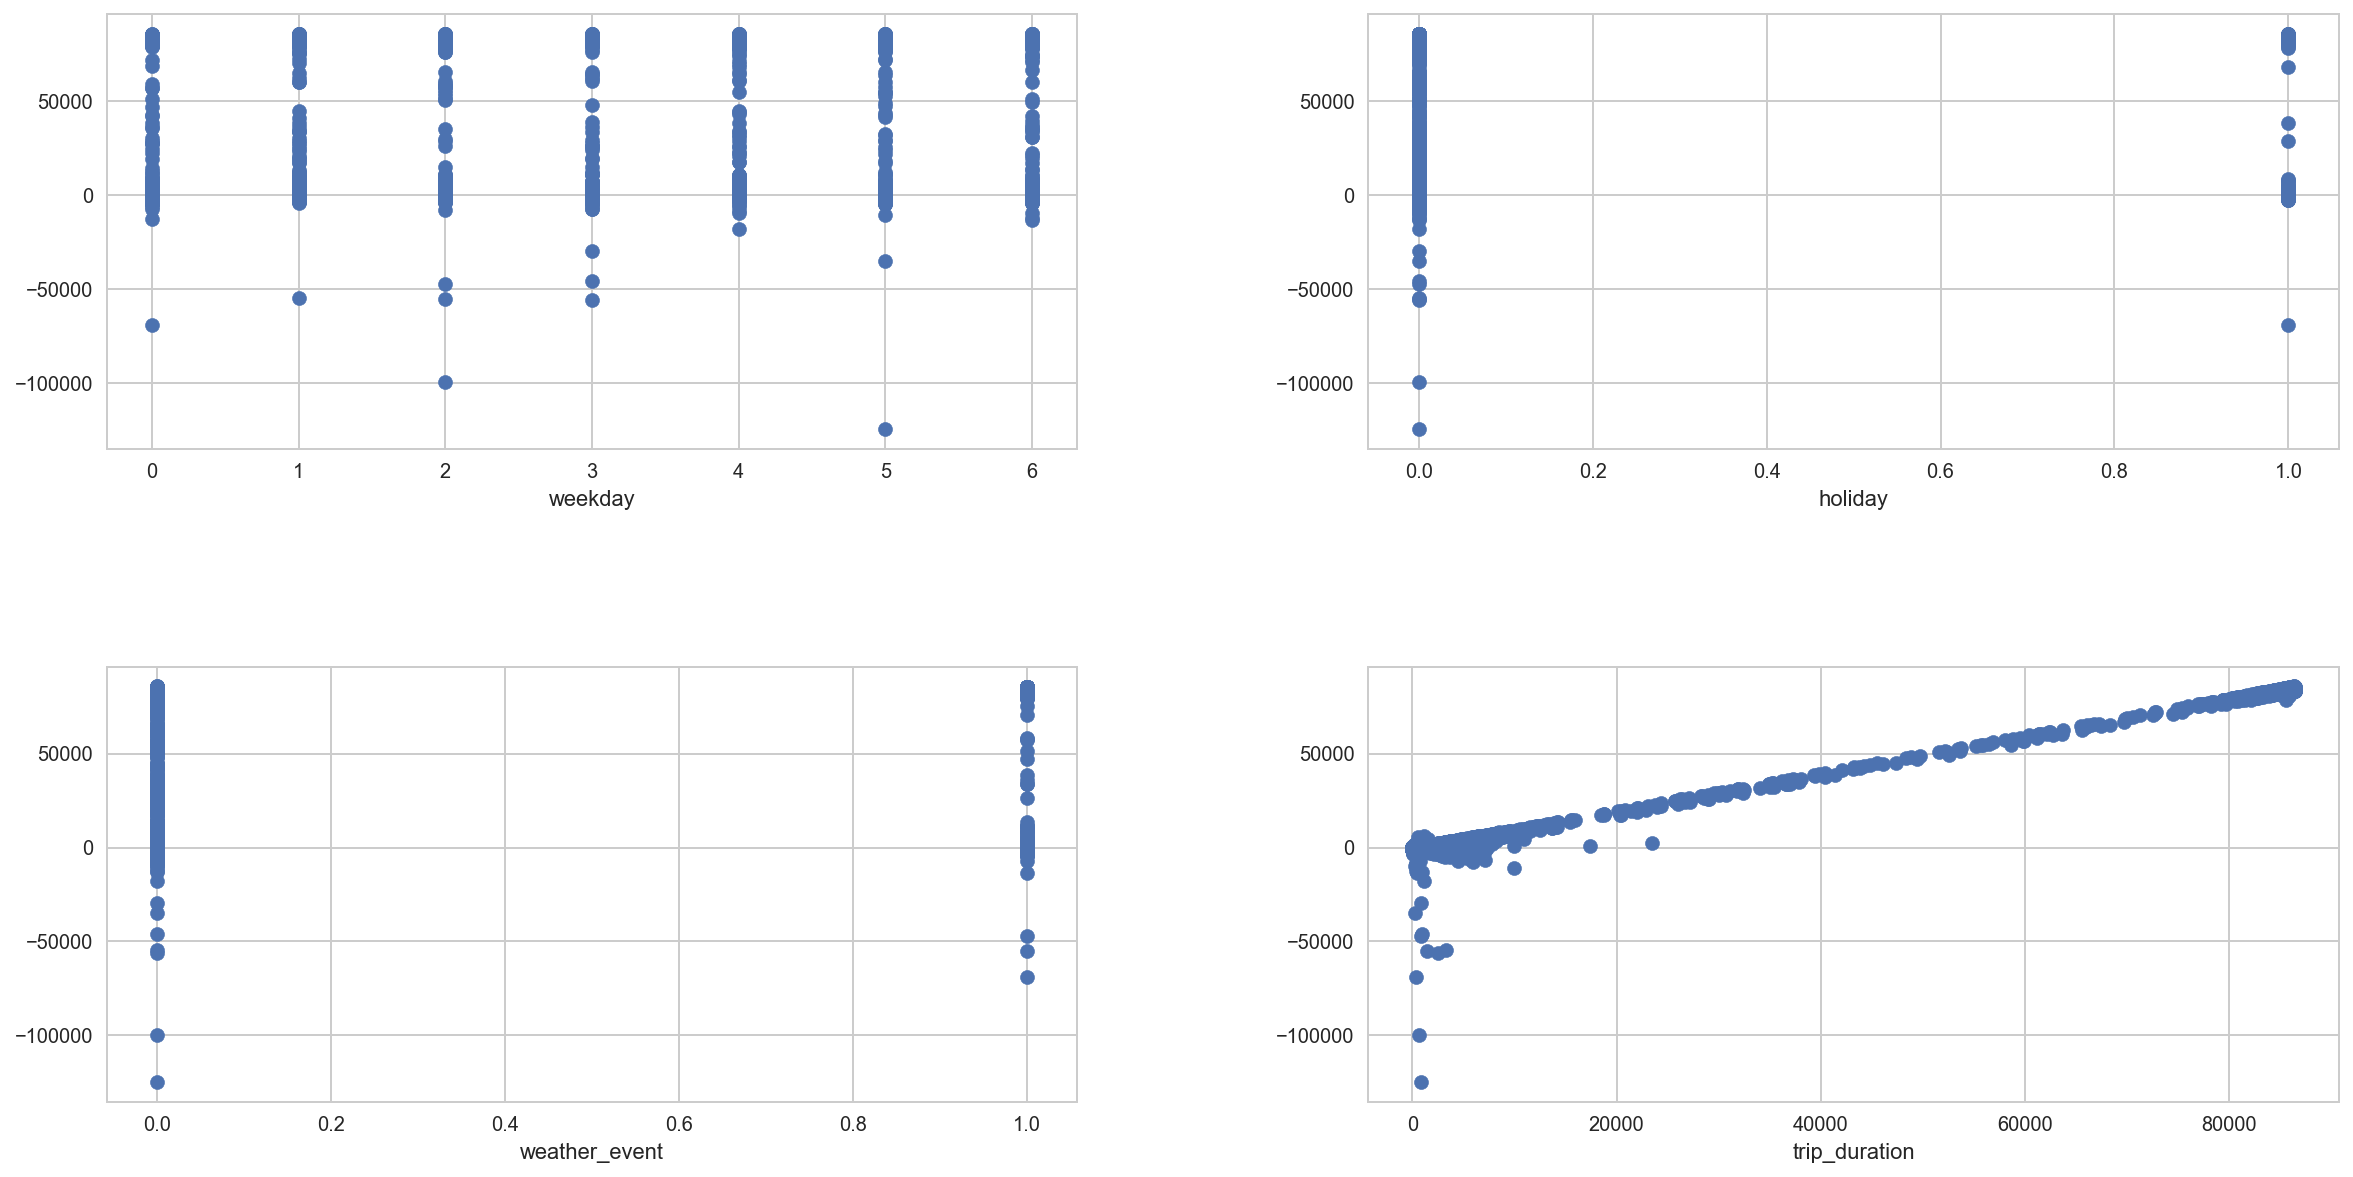

In [63]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

plt.subplot(221)
plt.xlabel("weekday")
plt.scatter(taxi['weekday'], result.resid)

plt.subplot(222)
plt.xlabel("holiday")
plt.scatter(taxi['holiday'], result.resid)

plt.subplot(223)
plt.xlabel("weather_event")
plt.scatter(taxi['weather_event'], result.resid)

plt.subplot(224)
plt.xlabel("trip_duration")
plt.scatter(taxi['trip_duration'], result.resid)

plt.show()

---

# Kaggle result

In [ ]:
kaggle = pd.read_csv("test_taxi.csv")

In [ ]:
y_hat = result.predict(kaggle)
y_hat = y_hat.apply(lambda x: int(round(np.exp(x))))
ans = pd.concat([kaggle['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0:'trip_duration'}, inplace=True)
ans.tail()

In [ ]:
# import math
# ans['trip_duration'] = ans['trip_duration'].apply(lambda x: 0 if math.isnan(x) else x)

In [ ]:
ans.to_csv('answer.csv', index=False)

결과 : 

---

# Conclusion